In [1]:
from tools_stance import * 
from models import *
import torch 
import pandas as pd

n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

if torch.cuda.is_available():     
    device = torch.device("cuda")
    print('There are',torch.cuda.device_count(),'GPU(s) available.')
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


dict_cl=dict()
dict_cl[0]="NonH"
dict_cl[1]="IndirectH"
dict_cl[2]="PhysicalH"
dict_cl[3]="SexualH"

#sdqc
d_lab=dict()
d_lab["NonH"]=0
d_lab["IndirectH"]=1
d_lab["PhysicalH"]=2
d_lab["SexualH"]=3

path="../Datasets/CSV_Harassment/"
train =pd.read_csv(path + "train_format.csv")
val=pd.read_csv(path + "val_format.csv")
test=pd.read_csv(path + "test_format.csv")

stoplist = stopwords.words("english")
puntos='!?."()[´]“<>¡¿-/;:=_”@#.'

Using TensorFlow backend.
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

There are 1 GPU(s) available.
We will use the GPU: GeForce GTX 1060 6GB


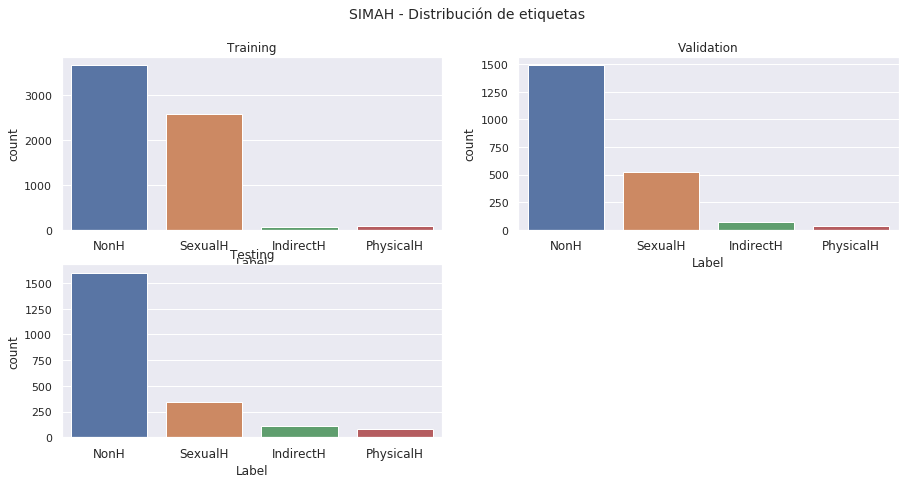

In [2]:
import seaborn as sns
sns.set(font_scale=1)
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,7))
j=220
labs=["NonH", "SexualH", "IndirectH", "PhysicalH"]
data=[train['Label'], val['Label'], test["Label"]]
name=["Training", "Validation", "Testing"]
for i in range(3):
    j+=1
    h=fig.add_subplot(j)
    ax= sns.countplot(data[i], order=labs)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
    h.title.set_text(str(name[i]))

fig.suptitle("SIMAH - Distribución de etiquetas", fontsize=14)
plt.show()

In [3]:
def cm_norma(matrix):
    return matrix/matrix.sum(axis=-1, keepdims=True)

def predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, name_model):
    etiq = etiq.astype("int")
    trainPredict = trained.predict(x_train, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc= accuracy_score(etiq, trainPredict)  
    f1=f1_score(etiq, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma=f1_score(etiq, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    print ("")
    print ("------ Training ------")
    print ("Accuracy", name_model, ":",acc)  
    print ("F1-score None", name_model, ":",f1)
    print ("F1-score macro", name_model, ":",f1_ma)
    ########################################
    trainPredict = trained.predict(x_val, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc= accuracy_score(etiq_v, trainPredict)  
    f1=f1_score(etiq_v, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma=f1_score(etiq_v, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    print ("")
    print ("------ Validation ------")
    print ("Accuracy", name_model, ":",acc)  
    print ("F1-score None", name_model, ":",f1)
    print ("F1-score macro", name_model, ":",f1_ma)
    ########################################
    trainPredict = trained.predict(x_test, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc_t= accuracy_score(etiq_t, trainPredict)  
    f1_t=f1_score(etiq_t, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma_t=f1_score(etiq_t, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    matriz_t=cm_norma(confusion_matrix(etiq_t, trainPredict))
    print ("")
    print ("------ Testing ------")
    print ("Accuracy", name_model, ":",acc_t)  
    print ("F1-score None", name_model, ":",f1_t)
    print ("F1-score macro", name_model, ":",f1_ma_t)
    
    return f1_ma_t, f1_t, acc_t, matriz_t

def cleaner(post): 
    s= re.sub(r"http\S+", " html ", post)   ##########elimina http    
    s= re.sub(r'#\w+ ?', " hashtag ", s) ########3
    s= re.sub(r'@\w+ ?', " user ", s)##############    
    s= s.lower()
    s=emoji_pattern.sub(r'', s)
    s=re.sub(r"'\b", " ' ", s)
    s=re.sub(r"\b'\b", " ' ", s)
    s=re.sub(r"“\b", " “ ", s)
    s=re.sub(r"\b’", " ’ ", s)
    s=re.sub(r"‘\b", " ‘ ", s)
    s=re.sub(r"\b’\b", " ‘ ", s)
    s = re.sub(r"-", " - ", s)
    s = re.sub(r"\(", " ", s)
    s = re.sub(r"\)", " ", s)
    s = re.sub(r"\?", " ? ", s)    
    s = re.sub(r"\/", " ", s)
    s = re.sub(r"' ", " ' ", s)
    s = re.sub(r" '", " ' ", s)
    s = re.sub(r"\!", " ! ", s)
    s=re.sub("[\.]+", " . ", s)
    s=re.sub("[\,]+", " , ", s)
    s=re.sub("[\;]+", " ; ", s)
    s=re.sub("[\:]+", " : ", s)
    s=re.sub('[\"]+', ' " ', s)
    s=re.sub(r'\b[0-9]\b', " number ",  s)
    s=re.sub(r'\b[0-9]*[0-9]\b', " number ",  s)    
    s=re.sub(r'\b”', ' " ', s)
    sl= list(s.split())
    sl_2=[]
    for wd in sl:
        try: 
            q=token_2_idx[wd]
            sl_2.append(wd)
        except:
            try: 
                if stemmer.stem(wd) in token_2_idx.keys():
                    sl_2.append(stemmer.stem(wd))
                elif lemmatizer.lemmatize(wd) in token_2_idx.keys():
                    sl_2.append(lemmatizer.lemmatize(wd))
                else:
                    sl_2.append(wd)
            except:
                sl_2.append(wd)
    sl=sl_2
    s=' '.join([word for word in sl])# if word not in stoplist])
    return s, sl

In [4]:
import os 
embeddings_index = {}
token_2_idx={}
idx_2_token={}
f = open(os.path.join("../Datasets/glove.twitter.27B.200d.txt"))#'glove.twitter.27B.100d.txt'))
i=0
for line in f:
    values = line.split()
    if len(values)>200:
        word = values[0]
    else:
        #print ("Problema con line ", line)
        continue
    token_2_idx[word]=i
    idx_2_token[i]=word
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
    i+=1
f.close()

print('Se encontraron %s terminos con sus vectores de embedding.' % len(embeddings_index))

Se encontraron 1193513 terminos con sus vectores de embedding.


In [5]:
MAX_LEN = 34
emb=200
EMB_matrix=np.zeros((len(token_2_idx.keys()), emb))
for i in range(len(token_2_idx.keys())):
    EMB_matrix[i]=embeddings_index[idx_2_token[i]]
    
transformer = Normalizer().fit(EMB_matrix) 
EMB_matrix=transformer.transform(EMB_matrix)
EMB_matrix.shape

(1193513, 200)

In [6]:
ids_train=train['tweet_id']
tws_train=train['Tweet']
labels_train=[d_lab[lb] for lb in train['Label']]
class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
#class_weights= [1.0, 1.0, 1.0, 1.0]
class_weights=np.asarray(class_weights)
print ("Pesos de clases:", class_weights)

ids_val=val['tweet_id']
tws_val=val['Tweet']
labels_val=[d_lab[lb] for lb in val['Label']]

ids_test=test['tweet_id']
tws_test=test['Tweet']
labels_test=[d_lab[lb] for lb in test['Label']]

Pesos de clases: [ 0.43526359 28.97272727 20.96710526  0.61715724]


In [7]:
sentences = tws_train
n_labels = np.asarray(labels_train)
y_train=to_categorical(n_labels,num_classes=4)

sentences_val = tws_val
n_labels_val = np.array(labels_val)
y_val=to_categorical(n_labels_val,num_classes=4)

sentences_test = tws_test
n_labels_test = np.array(labels_test)
y_test=to_categorical(n_labels_test,num_classes=4)

In [8]:
input_ids=[]
for sent in sentences:
    encoded_sent=[]
    for wd in cleaner(sent)[1]:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids.append(encoded_sent) 
    
input_ids_val=[]
for sent in sentences_val:
    encoded_sent=[]
    for wd in cleaner(sent)[1]:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids_val.append(encoded_sent) 

input_ids_test=[]
for sent in sentences_test:
    encoded_sent=[]
    for wd in cleaner(sent)[1]:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids_test.append(encoded_sent) 
    

In [9]:
input_ids = pad_sequences(input_ids,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")
input_ids_val = pad_sequences(input_ids_val,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")
input_ids_test = pad_sequences(input_ids_test,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")

shape=np.asarray(input_ids).shape
shape_val=np.asarray(input_ids_val).shape
shape_test=np.asarray(input_ids_test).shape

In [10]:
x_train=np.zeros((shape[0], shape[1], emb))
j=0
for in_id in input_ids:
    x_train[j]=EMB_matrix[in_id]
    j+=1
    
x_val=np.zeros((shape_val[0], shape_val[1], emb))
i=0
for in_id in input_ids_val:
    x_val[i]=EMB_matrix[in_id]
    i+=1
    
x_test=np.zeros((shape_test[0], shape_test[1], emb))
i=0
for in_id in input_ids_test:
    x_test[i]=EMB_matrix[in_id]
    i+=1

In [11]:
x_train.shape

(6374, 34, 200)

In [12]:
x_test.shape

(2123, 34, 200)

In [ ]:
def train_5models(k, fold, x_train, y_train, n_labels, class_weights, e1, e2):
    fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
    fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
    accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
    confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

    for i in range(1,1+k):    
        print ("\n\n -------------------- Entrenando exec", i," -------------------- \n\n")
        cnn1=create_cnn1(x_train.shape[1:])
        #cnn1=load_model('../Datasets/Models_Stance/0.15/'+str(k)+'/cnn1_'+str(i)+'-exec.h5', custom_objects={'FocalLoss': focal_loss, 'focal_loss_fixed': focal_loss()})
        trained, hist =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=e1, BS=32, verb=0, focal=True)
        trained.save('../Datasets/Models_Harassment/'+fold+'/cnn1_'+str(i)+'-exec.h5')   
        f1_ma_t, f1_t, acc_t, matriz_t = predict_data(cnn1, x_train, x_val, x_test, n_labels, n_labels_val, n_labels_test, 'cnn1')
        keras.backend.clear_session()
        gc.collect()
        
        fs_macro['cnn1'].append(f1_ma_t)
        fs_none['cnn1'].append(f1_t)
        accs['cnn1'].append(acc_t)
        confusions['cnn1'].append(matriz_t)

        cnn2=create_cnn2(x_train.shape[1:])
        #cnn2=load_model('../Datasets/Models_Stance/0.15/'+str(k)+'/cnn2_'+str(i)+'-exec.h5', custom_objects={'FocalLoss': focal_loss, 'focal_loss_fixed': focal_loss()})
        trained, hist =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=e1, BS=32, verb=0, focal=True)
        trained.save('../Datasets/Models_Harassment/'+fold+'/cnn2_'+str(i)+'-exec.h5')
        f1_ma_t, f1_t, acc_t, matriz_t = predict_data(cnn2, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'cnn2')
        keras.backend.clear_session()
        gc.collect()
        
        fs_macro['cnn2'].append(f1_ma_t)
        fs_none['cnn2'].append(f1_t)
        accs['cnn2'].append(acc_t)
        confusions['cnn2'].append(matriz_t)

        rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
        #rnn1=load_model('../Datasets/Models_Stance/0.15/'+str(k)+'/rnn1_'+str(i)+'-exec.h5', custom_objects={'FocalLoss': focal_loss, 'focal_loss_fixed': focal_loss()})
        trained, hist =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=e2, BS=32, verb=0, focal=True)
        trained.save('../Datasets/Models_Harassment/'+fold+'/rnn1_'+str(i)+'-exec.h5')
        f1_ma_t, f1_t, acc_t, matriz_t = predict_data(rnn1, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn1')
        keras.backend.clear_session()
        gc.collect()
        
        fs_macro['rnn1'].append(f1_ma_t)
        fs_none['rnn1'].append(f1_t)
        accs['rnn1'].append(acc_t)
        confusions['rnn1'].append(matriz_t)

        rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
        #rnn2=load_model('../Datasets/Models_Stance/0.15/'+str(k)+'/rnn2_'+str(i)+'-exec.h5')
        trained, hist =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=e1, BS=32, verb=0, focal=False)
        trained.save('../Datasets/Models_Harassment/'+fold+'/rnn2_'+str(i)+'-exec.h5')
        f1_ma_t, f1_t, acc_t, matriz_t = predict_data(rnn2, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn2')
        keras.backend.clear_session()
        gc.collect()
        
        fs_macro['rnn2'].append(f1_ma_t)
        fs_none['rnn2'].append(f1_t)
        accs['rnn2'].append(acc_t)
        confusions['rnn2'].append(matriz_t)

        rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
        #rnn3=load_model('../Datasets/Models_Stance/0.15/'+str(k)+'/rnn3_'+str(i)+'-exec.h5', custom_objects={'FocalLoss': focal_loss, 'focal_loss_fixed': focal_loss()})
        trained, hist =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=e2, BS=32, verb=0, focal=True)
        trained.save('../Datasets/Models_Harassment/'+fold+'/rnn3_'+str(i)+'-exec.h5')
        f1_ma_t, f1_t, acc_t, matriz_t = predict_data(rnn3, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn3')
        keras.backend.clear_session()
        gc.collect()
        
        fs_macro['rnn3'].append(f1_ma_t)
        fs_none['rnn3'].append(f1_t)
        accs['rnn3'].append(acc_t)
        confusions['rnn3'].append(matriz_t)

    return fs_macro, fs_none, accs, confusions

## Original - No aumento


Entrenando exec  1 






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


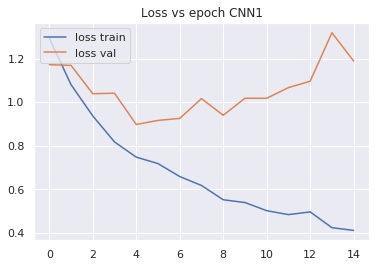


------ Training ------
Accuracy cnn1 : 0.7386256667712582
F1-score None cnn1 : [0.83970136 0.12181617 0.26280624 0.75618839]
F1-score macro cnn1 : 0.495128038942949

------ Validation ------
Accuracy cnn1 : 0.7392941176470588
F1-score None cnn1 : [0.86162625 0.16458853 0.07936508 0.70729053]
F1-score macro cnn1 : 0.4532175973621162

------ Testing ------
Accuracy cnn1 : 0.6872350447479981
F1-score None cnn1 : [0.83643617 0.19933555 0.21374046 0.5029703 ]
F1-score macro cnn1 : 0.43812061835762334


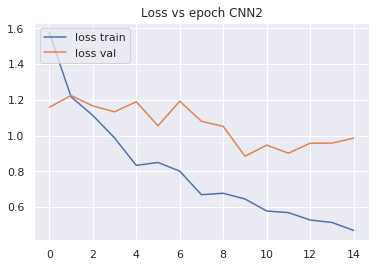

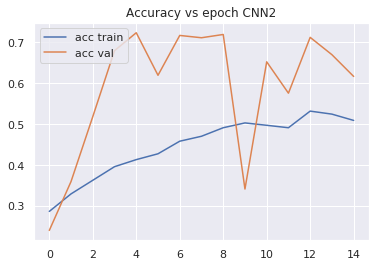


------ Training ------
Accuracy cnn2 : 0.6142139943520553
F1-score None cnn2 : [0.81719484 0.08767577 0.11776251 0.54913607]
F1-score macro cnn2 : 0.39294229553931753

------ Validation ------
Accuracy cnn2 : 0.6169411764705882
F1-score None cnn2 : [0.80717489 0.15511551 0.07171315 0.48814505]
F1-score macro cnn2 : 0.3805371489170988

------ Testing ------
Accuracy cnn2 : 0.5586434291097504
F1-score None cnn2 : [0.76743337 0.16135881 0.24043716 0.19371728]
F1-score macro cnn2 : 0.3407366542100511


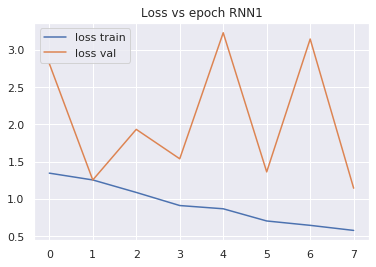


------ Training ------
Accuracy rnn1 : 0.626764982742391
F1-score None rnn1 : [0.74666667 0.05731707 0.12854442 0.73090586]
F1-score macro rnn1 : 0.4158585061835839

------ Validation ------
Accuracy rnn1 : 0.6291764705882353
F1-score None rnn1 : [0.785658   0.1202346  0.07643312 0.67124857]
F1-score macro rnn1 : 0.4133935729261051

------ Testing ------
Accuracy rnn1 : 0.5708902496467263
F1-score None rnn1 : [0.75731105 0.192      0.24203822 0.43859649]
F1-score macro rnn1 : 0.4074864399551206


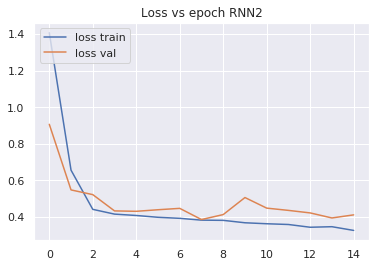

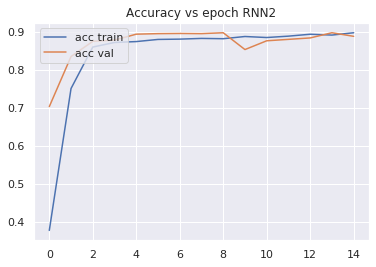


------ Training ------
Accuracy rnn2 : 0.9068089112017571
F1-score None rnn2 : [0.92559188 0.         0.15730337 0.90377633]
F1-score macro rnn2 : 0.4966678947205788

------ Validation ------
Accuracy rnn2 : 0.888
F1-score None rnn2 : [0.93395597 0.         0.         0.85214348]
F1-score macro rnn2 : 0.44652486317796003

------ Testing ------
Accuracy rnn2 : 0.8582195007065473
F1-score None rnn2 : [0.92050209 0.         0.02564103 0.7849162 ]
F1-score macro rnn2 : 0.43276482970213836


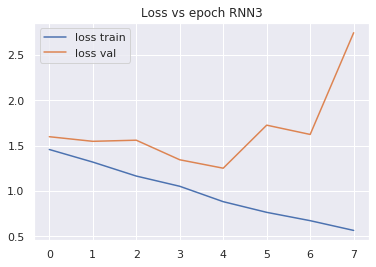

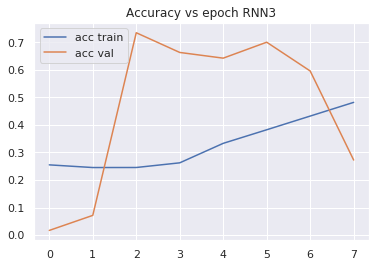


------ Training ------
Accuracy rnn3 : 0.3123627235644807
F1-score None rnn3 : [0.4657308  0.1194605  0.03815416 0.4324016 ]
F1-score macro rnn3 : 0.26393676566508284

------ Validation ------
Accuracy rnn3 : 0.27247058823529413
F1-score None rnn3 : [0.41077086 0.09836066 0.04748982 0.41773963]
F1-score macro rnn3 : 0.24359024067990453

------ Testing ------
Accuracy rnn3 : 0.2680169571361281
F1-score None rnn3 : [0.37856785 0.09478673 0.09370988 0.45      ]
F1-score macro rnn3 : 0.254266116525688

Entrenando exec  2 



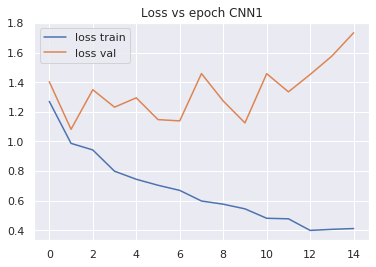

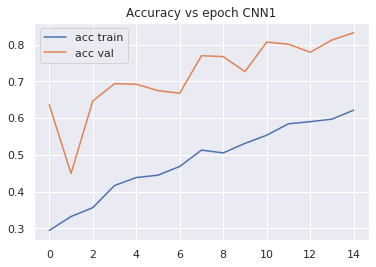


------ Training ------
Accuracy cnn1 : 0.814245371823031
F1-score None cnn1 : [0.88298012 0.32394366 0.34674923 0.76320423]
F1-score macro cnn1 : 0.579219309265797

------ Validation ------
Accuracy cnn1 : 0.8324705882352941
F1-score None cnn1 : [0.91359593 0.0661157  0.09302326 0.72178771]
F1-score macro cnn1 : 0.44863065042920036

------ Testing ------
Accuracy cnn1 : 0.8073480923221856
F1-score None cnn1 : [0.90203964 0.19251337 0.04395604 0.50924025]
F1-score macro cnn1 : 0.4119373257817737


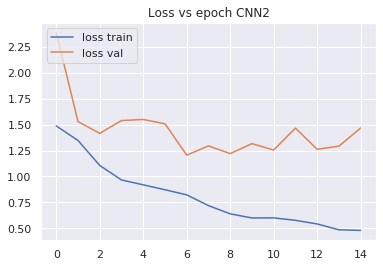

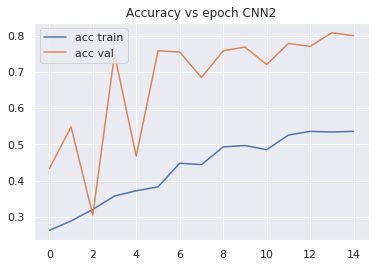


------ Training ------
Accuracy cnn2 : 0.7455287103859429
F1-score None cnn2 : [0.87338501 0.37313433 0.14324324 0.6345    ]
F1-score macro cnn2 : 0.5060656461303372

------ Validation ------
Accuracy cnn2 : 0.7995294117647059
F1-score None cnn2 : [0.90949089 0.05454545 0.07272727 0.61286255]
F1-score macro cnn2 : 0.41240654019914413

------ Testing ------
Accuracy cnn2 : 0.7847385774846914
F1-score None cnn2 : [0.89044944 0.19230769 0.128      0.28641975]
F1-score macro cnn2 : 0.3742942208990898


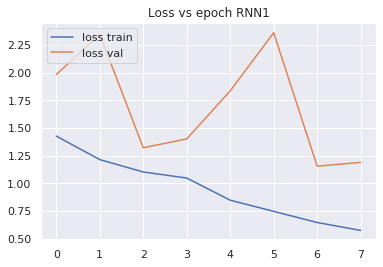

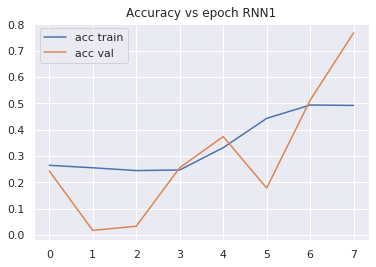


------ Training ------
Accuracy rnn1 : 0.7456855977408221
F1-score None rnn1 : [0.80559398 0.10891089 0.06417112 0.79374762]
F1-score macro rnn1 : 0.4431059017585988

------ Validation ------
Accuracy rnn1 : 0.7675294117647059
F1-score None rnn1 : [0.86664257 0.13084112 0.         0.74524025]
F1-score macro rnn1 : 0.43568098713310216

------ Testing ------
Accuracy rnn1 : 0.723975506358926
F1-score None rnn1 : [0.8538092  0.27533461 0.06896552 0.60387812]
F1-score macro rnn1 : 0.4504968596488896


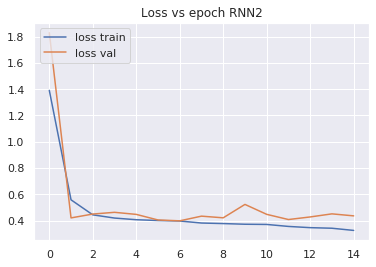

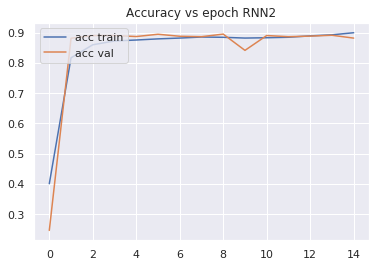


------ Training ------
Accuracy rnn2 : 0.9133981801066834
F1-score None rnn2 : [0.9320518  0.         0.         0.90948108]
F1-score macro rnn2 : 0.4603832180877425

------ Validation ------
Accuracy rnn2 : 0.8818823529411765
F1-score None rnn2 : [0.92764858 0.         0.         0.8374761 ]
F1-score macro rnn2 : 0.44128116955943897

------ Testing ------
Accuracy rnn2 : 0.8516250588789449
F1-score None rnn2 : [0.91727141 0.         0.         0.73667205]
F1-score macro rnn2 : 0.4134858648834324


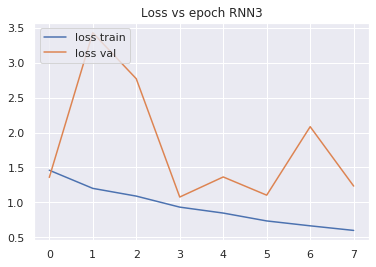

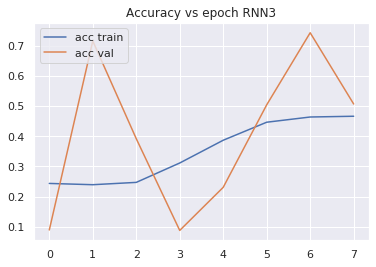


------ Training ------
Accuracy rnn3 : 0.5436146846564167
F1-score None rnn3 : [0.62394543 0.05042816 0.10661765 0.72610903]
F1-score macro rnn3 : 0.37677506727932064

------ Validation ------
Accuracy rnn3 : 0.5068235294117647
F1-score None rnn3 : [0.62059741 0.09892473 0.06711409 0.7112069 ]
F1-score macro rnn3 : 0.37446078396792304

------ Testing ------
Accuracy rnn3 : 0.44747998115873766
F1-score None rnn3 : [0.58031088 0.13232831 0.27777778 0.62589928]
F1-score macro rnn3 : 0.4040790618475095

Entrenando exec  3 



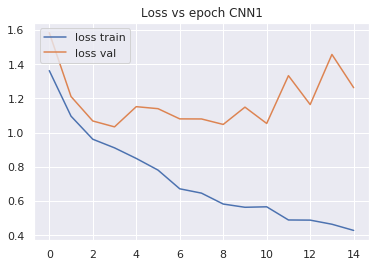

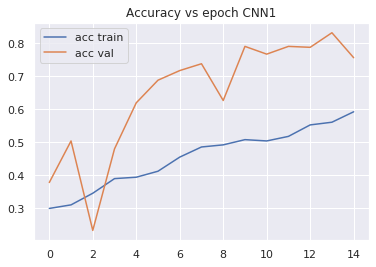


------ Training ------
Accuracy cnn1 : 0.7224662692187009
F1-score None cnn1 : [0.84572057 0.13253012 0.26722338 0.67692308]
F1-score macro cnn1 : 0.4805992863656871

------ Validation ------
Accuracy cnn1 : 0.7567058823529412
F1-score None cnn1 : [0.88010899 0.20911528 0.05714286 0.65550239]
F1-score macro cnn1 : 0.45046738070357706

------ Testing ------
Accuracy cnn1 : 0.7084314649081489
F1-score None cnn1 : [0.85319082 0.19767442 0.08       0.40979955]
F1-score macro cnn1 : 0.385166198416763


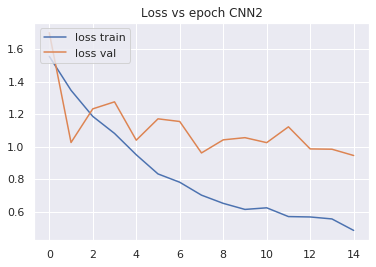

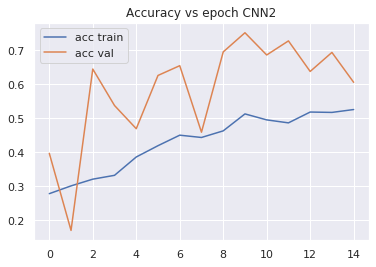


------ Training ------
Accuracy cnn2 : 0.5651082522748666
F1-score None cnn2 : [0.81658217 0.12142039 0.07932011 0.43537015]
F1-score macro cnn2 : 0.3631732051906757

------ Validation ------
Accuracy cnn2 : 0.6056470588235294
F1-score None cnn2 : [0.82492582 0.16450216 0.07025761 0.36691729]
F1-score macro cnn2 : 0.35665072125005104

------ Testing ------
Accuracy cnn2 : 0.5850211964201601
F1-score None cnn2 : [0.78083157 0.19257221 0.24683544 0.1369863 ]
F1-score macro cnn2 : 0.33930638262938784


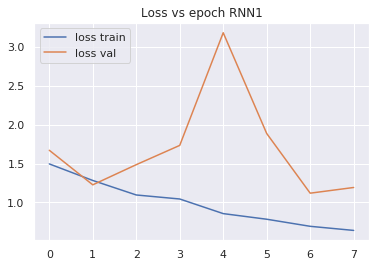

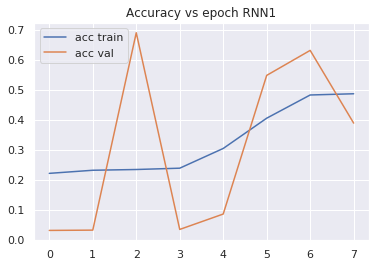


------ Training ------
Accuracy rnn1 : 0.5086288045183558
F1-score None rnn1 : [0.51316571 0.04046243 0.07407407 0.73642955]
F1-score macro rnn1 : 0.3410329407061371

------ Validation ------
Accuracy rnn1 : 0.3901176470588235
F1-score None rnn1 : [0.43279709 0.07630522 0.05755396 0.69780744]
F1-score macro rnn1 : 0.31611592682486384

------ Testing ------
Accuracy rnn1 : 0.30617051342439944
F1-score None rnn1 : [0.34729316 0.13053263 0.28301887 0.5588697 ]
F1-score macro rnn1 : 0.32992858977289574


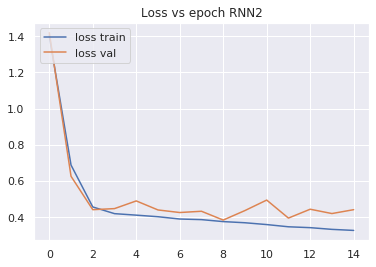

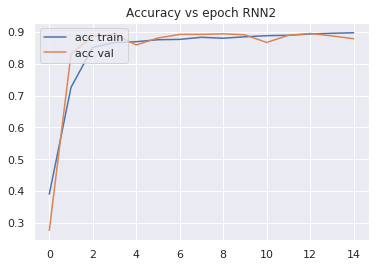


------ Training ------
Accuracy rnn2 : 0.8994352055224349
F1-score None rnn2 : [0.92072286 0.         0.05128205 0.89034565]
F1-score macro rnn2 : 0.4655876401614799

------ Validation ------
Accuracy rnn2 : 0.8785882352941177
F1-score None rnn2 : [0.92508766 0.         0.         0.8278607 ]
F1-score macro rnn2 : 0.4382370899725155

------ Testing ------
Accuracy rnn2 : 0.8450306170513424
F1-score None rnn2 : [0.90992279 0.         0.05128205 0.71150442]
F1-score macro rnn2 : 0.4181773167561239


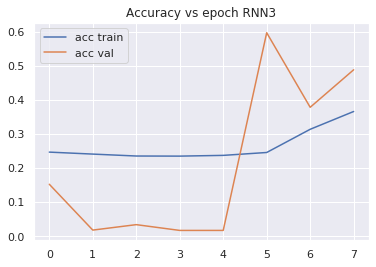


------ Training ------
Accuracy rnn3 : 0.43865704424223406
F1-score None rnn3 : [0.68930498 0.05673759 0.057844   0.32188065]
F1-score macro rnn3 : 0.2814418046716461

------ Validation ------
Accuracy rnn3 : 0.4884705882352941
F1-score None rnn3 : [0.71841584 0.07518797 0.05521472 0.29080119]
F1-score macro rnn3 : 0.28490493059474276

------ Testing ------
Accuracy rnn3 : 0.5402731983042864
F1-score None rnn3 : [0.71460507 0.11940299 0.15655577 0.45048544]
F1-score macro rnn3 : 0.36026231550651083

Entrenando exec  4 



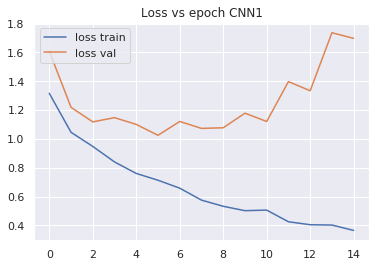

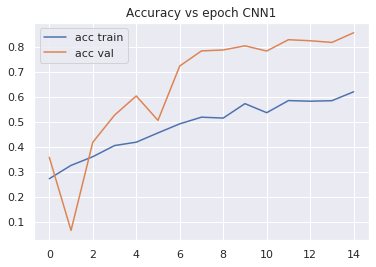


------ Training ------
Accuracy cnn1 : 0.8415437715720113
F1-score None cnn1 : [0.88793219 0.31055901 0.62068966 0.81344677]
F1-score macro cnn1 : 0.6581569072104635

------ Validation ------
Accuracy cnn1 : 0.8555294117647059
F1-score None cnn1 : [0.92292809 0.12403101 0.03921569 0.78018576]
F1-score macro cnn1 : 0.4665901350635051

------ Testing ------
Accuracy cnn1 : 0.8200659444182761
F1-score None cnn1 : [0.90352397 0.19101124 0.05128205 0.59848485]
F1-score macro cnn1 : 0.4360755275757807


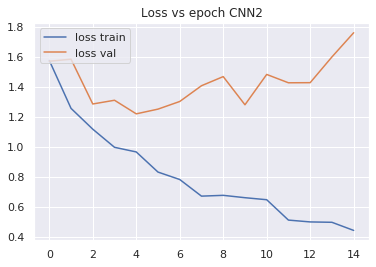

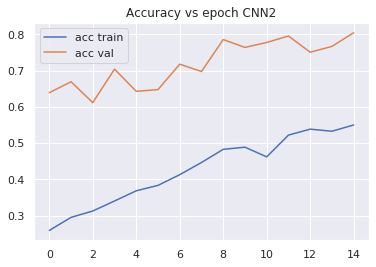


------ Training ------
Accuracy cnn2 : 0.7494508942579228
F1-score None cnn2 : [0.8530572  0.69565217 0.16925734 0.62303399]
F1-score macro cnn2 : 0.5852501765657229

------ Validation ------
Accuracy cnn2 : 0.804235294117647
F1-score None cnn2 : [0.89929165 0.02631579 0.07575758 0.61132075]
F1-score macro cnn2 : 0.4031714434456374

------ Testing ------
Accuracy cnn2 : 0.7795572303344324
F1-score None cnn2 : [0.88370802 0.03636364 0.15384615 0.25310174]
F1-score macro cnn2 : 0.331754887069007


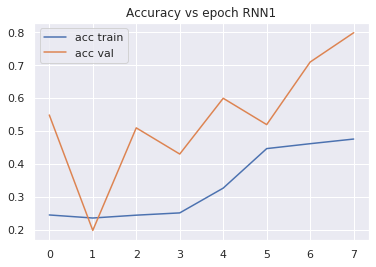


------ Training ------
Accuracy rnn1 : 0.7659240665202385
F1-score None rnn1 : [0.84505001 0.0647482  0.09469697 0.76660718]
F1-score macro rnn1 : 0.44277558916253756

------ Validation ------
Accuracy rnn1 : 0.7985882352941176
F1-score None rnn1 : [0.89777778 0.08053691 0.04255319 0.72463768]
F1-score macro rnn1 : 0.4363763907945594

------ Testing ------
Accuracy rnn1 : 0.802637776731041
F1-score None rnn1 : [0.89854173 0.10679612 0.192      0.6734104 ]
F1-score macro rnn1 : 0.4676870631088421


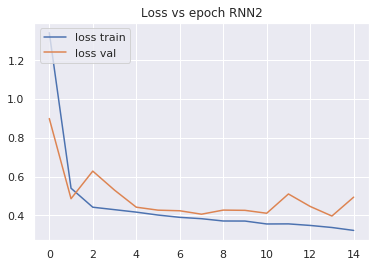

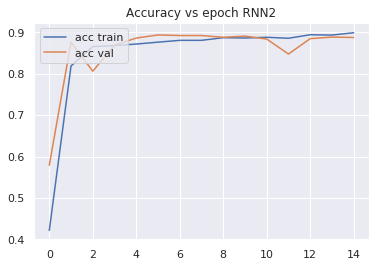


------ Training ------
Accuracy rnn2 : 0.9137119548164417
F1-score None rnn2 : [0.93160507 0.         0.         0.91183597]
F1-score macro rnn2 : 0.4608602620917892

------ Validation ------
Accuracy rnn2 : 0.8875294117647059
F1-score None rnn2 : [0.93328952 0.         0.         0.84727273]
F1-score macro rnn2 : 0.44514056104920385

------ Testing ------
Accuracy rnn2 : 0.8676401318888366
F1-score None rnn2 : [0.92674316 0.         0.         0.80300752]
F1-score macro rnn2 : 0.4324376696374652


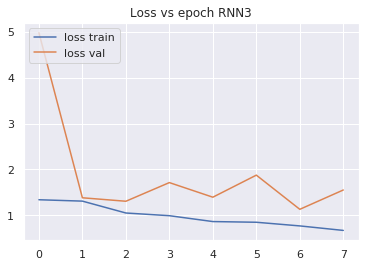

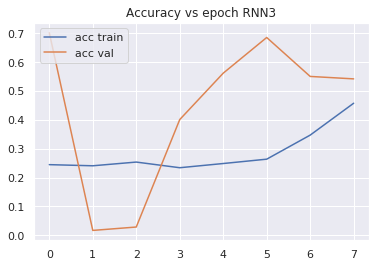


------ Training ------
Accuracy rnn3 : 0.43520552243489175
F1-score None rnn3 : [0.66937754 0.04434072 0.06717985 0.34132669]
F1-score macro rnn3 : 0.28055620011250676

------ Validation ------
Accuracy rnn3 : 0.5425882352941176
F1-score None rnn3 : [0.75218216 0.09019608 0.07589286 0.37138508]
F1-score macro rnn3 : 0.32241404561898407

------ Testing ------
Accuracy rnn3 : 0.5708902496467263
F1-score None rnn3 : [0.74418605 0.1440536  0.171875   0.37470726]
F1-score macro rnn3 : 0.35870547695120575

Entrenando exec  5 



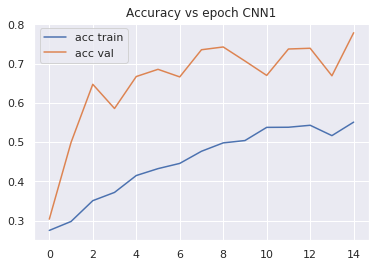


------ Training ------
Accuracy cnn1 : 0.7483526827737684
F1-score None cnn1 : [0.85992116 0.25427873 0.19543974 0.67363305]
F1-score macro cnn1 : 0.4958181685527428

------ Validation ------
Accuracy cnn1 : 0.7783529411764706
F1-score None cnn1 : [0.8890331  0.1928934  0.08974359 0.63312883]
F1-score macro cnn1 : 0.45119973012681214

------ Testing ------
Accuracy cnn1 : 0.7428167687235044
F1-score None cnn1 : [0.8646417  0.18666667 0.2189781  0.32535885]
F1-score macro cnn1 : 0.39891132978626676


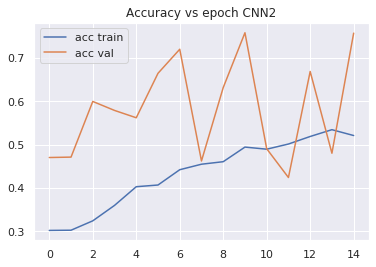


------ Training ------
Accuracy cnn2 : 0.7176027612174459
F1-score None cnn2 : [0.84648815 0.15536723 0.17948718 0.68347206]
F1-score macro cnn2 : 0.4662036554631371

------ Validation ------
Accuracy cnn2 : 0.7576470588235295
F1-score None cnn2 : [0.88109029 0.17777778 0.08053691 0.66509988]
F1-score macro cnn2 : 0.4511262156572049

------ Testing ------
Accuracy cnn2 : 0.6924163918982572
F1-score None cnn2 : [0.84503397 0.22767075 0.15714286 0.3963964 ]
F1-score macro cnn2 : 0.4065609940482955


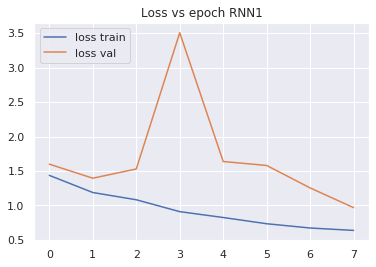

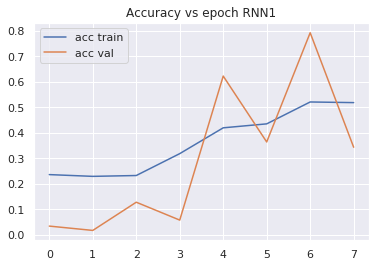


------ Training ------
Accuracy rnn1 : 0.2834954502667085
F1-score None rnn1 : [0.60966959 0.02601969 0.04533189 0.0705271 ]
F1-score macro rnn1 : 0.18788706831112156

------ Validation ------
Accuracy rnn1 : 0.34305882352941175
F1-score None rnn1 : [0.59898006 0.09450172 0.05729167 0.06238532]
F1-score macro rnn1 : 0.20328969272140077

------ Testing ------
Accuracy rnn1 : 0.36363636363636365
F1-score None rnn1 : [0.57481351 0.12104152 0.17708333 0.07909605]
F1-score macro rnn1 : 0.23800860332170032


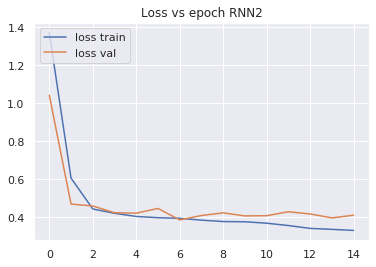

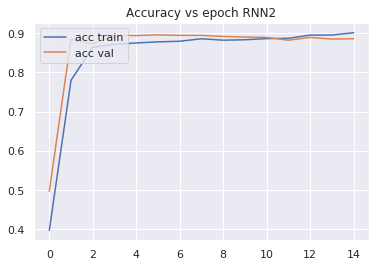


------ Training ------
Accuracy rnn2 : 0.9163790398493882
F1-score None rnn2 : [0.93331489 0.         0.         0.91593988]
F1-score macro rnn2 : 0.46231369102014874

------ Validation ------
Accuracy rnn2 : 0.8861176470588236
F1-score None rnn2 : [0.93087558 0.         0.         0.84886878]
F1-score macro rnn2 : 0.44493608857935235

------ Testing ------
Accuracy rnn2 : 0.8605746585021197
F1-score None rnn2 : [0.92148148 0.         0.         0.78955007]
F1-score macro rnn2 : 0.4277578885126055


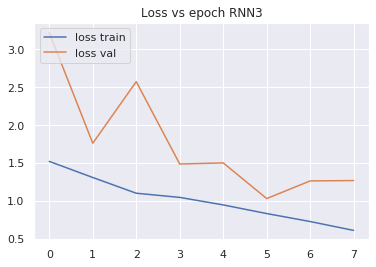

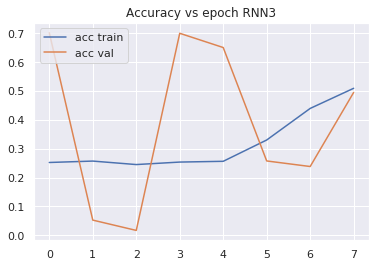


------ Training ------
Accuracy rnn3 : 0.4998431126451208
F1-score None rnn3 : [0.70615875 0.0964467  0.05565217 0.5295866 ]
F1-score macro rnn3 : 0.3469610560264308

------ Validation ------
Accuracy rnn3 : 0.4955294117647059
F1-score None rnn3 : [0.69429175 0.08542714 0.06970509 0.51012146]
F1-score macro rnn3 : 0.3398863604397304

------ Testing ------
Accuracy rnn3 : 0.49317004239284035
F1-score None rnn3 : [0.65921788 0.15855856 0.17366947 0.48832272]
F1-score macro rnn3 : 0.3699421552656816


In [13]:
fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

for i in range(1,6):    
    print ("\nEntrenando exec ", i,"\n")
    cnn1=create_ccn1(x_train.shape[1:])
    trained, hist =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=15, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/cnn1_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch CNN1")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch CNN1")
    plt.show()
    
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, n_labels, n_labels_val, n_labels_test, 'cnn1')
    fs_macro['cnn1'].append(f1_ma_t)
    fs_none['cnn1'].append(f1_t)
    accs['cnn1'].append(acc_t)
    confusions['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    trained, hist =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=15, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/cnn2_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch CNN2")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch CNN2")
    plt.show()
    
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'cnn2')
    fs_macro['cnn2'].append(f1_ma_t)
    fs_none['cnn2'].append(f1_t)
    accs['cnn2'].append(acc_t)
    confusions['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn1_'+str(i)+'-exec_8.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN1")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN1")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn1')
    fs_macro['rnn1'].append(f1_ma_t)
    fs_none['rnn1'].append(f1_t)
    accs['rnn1'].append(acc_t)
    confusions['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=15, BS=32, verb=0, focal=False)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn2_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN2")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN2")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn2')
    fs_macro['rnn2'].append(f1_ma_t)
    fs_none['rnn2'].append(f1_t)
    accs['rnn2'].append(acc_t)
    confusions['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn3_'+str(i)+'-exec_8.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN3")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN3")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn3')
    fs_macro['rnn3'].append(f1_ma_t)
    fs_none['rnn3'].append(f1_t)
    accs['rnn3'].append(acc_t)
    confusions['rnn3'].append(matriz_t)


In [14]:
for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("Original - F1-score promedio para",key,":" ,temp/5)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("Original - F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("Original - Accuracy promedio para",key,":" ,temp/5)

Original - F1-score promedio para cnn1 : [0.87196646 0.19344025 0.12159133 0.46917076]
Original - F1-score promedio para cnn2 : [0.83349127 0.16205462 0.18525232 0.25332429]
Original - F1-score promedio para rnn1 : [0.68635373 0.16514098 0.19262119 0.47077015]
Original - F1-score promedio para rnn2 : [0.91918419 0.         0.01538462 0.76513005]
Original - F1-score promedio para rnn3 : [0.61537754 0.12982604 0.17471758 0.47788294]

Original - F1-score macro promedio para cnn1 : 0.41404219998364156 desvest:  0.020651561447023285
Original - F1-score macro promedio para cnn2 : 0.3585306277711663 desvest:  0.028137321619272983
Original - F1-score macro promedio para rnn1 : 0.3787215111614897 desvest:  0.08494099460525523
Original - F1-score macro promedio para rnn2 : 0.42492471389835307 desvest:  0.007775775628586255
Original - F1-score macro promedio para rnn3 : 0.34945102521931914 desvest:  0.050332503442555875

Original - Accuracy promedio para cnn1 : 0.7531794630240226
Original - Accur

### Aumento no Ponderado - Clase

In [15]:
macro_augmented = np.load('../Datasets/CSV_Harassment/balance_clase_noPon_GloVe.npy', allow_pickle=True)
np.random.shuffle(macro_augmented)

ids_train=macro_augmented[:,0]
tws_train=macro_augmented[:,1]
labels_train=macro_augmented[:,2]
class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
print ("Pesos de clases:", class_weights)

sentences = tws_train
n_labels = labels_train.copy()

input_ids = []
for sent in sentences:
    encoded_sent = [] 
    for wd in sent:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids.append(encoded_sent)

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")
y_train=to_categorical(n_labels,num_classes=4)
shape=np.asarray(input_ids).shape
x_train=np.zeros((shape[0], shape[1], emb))
j=0
for in_id in input_ids:
    x_train[j]=EMB_matrix[in_id]
    j+=1

Pesos de clases: [1. 1. 1. 1.]



Entrenando exec  1 



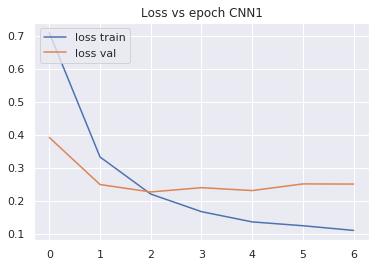

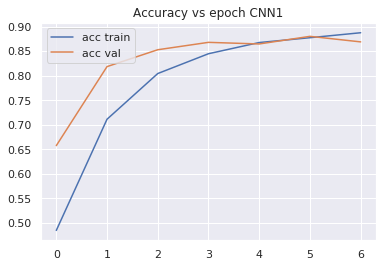


------ Training ------
Accuracy cnn1 : 0.9338295547664572
F1-score None cnn1 : [0.8796189  0.99549734 0.99536026 0.86363636]
F1-score macro cnn1 : 0.9335282163645882

------ Validation ------
Accuracy cnn1 : 0.8687058823529412
F1-score None cnn1 : [0.91907331 0.11627907 0.09756098 0.80452675]
F1-score macro cnn1 : 0.48436002610217244

------ Testing ------
Accuracy cnn1 : 0.8346679227508244
F1-score None cnn1 : [0.90389016 0.15384615 0.02564103 0.66789668]
F1-score macro cnn1 : 0.43781850465925887


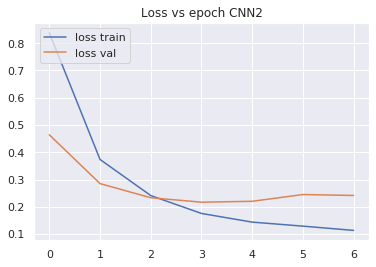

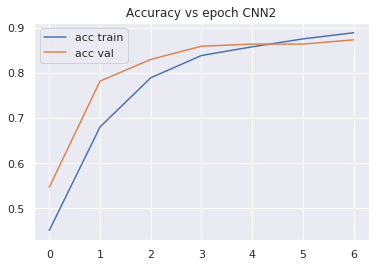


------ Training ------
Accuracy cnn2 : 0.9501502321770008
F1-score None cnn2 : [0.90206548 0.99632303 0.99577484 0.90588706]
F1-score macro cnn2 : 0.9500126025229652

------ Validation ------
Accuracy cnn2 : 0.8729411764705882
F1-score None cnn2 : [0.92461641 0.09090909 0.09090909 0.82678571]
F1-score macro cnn2 : 0.48330507676113077

------ Testing ------
Accuracy cnn2 : 0.8539802166745172
F1-score None cnn2 : [0.91924712 0.12121212 0.09411765 0.78095238]
F1-score macro cnn2 : 0.4788823162979383


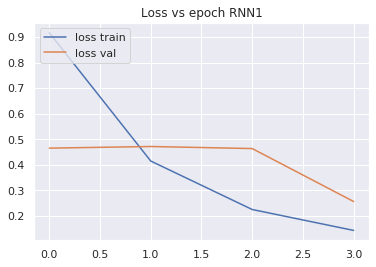

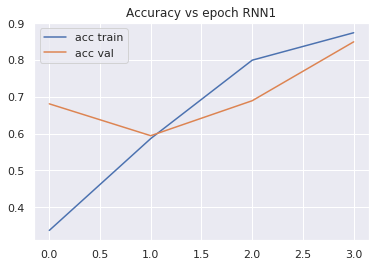


------ Training ------
Accuracy rnn1 : 0.9192843485386506
F1-score None rnn1 : [0.87137166 0.98012708 0.9556809  0.86746663]
F1-score macro rnn1 : 0.9186615669971955

------ Validation ------
Accuracy rnn1 : 0.8494117647058823
F1-score None rnn1 : [0.91811077 0.1969697  0.04123711 0.81447124]
F1-score macro rnn1 : 0.49269720618405277

------ Testing ------
Accuracy rnn1 : 0.8200659444182761
F1-score None rnn1 : [0.90147783 0.20754717 0.30601093 0.75290216]
F1-score macro rnn1 : 0.5419845217931537


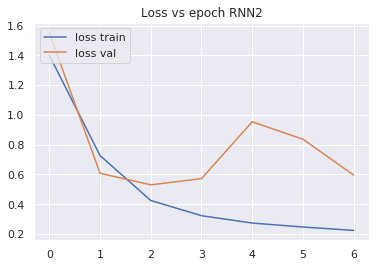

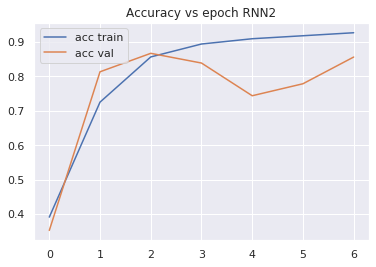


------ Training ------
Accuracy rnn2 : 0.9468724392242557
F1-score None rnn2 : [0.90220732 0.99208083 0.986512   0.90557359]
F1-score macro rnn2 : 0.9465934370044484

------ Validation ------
Accuracy rnn2 : 0.8564705882352941
F1-score None rnn2 : [0.92032411 0.09708738 0.0625     0.82460973]
F1-score macro rnn2 : 0.47613030441891324

------ Testing ------
Accuracy rnn2 : 0.8374941121055111
F1-score None rnn2 : [0.90965156 0.1192053  0.18300654 0.80114449]
F1-score macro rnn2 : 0.5032519708231743


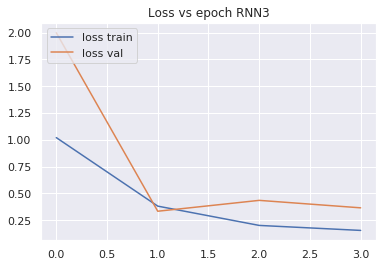

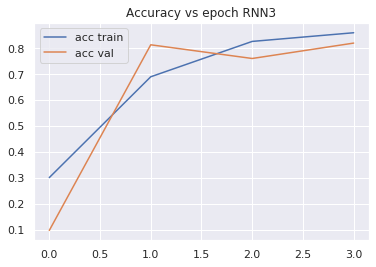


------ Training ------
Accuracy rnn3 : 0.8966129472821633
F1-score None rnn3 : [0.85978726 0.97493188 0.92538071 0.818275  ]
F1-score macro rnn3 : 0.8945937144659811

------ Validation ------
Accuracy rnn3 : 0.819764705882353
F1-score None rnn3 : [0.90958717 0.18181818 0.10628019 0.78102926]
F1-score macro rnn3 : 0.49467870250975343

------ Testing ------
Accuracy rnn3 : 0.8054639660857278
F1-score None rnn3 : [0.90130354 0.17582418 0.20909091 0.70418006]
F1-score macro rnn3 : 0.4975996718497033

Entrenando exec  2 



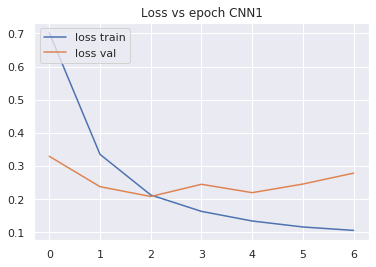

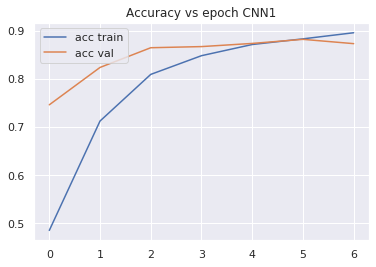


------ Training ------
Accuracy cnn1 : 0.9500136574706365
F1-score None cnn1 : [0.90256554 0.99454744 0.99576561 0.90690851]
F1-score macro cnn1 : 0.9499467731171547

------ Validation ------
Accuracy cnn1 : 0.8734117647058823
F1-score None cnn1 : [0.92595063 0.         0.1        0.81898067]
F1-score macro cnn1 : 0.46123282539853755

------ Testing ------
Accuracy cnn1 : 0.844559585492228
F1-score None cnn1 : [0.91407899 0.03333333 0.02597403 0.74863388]
F1-score macro cnn1 : 0.43050505653131466


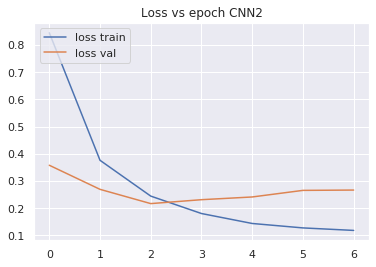

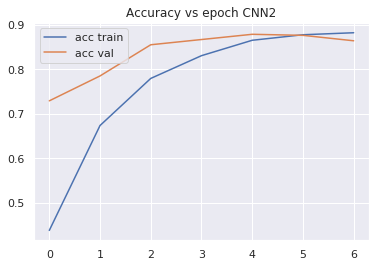


------ Training ------
Accuracy cnn2 : 0.9265910953291451
F1-score None cnn2 : [0.86880907 0.99686349 0.99522575 0.84287636]
F1-score macro cnn2 : 0.9259436713370164

------ Validation ------
Accuracy cnn2 : 0.8644705882352941
F1-score None cnn2 : [0.91711314 0.02564103 0.09756098 0.79123173]
F1-score macro cnn2 : 0.4578867190410447

------ Testing ------
Accuracy cnn2 : 0.826189354686764
F1-score None cnn2 : [0.898641   0.06837607 0.02597403 0.62307692]
F1-score macro cnn2 : 0.40401700350737724


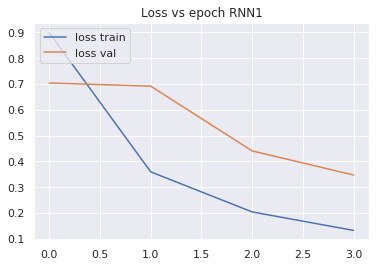

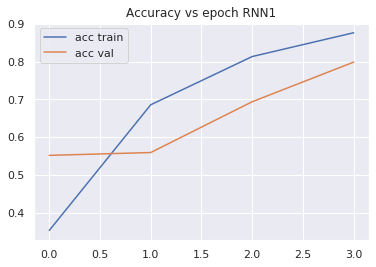


------ Training ------
Accuracy rnn1 : 0.8891013384321224
F1-score None rnn1 : [0.80341099 0.94772922 0.97147492 0.83417448]
F1-score macro rnn1 : 0.8891974035358645

------ Validation ------
Accuracy rnn1 : 0.7985882352941176
F1-score None rnn1 : [0.87586458 0.04878049 0.05333333 0.72808321]
F1-score macro rnn1 : 0.4265154025472969

------ Testing ------
Accuracy rnn1 : 0.7630711257654262
F1-score None rnn1 : [0.86635007 0.10687023 0.18181818 0.62141491]
F1-score macro rnn1 : 0.4441133481565889


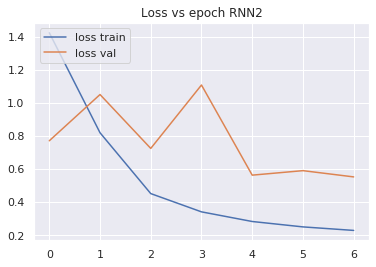

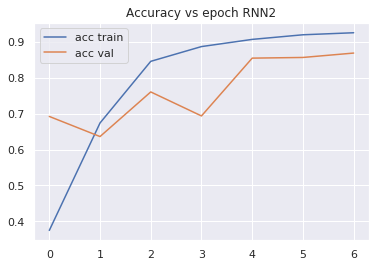


------ Training ------
Accuracy rnn2 : 0.9273422562141491
F1-score None rnn2 : [0.8833932  0.98512806 0.95657094 0.88742065]
F1-score macro rnn2 : 0.928128215084016

------ Validation ------
Accuracy rnn2 : 0.8687058823529412
F1-score None rnn2 : [0.92307692 0.08421053 0.         0.83012259]
F1-score macro rnn2 : 0.4593525103341676

------ Testing ------
Accuracy rnn2 : 0.8473857748469148
F1-score None rnn2 : [0.91336181 0.1625     0.11235955 0.78998609]
F1-score macro rnn2 : 0.49455186208380303


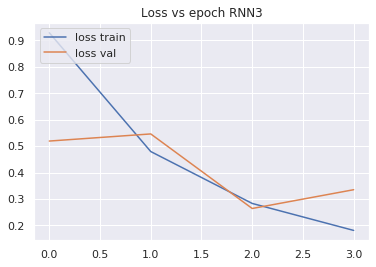

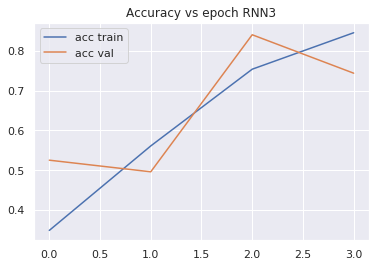


------ Training ------
Accuracy rnn3 : 0.8862332695984704
F1-score None rnn3 : [0.81499845 0.93120613 0.93174431 0.85620486]
F1-score macro rnn3 : 0.8835384369466596

------ Validation ------
Accuracy rnn3 : 0.7435294117647059
F1-score None rnn3 : [0.83038736 0.16524217 0.0877193  0.78507993]
F1-score macro rnn3 : 0.46710718902759363

------ Testing ------
Accuracy rnn3 : 0.7023080546396608
F1-score None rnn3 : [0.81298518 0.23001949 0.24581006 0.71666667]
F1-score macro rnn3 : 0.5013703489169083

Entrenando exec  3 



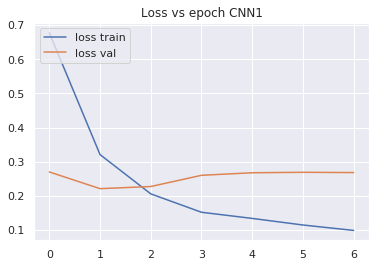

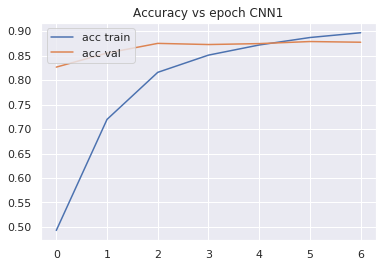


------ Training ------
Accuracy cnn1 : 0.9412045889101338
F1-score None cnn1 : [0.89257294 0.99632203 0.99301848 0.88256829]
F1-score macro cnn1 : 0.9411204355960143

------ Validation ------
Accuracy cnn1 : 0.8771764705882353
F1-score None cnn1 : [0.9285021  0.04938272 0.04878049 0.82160077]
F1-score macro cnn1 : 0.46206651954742783

------ Testing ------
Accuracy cnn1 : 0.8431464908148846
F1-score None cnn1 : [0.91068301 0.06299213 0.07142857 0.73234811]
F1-score macro cnn1 : 0.4443629553326186


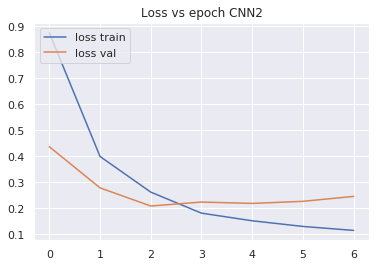

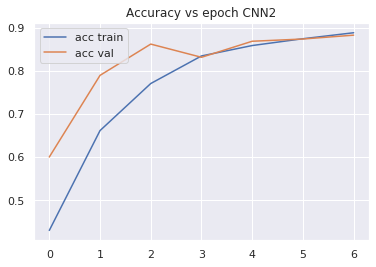


------ Training ------
Accuracy cnn2 : 0.9403851406719476
F1-score None cnn2 : [0.8896259  0.99645583 0.99356429 0.88173253]
F1-score macro cnn2 : 0.9403446363560793

------ Validation ------
Accuracy cnn2 : 0.8823529411764706
F1-score None cnn2 : [0.9303675  0.02597403 0.05       0.83414161]
F1-score macro cnn2 : 0.4601207852242275

------ Testing ------
Accuracy cnn2 : 0.8516250588789449
F1-score None cnn2 : [0.91352293 0.06504065 0.02597403 0.76333333]
F1-score macro cnn2 : 0.4419677337111124


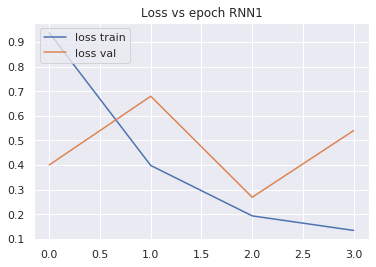

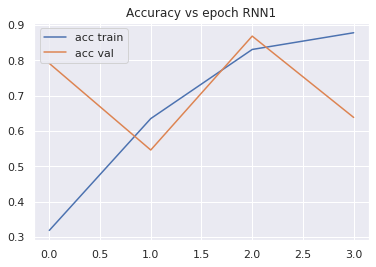


------ Training ------
Accuracy rnn1 : 0.8322179732313576
F1-score None rnn1 : [0.72290355 0.8475165  0.93417287 0.80796959]
F1-score macro rnn1 : 0.8281406257126224

------ Validation ------
Accuracy rnn1 : 0.6381176470588236
F1-score None rnn1 : [0.74309278 0.13355593 0.03636364 0.70708796]
F1-score macro rnn1 : 0.40502507635560625

------ Testing ------
Accuracy rnn1 : 0.5925577013659915
F1-score None rnn1 : [0.7244582  0.18810512 0.15533981 0.58851675]
F1-score macro rnn1 : 0.4141049685341974


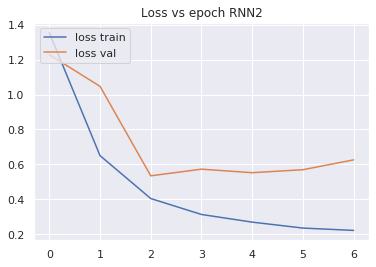

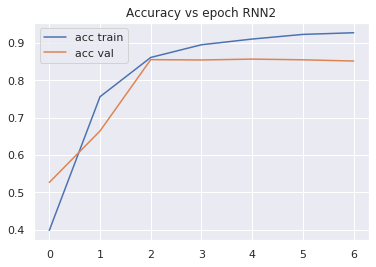


------ Training ------
Accuracy rnn2 : 0.9369024856596558
F1-score None rnn2 : [0.89974511 0.99212812 0.96660066 0.88617328]
F1-score macro rnn2 : 0.93616179415325

------ Validation ------
Accuracy rnn2 : 0.8512941176470589
F1-score None rnn2 : [0.92391304 0.12612613 0.11023622 0.81460674]
F1-score macro rnn2 : 0.4937205329124654

------ Testing ------
Accuracy rnn2 : 0.832312764955252
F1-score None rnn2 : [0.90897756 0.22222222 0.3027027  0.78313253]
F1-score macro rnn2 : 0.5542587527887831


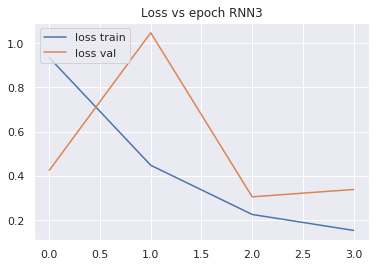

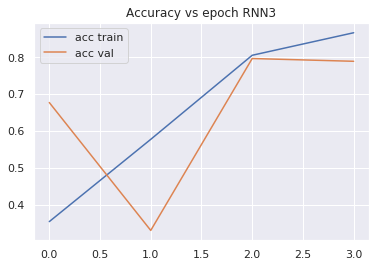


------ Training ------
Accuracy rnn3 : 0.8964080852226167
F1-score None rnn3 : [0.84624311 0.97181782 0.91740116 0.84106246]
F1-score macro rnn3 : 0.8941311352580744

------ Validation ------
Accuracy rnn3 : 0.7891764705882353
F1-score None rnn3 : [0.88638762 0.1910828  0.08547009 0.77165354]
F1-score macro rnn3 : 0.48364851250939256

------ Testing ------
Accuracy rnn3 : 0.7706076307112577
F1-score None rnn3 : [0.86902827 0.26717557 0.29333333 0.72487644]
F1-score macro rnn3 : 0.5386034054153027

Entrenando exec  4 



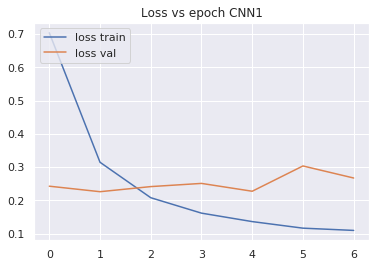

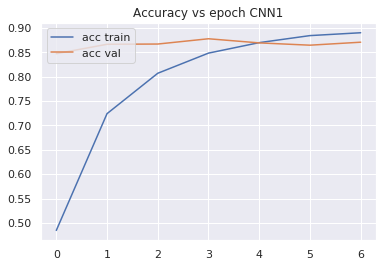


------ Training ------
Accuracy cnn1 : 0.9490576345260857
F1-score None cnn1 : [0.90185676 0.99672221 0.99348711 0.90353828]
F1-score macro cnn1 : 0.9489010890342462

------ Validation ------
Accuracy cnn1 : 0.8705882352941177
F1-score None cnn1 : [0.92619681 0.02739726 0.08695652 0.82363636]
F1-score macro cnn1 : 0.46604673854002626

------ Testing ------
Accuracy cnn1 : 0.8615167216203485
F1-score None cnn1 : [0.92284418 0.03539823 0.27272727 0.7994429 ]
F1-score macro cnn1 : 0.5076031438108451


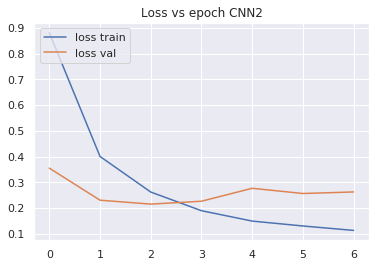

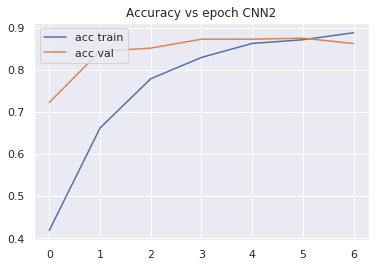


------ Training ------
Accuracy cnn2 : 0.9261130838568697
F1-score None cnn2 : [0.86825217 0.99659354 0.99536153 0.84142686]
F1-score macro cnn2 : 0.9254085246163204

------ Validation ------
Accuracy cnn2 : 0.8621176470588235
F1-score None cnn2 : [0.91516872 0.02564103 0.09756098 0.7875    ]
F1-score macro cnn2 : 0.4564676794360004

------ Testing ------
Accuracy cnn2 : 0.8115873763542157
F1-score None cnn2 : [0.89194499 0.09677419 0.05128205 0.52390852]
F1-score macro cnn2 : 0.3909774397289449


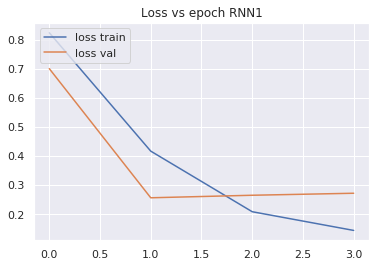

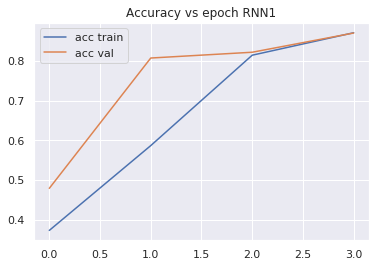


------ Training ------
Accuracy rnn1 : 0.8713466266047528
F1-score None rnn1 : [0.80455868 0.92157434 0.93485714 0.83816156]
F1-score macro rnn1 : 0.8747879319153459

------ Validation ------
Accuracy rnn1 : 0.8701176470588236
F1-score None rnn1 : [0.92287918 0.06976744 0.03773585 0.81881882]
F1-score macro rnn1 : 0.46230032177844493

------ Testing ------
Accuracy rnn1 : 0.8351389543099388
F1-score None rnn1 : [0.90528129 0.11764706 0.24489796 0.66666667]
F1-score macro rnn1 : 0.4836232426380426


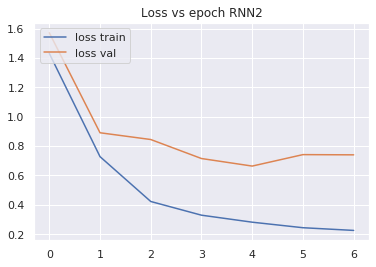

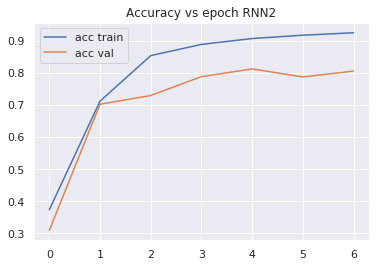


------ Training ------
Accuracy rnn2 : 0.9238596012018574
F1-score None rnn2 : [0.84980237 0.98541953 0.98326134 0.87400398]
F1-score macro rnn2 : 0.9231218067556852

------ Validation ------
Accuracy rnn2 : 0.8061176470588235
F1-score None rnn2 : [0.88124547 0.09195402 0.04       0.75326672]
F1-score macro rnn2 : 0.44161655379794906

------ Testing ------
Accuracy rnn2 : 0.743287800282619
F1-score None rnn2 : [0.8502052  0.11428571 0.16455696 0.61328125]
F1-score macro rnn2 : 0.4355822811673611


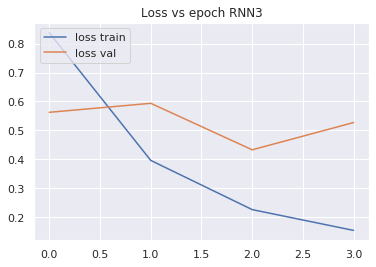

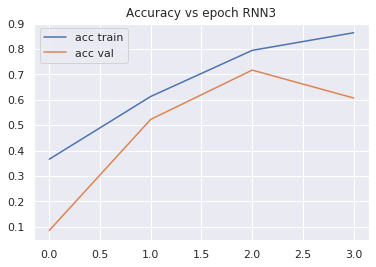


------ Training ------
Accuracy rnn3 : 0.8248429390876809
F1-score None rnn3 : [0.72404731 0.82099112 0.92688543 0.81653747]
F1-score macro rnn3 : 0.8221153327829607

------ Validation ------
Accuracy rnn3 : 0.6070588235294118
F1-score None rnn3 : [0.70910624 0.12658228 0.03278689 0.77507303]
F1-score macro rnn3 : 0.4108871078562176

------ Testing ------
Accuracy rnn3 : 0.5501648610456901
F1-score None rnn3 : [0.68036349 0.1749503  0.18518519 0.69550749]
F1-score macro rnn3 : 0.4340016159018389

Entrenando exec  5 



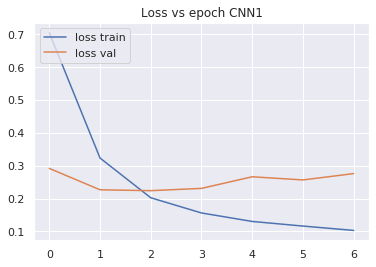

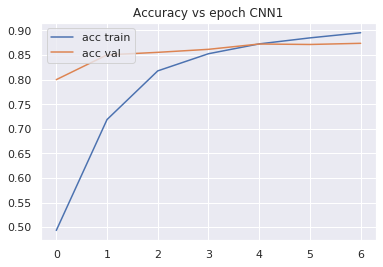


------ Training ------
Accuracy cnn1 : 0.9448921059819722
F1-score None cnn1 : [0.89683377 0.99700191 0.99727372 0.88768837]
F1-score macro cnn1 : 0.9446994425955462

------ Validation ------
Accuracy cnn1 : 0.8738823529411764
F1-score None cnn1 : [0.92352185 0.05263158 0.05       0.81604697]
F1-score macro cnn1 : 0.46055009914475237

------ Testing ------
Accuracy cnn1 : 0.8403203014601979
F1-score None cnn1 : [0.90882945 0.01754386 0.02597403 0.69896194]
F1-score macro cnn1 : 0.4128273185038205


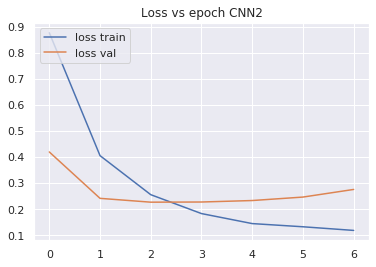

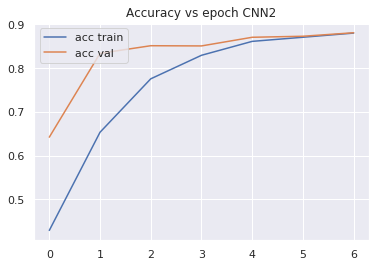


------ Training ------
Accuracy cnn2 : 0.9425020486205955
F1-score None cnn2 : [0.89285239 0.99686435 0.99398414 0.88605108]
F1-score macro cnn2 : 0.9424379896898056

------ Validation ------
Accuracy cnn2 : 0.8809411764705882
F1-score None cnn2 : [0.92852543 0.         0.04878049 0.83463035]
F1-score macro cnn2 : 0.45298406816051445

------ Testing ------
Accuracy cnn2 : 0.8459726801695714
F1-score None cnn2 : [0.91097666 0.         0.02597403 0.73037543]
F1-score macro cnn2 : 0.4168315290952097


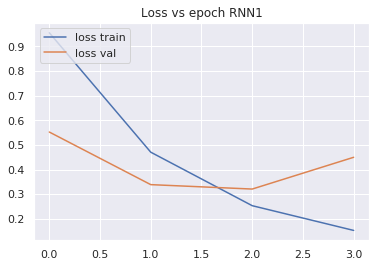

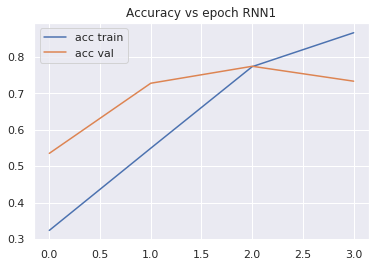


------ Training ------
Accuracy rnn1 : 0.8260038240917782
F1-score None rnn1 : [0.8277635  0.94812518 0.80346757 0.71524922]
F1-score macro rnn1 : 0.8236513661915907

------ Validation ------
Accuracy rnn1 : 0.7331764705882353
F1-score None rnn1 : [0.87957746 0.11111111 0.08656036 0.65816918]
F1-score macro rnn1 : 0.4338545294132661

------ Testing ------
Accuracy rnn1 : 0.7235044747998116
F1-score None rnn1 : [0.85899514 0.30851064 0.20816327 0.54244306]
F1-score macro rnn1 : 0.47952802638739017


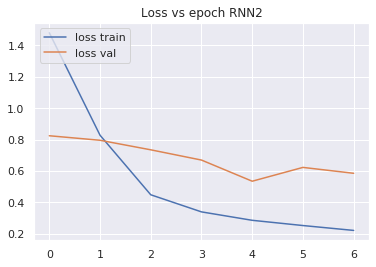

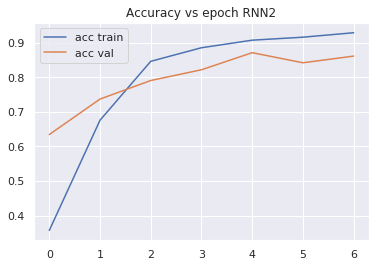


------ Training ------
Accuracy rnn2 : 0.9403168533187654
F1-score None rnn2 : [0.90066778 0.98984153 0.97790277 0.89048276]
F1-score macro rnn2 : 0.9397237095713236

------ Validation ------
Accuracy rnn2 : 0.8611764705882353
F1-score None rnn2 : [0.92663317 0.20967742 0.04597701 0.81973435]
F1-score macro rnn2 : 0.5005054855073203

------ Testing ------
Accuracy rnn2 : 0.8412623645784267
F1-score None rnn2 : [0.91412911 0.2371134  0.24460432 0.77901431]
F1-score macro rnn2 : 0.5437152844687825


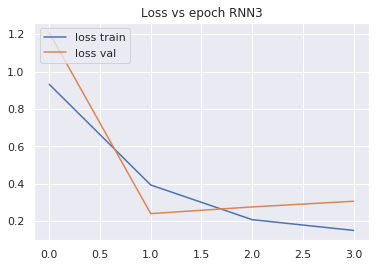

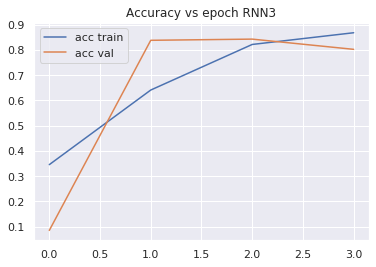


------ Training ------
Accuracy rnn3 : 0.8798825457525267
F1-score None rnn3 : [0.83812193 0.93340151 0.92905272 0.80698122]
F1-score macro rnn3 : 0.8768893433296416

------ Validation ------
Accuracy rnn3 : 0.8023529411764706
F1-score None rnn3 : [0.89862069 0.17898833 0.03703704 0.76548223]
F1-score macro rnn3 : 0.4700320717607491

------ Testing ------
Accuracy rnn3 : 0.7762600094206312
F1-score None rnn3 : [0.87496063 0.25925926 0.18644068 0.69217391]
F1-score macro rnn3 : 0.5032086200475248


In [16]:
fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

for i in range(1,6):    
    print ("\nEntrenando exec ", i,"\n")
    cnn1=create_ccn1(x_train.shape[1:])
    trained, hist =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=7, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/cnn1_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch CNN1")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch CNN1")
    plt.show()
    
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, n_labels, n_labels_val, n_labels_test, 'cnn1')
    fs_macro['cnn1'].append(f1_ma_t)
    fs_none['cnn1'].append(f1_t)
    accs['cnn1'].append(acc_t)
    confusions['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    trained, hist =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=7, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/cnn2_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch CNN2")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch CNN2")
    plt.show()
    
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'cnn2')
    fs_macro['cnn2'].append(f1_ma_t)
    fs_none['cnn2'].append(f1_t)
    accs['cnn2'].append(acc_t)
    confusions['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn1_'+str(i)+'-exec_8.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN1")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN1")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn1')
    fs_macro['rnn1'].append(f1_ma_t)
    fs_none['rnn1'].append(f1_t)
    accs['rnn1'].append(acc_t)
    confusions['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=7, BS=32, verb=0, focal=False)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn2_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN2")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN2")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn2')
    fs_macro['rnn2'].append(f1_ma_t)
    fs_none['rnn2'].append(f1_t)
    accs['rnn2'].append(acc_t)
    confusions['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn3_'+str(i)+'-exec_8.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN3")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN3")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn3')
    fs_macro['rnn3'].append(f1_ma_t)
    fs_none['rnn3'].append(f1_t)
    accs['rnn3'].append(acc_t)
    confusions['rnn3'].append(matriz_t)


In [17]:
print ("--------- Usando contexto positivo y negativo obligadamente ---------")

for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("0.15 Clase - F1-score promedio para",key,":" ,temp/5)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("0.15 Clase - F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("0.15 Clase - Accuracy promedio para",key,":" ,temp/5)

--------- Usando contexto positivo y negativo obligadamente ---------
0.15 Clase - F1-score promedio para cnn1 : [0.91206516 0.06062274 0.08434898 0.7294567 ]
0.15 Clase - F1-score promedio para cnn2 : [0.90686654 0.07028061 0.04466436 0.68432932]
0.15 Clase - F1-score promedio para rnn1 : [0.85131251 0.18573604 0.21924603 0.63438871]
0.15 Clase - F1-score promedio para rnn2 : [0.89926505 0.17106533 0.20144601 0.75331173]
0.15 Clase - F1-score promedio para rnn3 : [0.82772822 0.22144576 0.22397203 0.70668091]

0.15 Clase - F1-score macro promedio para cnn1 : 0.44662339576757154 desvest:  0.03225876956104443
0.15 Clase - F1-score macro promedio para cnn2 : 0.42653520446811655 desvest:  0.031125450677081185
0.15 Clase - F1-score macro promedio para rnn1 : 0.4726708215018746 desvest:  0.042934494880814585
0.15 Clase - F1-score macro promedio para rnn2 : 0.5062720302663808 desvest:  0.042067199936906836
0.15 Clase - F1-score macro promedio para rnn3 : 0.49495673242625565 desvest:  0.033872

In [18]:
macro_augmented = np.load('../Datasets/CSV_Harassment/balance_clase_noPon_GloVe_pos.npy', allow_pickle=True)

np.random.shuffle(macro_augmented)

ids_train=macro_augmented[:,0]
tws_train=macro_augmented[:,1]
labels_train=macro_augmented[:,2]
class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
print ("Pesos de clases:", class_weights)

sentences = tws_train
n_labels = labels_train.copy()

input_ids = []
for sent in sentences:
    encoded_sent = [] 
    for wd in sent:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids.append(encoded_sent)

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")
y_train=to_categorical(n_labels,num_classes=4)
shape=np.asarray(input_ids).shape
x_train=np.zeros((shape[0], shape[1], emb))
j=0
for in_id in input_ids:
    x_train[j]=EMB_matrix[in_id]
    j+=1

Pesos de clases: [1. 1. 1. 1.]



Entrenando exec  1 



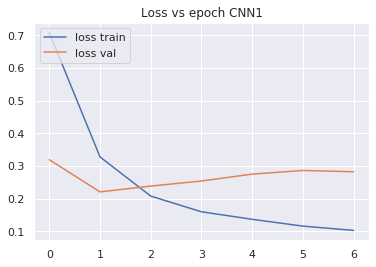

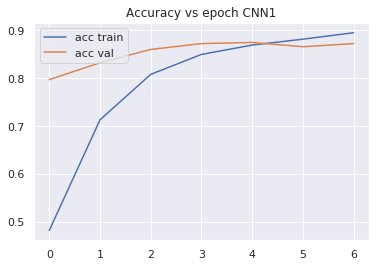


------ Training ------
Accuracy cnn1 : 0.9500819448238186
F1-score None cnn1 : [0.90164164 0.99659168 0.99591169 0.90571581]
F1-score macro cnn1 : 0.9499652081710052

------ Validation ------
Accuracy cnn1 : 0.8724705882352941
F1-score None cnn1 : [0.92668229 0.02564103 0.04444444 0.82105263]
F1-score macro cnn1 : 0.4544550978968543

------ Testing ------
Accuracy cnn1 : 0.8577484691474329
F1-score None cnn1 : [0.92093305 0.08474576 0.0952381  0.78600269]
F1-score macro cnn1 : 0.47172990008268256


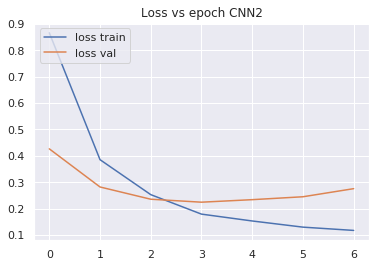

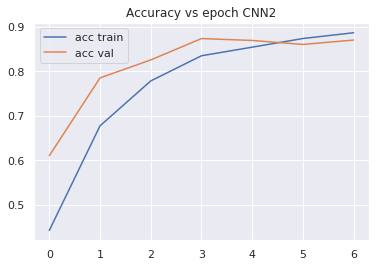


------ Training ------
Accuracy cnn2 : 0.9457798415733406
F1-score None cnn2 : [0.89553081 0.99740897 0.99150219 0.8987576 ]
F1-score macro cnn2 : 0.9457998927312897

------ Validation ------
Accuracy cnn2 : 0.8705882352941177
F1-score None cnn2 : [0.92405487 0.         0.05       0.81675393]
F1-score macro cnn2 : 0.4477021986375874

------ Testing ------
Accuracy cnn2 : 0.8520960904380593
F1-score None cnn2 : [0.91919806 0.03539823 0.09876543 0.76315789]
F1-score macro cnn2 : 0.4541299032042943


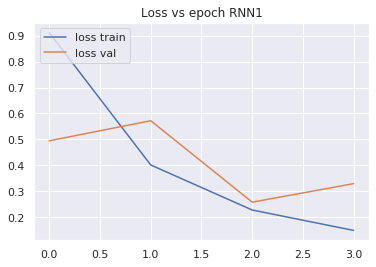

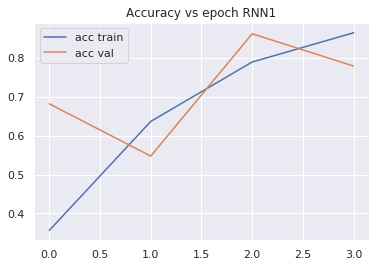


------ Training ------
Accuracy rnn1 : 0.8905353728489483
F1-score None rnn1 : [0.7931254  0.96242228 0.96136179 0.83642126]
F1-score macro rnn1 : 0.8883326815398319

------ Validation ------
Accuracy rnn1 : 0.7783529411764706
F1-score None rnn1 : [0.85756898 0.20930233 0.08421053 0.74096849]
F1-score macro rnn1 : 0.47301257901292537

------ Testing ------
Accuracy rnn1 : 0.7286858219500707
F1-score None rnn1 : [0.82819074 0.23188406 0.26666667 0.64876033]
F1-score macro rnn1 : 0.49387544963855046


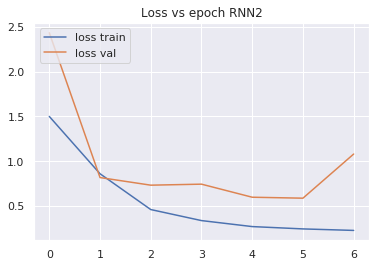

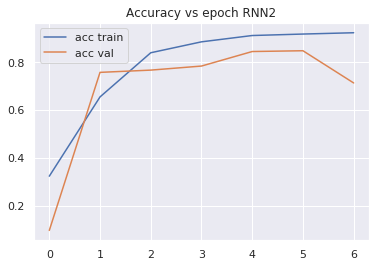


------ Training ------
Accuracy rnn2 : 0.87967768369298
F1-score None rnn2 : [0.83210137 0.93297655 0.91033454 0.82806499]
F1-score macro rnn2 : 0.8758693638530672

------ Validation ------
Accuracy rnn2 : 0.7134117647058823
F1-score None rnn2 : [0.83818046 0.1452514  0.05907173 0.73792395]
F1-score macro rnn2 : 0.44510688387610675

------ Testing ------
Accuracy rnn2 : 0.7079604333490344
F1-score None rnn2 : [0.82834537 0.25157233 0.26470588 0.68813559]
F1-score macro rnn2 : 0.5081897939635798


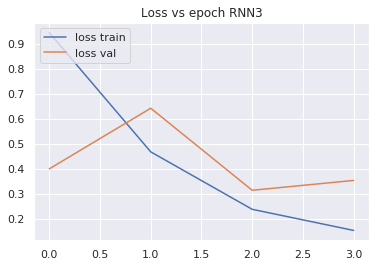

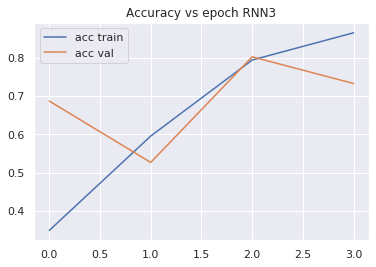


------ Training ------
Accuracy rnn3 : 0.8944960393335154
F1-score None rnn3 : [0.79271216 0.97132858 0.96780202 0.83452882]
F1-score macro rnn3 : 0.8915928942910328

------ Validation ------
Accuracy rnn3 : 0.7322352941176471
F1-score None rnn3 : [0.82434515 0.11764706 0.02040816 0.67854597]
F1-score macro rnn3 : 0.4102365853457655

------ Testing ------
Accuracy rnn3 : 0.6858219500706547
F1-score None rnn3 : [0.79152976 0.27467811 0.3164557  0.56451613]
F1-score macro rnn3 : 0.48679492305198735

Entrenando exec  2 



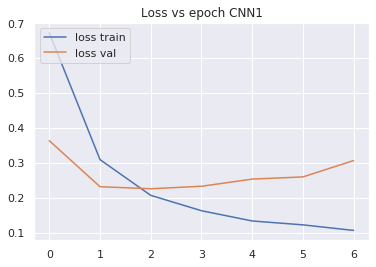

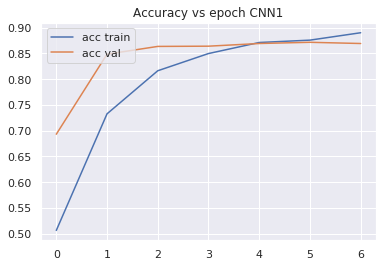


------ Training ------
Accuracy cnn1 : 0.9461212783392515
F1-score None cnn1 : [0.89764888 0.99494052 0.99065677 0.90176455]
F1-score macro cnn1 : 0.9462526806106492

------ Validation ------
Accuracy cnn1 : 0.8691764705882353
F1-score None cnn1 : [0.92271505 0.02666667 0.04878049 0.81519862]
F1-score macro cnn1 : 0.453340206635603

------ Testing ------
Accuracy cnn1 : 0.8492699010833726
F1-score None cnn1 : [0.91817346 0.05454545 0.02597403 0.75628141]
F1-score macro cnn1 : 0.43874358689019644


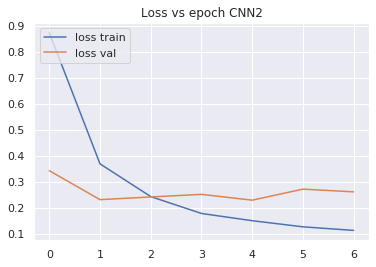

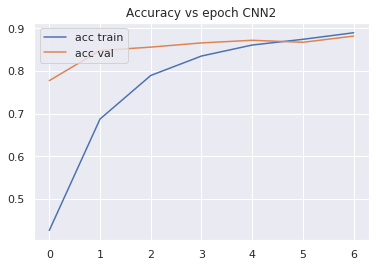


------ Training ------
Accuracy cnn2 : 0.944482381862879
F1-score None cnn2 : [0.89716122 0.99713701 0.99412649 0.88916806]
F1-score macro cnn2 : 0.9443981958782826

------ Validation ------
Accuracy cnn2 : 0.8818823529411765
F1-score None cnn2 : [0.93009709 0.07594937 0.05       0.83189241]
F1-score macro cnn2 : 0.47198471640259504

------ Testing ------
Accuracy cnn2 : 0.8483278379651437
F1-score None cnn2 : [0.91304348 0.03508772 0.07407407 0.73544093]
F1-score macro cnn2 : 0.4394115508533889


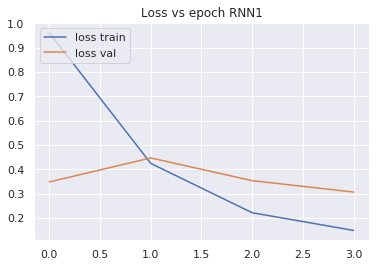

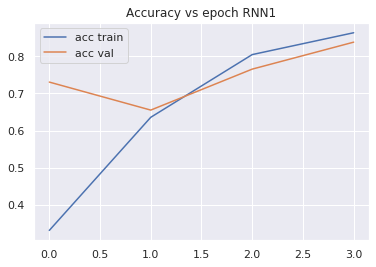


------ Training ------
Accuracy rnn1 : 0.9072657743785851
F1-score None rnn1 : [0.85315076 0.96791516 0.95511189 0.84887103]
F1-score macro rnn1 : 0.9062622094898134

------ Validation ------
Accuracy rnn1 : 0.8376470588235294
F1-score None rnn1 : [0.90455012 0.17948718 0.07017544 0.83254494]
F1-score macro rnn1 : 0.49668941908221675

------ Testing ------
Accuracy rnn1 : 0.8045219029674988
F1-score None rnn1 : [0.88868332 0.20627803 0.25698324 0.73544093]
F1-score macro rnn1 : 0.5218463792062925


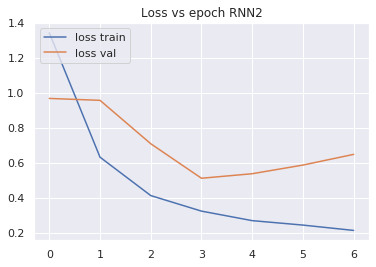

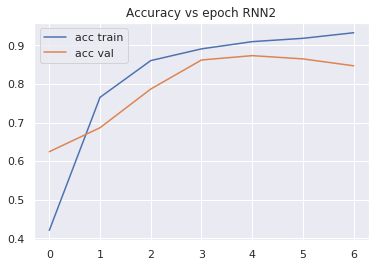


------ Training ------
Accuracy rnn2 : 0.943389784211964
F1-score None rnn2 : [0.89337176 0.99279989 0.9787234  0.90604205]
F1-score macro rnn2 : 0.9427342770826219

------ Validation ------
Accuracy rnn2 : 0.8470588235294118
F1-score None rnn2 : [0.91393018 0.2        0.03389831 0.82373782]
F1-score macro rnn2 : 0.4928915756132347

------ Testing ------
Accuracy rnn2 : 0.8172397550635893
F1-score None rnn2 : [0.8975175  0.19889503 0.25125628 0.77900552]
F1-score macro rnn2 : 0.5316685846668131


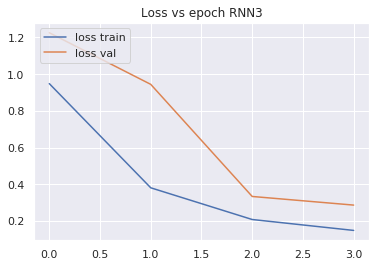

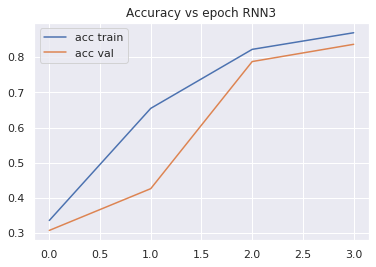


------ Training ------
Accuracy rnn3 : 0.9155285441136302
F1-score None rnn3 : [0.86209386 0.97320587 0.95751854 0.86637415]
F1-score macro rnn3 : 0.9147981072886897

------ Validation ------
Accuracy rnn3 : 0.8362352941176471
F1-score None rnn3 : [0.90789016 0.18918919 0.08080808 0.80461812]
F1-score macro rnn3 : 0.49562638764775396

------ Testing ------
Accuracy rnn3 : 0.8144135657089024
F1-score None rnn3 : [0.89829965 0.34166667 0.26744186 0.73919107]
F1-score macro rnn3 : 0.5616498120368645

Entrenando exec  3 



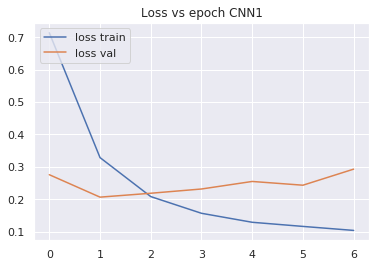

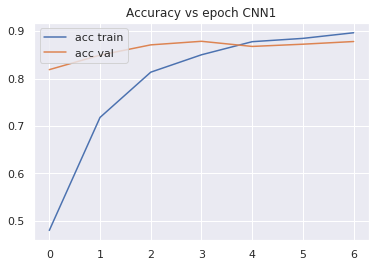


------ Training ------
Accuracy cnn1 : 0.948784485113357
F1-score None cnn1 : [0.90383285 0.99795557 0.99217785 0.90143875]
F1-score macro cnn1 : 0.948851254965384

------ Validation ------
Accuracy cnn1 : 0.8781176470588236
F1-score None cnn1 : [0.9273743  0.         0.09756098 0.82891125]
F1-score macro cnn1 : 0.4634616326791645

------ Testing ------
Accuracy cnn1 : 0.8601036269430051
F1-score None cnn1 : [0.9233501  0.         0.02597403 0.7771261 ]
F1-score macro cnn1 : 0.431612557315428


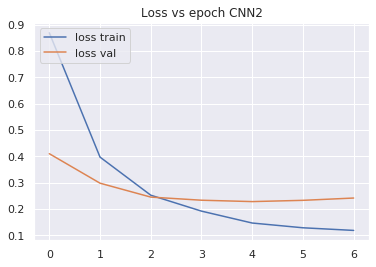

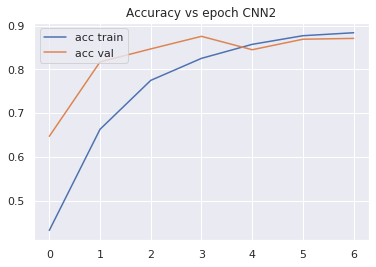


------ Training ------
Accuracy cnn2 : 0.9509013930620049
F1-score None cnn2 : [0.90248403 0.99564626 0.99632503 0.90829579]
F1-score macro cnn2 : 0.9506877765506934

------ Validation ------
Accuracy cnn2 : 0.8705882352941177
F1-score None cnn2 : [0.92606223 0.05       0.08333333 0.81553398]
F1-score macro cnn2 : 0.4687323855214536

------ Testing ------
Accuracy cnn2 : 0.8455016486104568
F1-score None cnn2 : [0.91699605 0.09375    0.04444444 0.75507442]
F1-score macro cnn2 : 0.4525662291934465


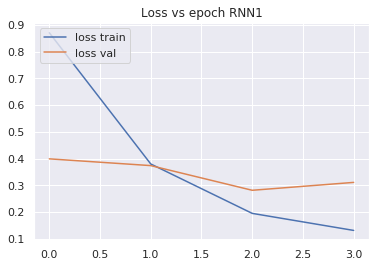

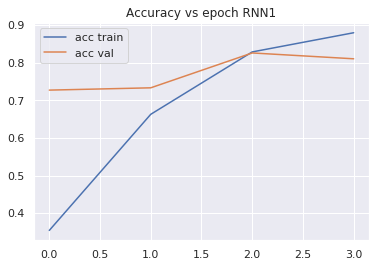


------ Training ------
Accuracy rnn1 : 0.8830920513520896
F1-score None rnn1 : [0.83830846 0.93656908 0.92067658 0.8358088 ]
F1-score macro rnn1 : 0.8828407310287306

------ Validation ------
Accuracy rnn1 : 0.8103529411764706
F1-score None rnn1 : [0.89253315 0.16083916 0.03703704 0.80268199]
F1-score macro rnn1 : 0.47327283436422685

------ Testing ------
Accuracy rnn1 : 0.7734338200659444
F1-score None rnn1 : [0.87508008 0.2238806  0.20833333 0.70607029]
F1-score macro rnn1 : 0.5033410736904984


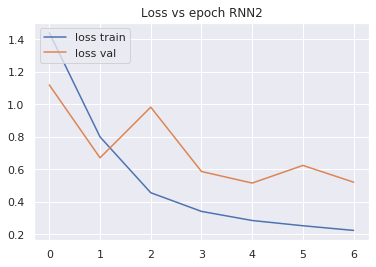

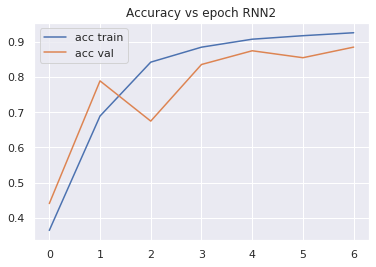


------ Training ------
Accuracy rnn2 : 0.9373804971319312
F1-score None rnn2 : [0.90051482 0.99109955 0.97282307 0.88689692]
F1-score macro rnn2 : 0.9378335886450396

------ Validation ------
Accuracy rnn2 : 0.8851764705882353
F1-score None rnn2 : [0.9334664  0.02531646 0.07017544 0.85740072]
F1-score macro rnn2 : 0.4715897542116558

------ Testing ------
Accuracy rnn2 : 0.8601036269430051
F1-score None rnn2 : [0.92284509 0.048      0.19230769 0.80686695]
F1-score macro rnn2 : 0.4925049331248603


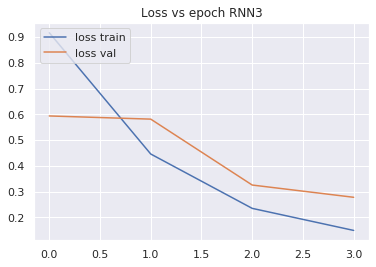

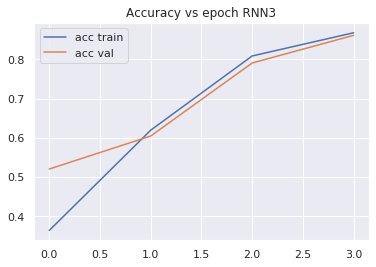


------ Training ------
Accuracy rnn3 : 0.8901256487298552
F1-score None rnn3 : [0.87446869 0.97983102 0.89167651 0.82134056]
F1-score macro rnn3 : 0.8918291929513459

------ Validation ------
Accuracy rnn3 : 0.8616470588235294
F1-score None rnn3 : [0.9220339  0.11538462 0.05479452 0.82457703]
F1-score macro rnn3 : 0.4791975150153329

------ Testing ------
Accuracy rnn3 : 0.8412623645784267
F1-score None rnn3 : [0.91224806 0.24675325 0.22857143 0.77028886]
F1-score macro rnn3 : 0.5394653989155125

Entrenando exec  4 



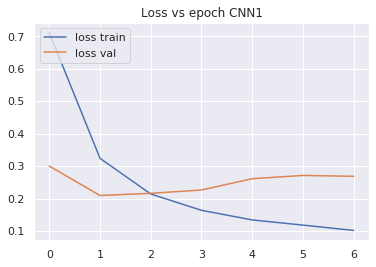

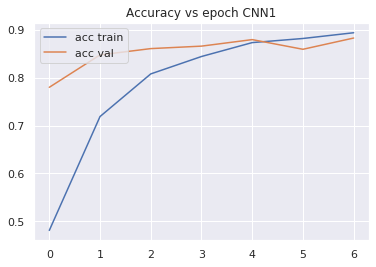


------ Training ------
Accuracy cnn1 : 0.948784485113357
F1-score None cnn1 : [0.90094018 0.99700191 0.99727372 0.8995189 ]
F1-score macro cnn1 : 0.9486836773635992

------ Validation ------
Accuracy cnn1 : 0.8832941176470588
F1-score None cnn1 : [0.93098958 0.02702703 0.05       0.83646617]
F1-score macro cnn1 : 0.4611206939434736

------ Testing ------
Accuracy cnn1 : 0.8610456900612341
F1-score None cnn1 : [0.92055116 0.08474576 0.075      0.78492936]
F1-score macro cnn1 : 0.4663065692719922


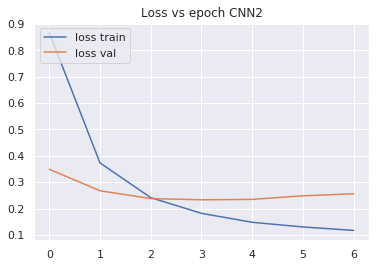

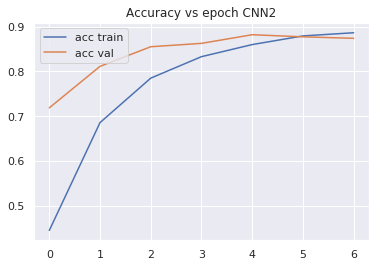


------ Training ------
Accuracy cnn2 : 0.9362878994810161
F1-score None cnn2 : [0.88274968 0.99618008 0.99604312 0.86920075]
F1-score macro cnn2 : 0.9360434063854556

------ Validation ------
Accuracy cnn2 : 0.8738823529411764
F1-score None cnn2 : [0.92410714 0.05405405 0.04761905 0.81162325]
F1-score macro cnn2 : 0.45935087275580766

------ Testing ------
Accuracy cnn2 : 0.8393782383419689
F1-score None cnn2 : [0.90634785 0.05405405 0.07407407 0.68022181]
F1-score macro cnn2 : 0.4286744476070313


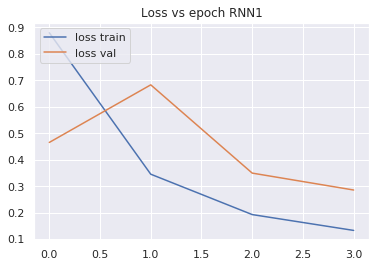

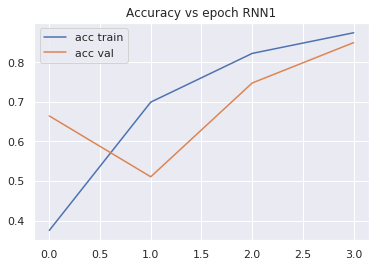


------ Training ------
Accuracy rnn1 : 0.89900300464354
F1-score None rnn1 : [0.85232415 0.9452779  0.93713696 0.86053249]
F1-score macro rnn1 : 0.8988178716912361

------ Validation ------
Accuracy rnn1 : 0.8498823529411764
F1-score None rnn1 : [0.92085848 0.11627907 0.06557377 0.8       ]
F1-score macro rnn1 : 0.4756778311245028

------ Testing ------
Accuracy rnn1 : 0.8313707018370231
F1-score None rnn1 : [0.91106421 0.1037037  0.24242424 0.7217806 ]
F1-score macro rnn1 : 0.4947431912283212


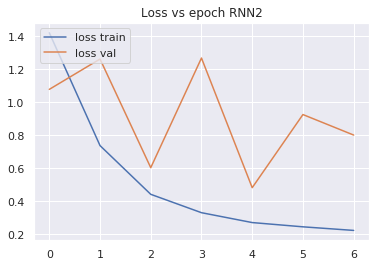

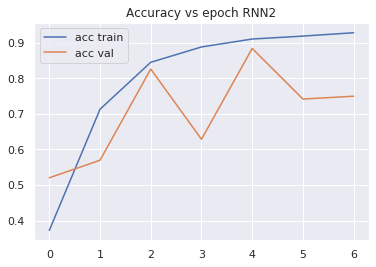


------ Training ------
Accuracy rnn2 : 0.907607211144496
F1-score None rnn2 : [0.82022646 0.98308813 0.96722178 0.85303674]
F1-score macro rnn2 : 0.9058932796462021

------ Validation ------
Accuracy rnn2 : 0.7496470588235294
F1-score None rnn2 : [0.84171043 0.04040404 0.08759124 0.68694362]
F1-score macro rnn2 : 0.414162332266224

------ Testing ------
Accuracy rnn2 : 0.7056052755534621
F1-score None rnn2 : [0.81601124 0.1375     0.22105263 0.58015267]
F1-score macro rnn2 : 0.43867913482243215


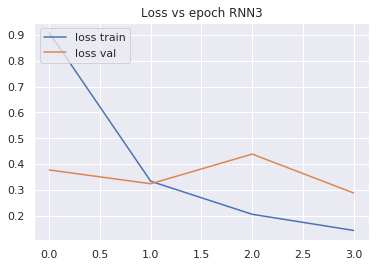

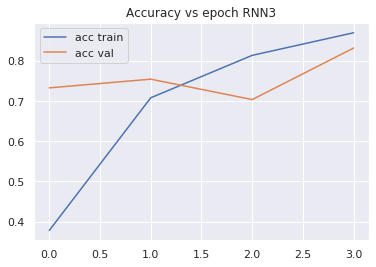


------ Training ------
Accuracy rnn3 : 0.9025539470090139
F1-score None rnn3 : [0.84043398 0.96881221 0.97044469 0.82475436]
F1-score macro rnn3 : 0.9011113088017382

------ Validation ------
Accuracy rnn3 : 0.8324705882352941
F1-score None rnn3 : [0.90139907 0.17679558 0.06976744 0.80937819]
F1-score macro rnn3 : 0.48933506869610277

------ Testing ------
Accuracy rnn3 : 0.7969853980216675
F1-score None rnn3 : [0.88233524 0.29213483 0.18897638 0.66162571]
F1-score macro rnn3 : 0.5062680393849417

Entrenando exec  5 



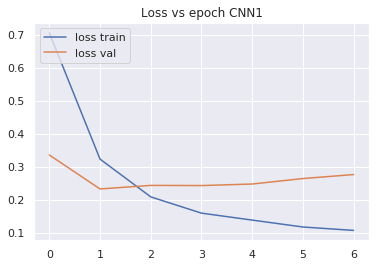

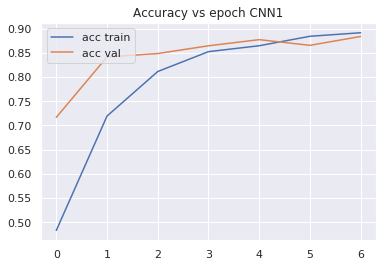


------ Training ------
Accuracy cnn1 : 0.9489210598197214
F1-score None cnn1 : [0.90185894 0.99686264 0.99576561 0.9010929 ]
F1-score macro cnn1 : 0.948895019847412

------ Validation ------
Accuracy cnn1 : 0.8837647058823529
F1-score None cnn1 : [0.93211488 0.         0.05       0.83925234]
F1-score macro cnn1 : 0.4553418047387814

------ Testing ------
Accuracy cnn1 : 0.8629298162976919
F1-score None cnn1 : [0.92407681 0.05263158 0.07407407 0.78678679]
F1-score macro cnn1 : 0.4593923123154251


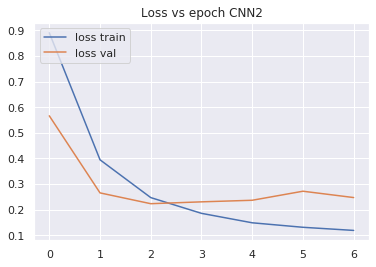

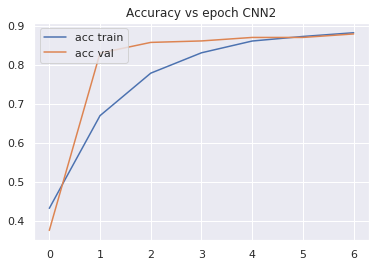


------ Training ------
Accuracy cnn2 : 0.9376536465446599
F1-score None cnn2 : [0.88417191 0.9964568  0.99646162 0.8723099 ]
F1-score macro cnn2 : 0.9373500574386413

------ Validation ------
Accuracy cnn2 : 0.8785882352941177
F1-score None cnn2 : [0.92921493 0.02564103 0.04651163 0.82468168]
F1-score macro cnn2 : 0.4565123168464626

------ Testing ------
Accuracy cnn2 : 0.8431464908148846
F1-score None cnn2 : [0.90951276 0.04958678 0.09302326 0.72758037]
F1-score macro cnn2 : 0.4449257914861905


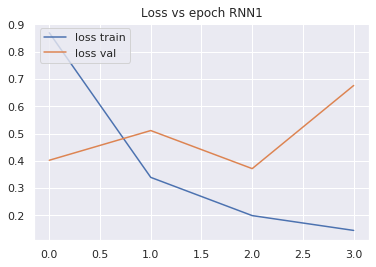

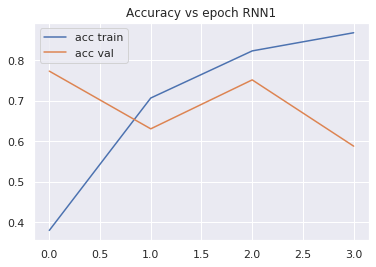


------ Training ------
Accuracy rnn1 : 0.7900846763179459
F1-score None rnn1 : [0.7340625  0.76782718 0.8968073  0.76199495]
F1-score macro rnn1 : 0.7901729820771191

------ Validation ------
Accuracy rnn1 : 0.5882352941176471
F1-score None rnn1 : [0.72705018 0.12062726 0.1        0.68539326]
F1-score macro rnn1 : 0.40826767594666385

------ Testing ------
Accuracy rnn1 : 0.5496938294865756
F1-score None rnn1 : [0.71133231 0.18003914 0.21311475 0.54285714]
F1-score macro rnn1 : 0.41183583707576


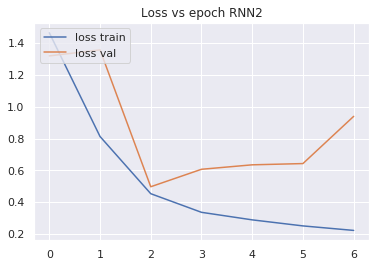

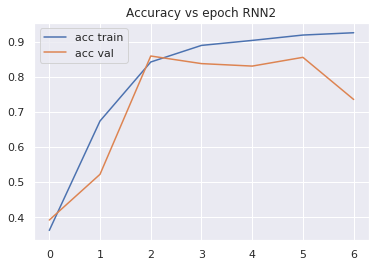


------ Training ------
Accuracy rnn2 : 0.9081535099699536
F1-score None rnn2 : [0.8347987  0.963598   0.94498967 0.87739003]
F1-score macro rnn2 : 0.9051940985953573

------ Validation ------
Accuracy rnn2 : 0.7355294117647059
F1-score None rnn2 : [0.8343973  0.08870968 0.05208333 0.76024412]
F1-score macro rnn2 : 0.4338586055294753

------ Testing ------
Accuracy rnn2 : 0.7258596325953839
F1-score None rnn2 : [0.83436853 0.1910828  0.22608696 0.68656716]
F1-score macro rnn2 : 0.48452636331732957


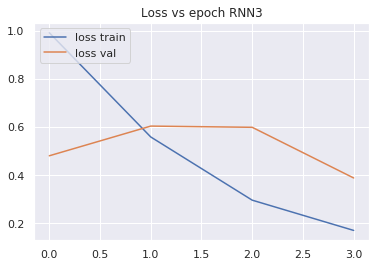

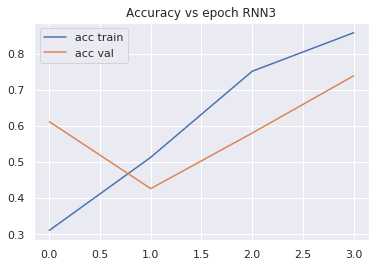


------ Training ------
Accuracy rnn3 : 0.8807019939907129
F1-score None rnn3 : [0.83318623 0.92053897 0.93549633 0.81893247]
F1-score macro rnn3 : 0.8770385012781728

------ Validation ------
Accuracy rnn3 : 0.7388235294117647
F1-score None rnn3 : [0.85651857 0.13256484 0.07777778 0.74513818]
F1-score macro rnn3 : 0.4529998424603989

------ Testing ------
Accuracy rnn3 : 0.7074894017899199
F1-score None rnn3 : [0.83396097 0.25868726 0.24888889 0.64948454]
F1-score macro rnn3 : 0.4977554139820981


In [19]:
fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

for i in range(1,6):    
    print ("\nEntrenando exec ", i,"\n")
    cnn1=create_ccn1(x_train.shape[1:])
    trained, hist =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=7, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/cnn1_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch CNN1")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch CNN1")
    plt.show()
    
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, n_labels, n_labels_val, n_labels_test, 'cnn1')
    fs_macro['cnn1'].append(f1_ma_t)
    fs_none['cnn1'].append(f1_t)
    accs['cnn1'].append(acc_t)
    confusions['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    trained, hist =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=7, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/cnn2_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch CNN2")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch CNN2")
    plt.show()
    
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'cnn2')
    fs_macro['cnn2'].append(f1_ma_t)
    fs_none['cnn2'].append(f1_t)
    accs['cnn2'].append(acc_t)
    confusions['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn1_'+str(i)+'-exec_8.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN1")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN1")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn1')
    fs_macro['rnn1'].append(f1_ma_t)
    fs_none['rnn1'].append(f1_t)
    accs['rnn1'].append(acc_t)
    confusions['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=7, BS=32, verb=0, focal=False)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn2_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN2")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN2")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn2')
    fs_macro['rnn2'].append(f1_ma_t)
    fs_none['rnn2'].append(f1_t)
    accs['rnn2'].append(acc_t)
    confusions['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn3_'+str(i)+'-exec_8.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN3")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN3")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn3')
    fs_macro['rnn3'].append(f1_ma_t)
    fs_none['rnn3'].append(f1_t)
    accs['rnn3'].append(acc_t)
    confusions['rnn3'].append(matriz_t)


In [20]:
print ("--------- Usando contexto positivo obligadamente y negativo cuando es posible ---------")

for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("0.15 Clase - F1-score promedio para",key,":" ,temp/5)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("0.15 Clase - F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("0.15 Clase - Accuracy promedio para",key,":" ,temp/5)

--------- Usando contexto positivo obligadamente y negativo cuando es posible ---------
0.15 Clase - F1-score promedio para cnn1 : [0.92141692 0.05533371 0.05925204 0.77822527]
0.15 Clase - F1-score promedio para cnn2 : [0.91301964 0.05357536 0.07687626 0.73229509]
0.15 Clase - F1-score promedio para rnn1 : [0.84287013 0.1891571  0.23750445 0.67098186]
0.15 Clase - F1-score promedio para rnn2 : [0.85981755 0.16541003 0.23108189 0.70814558]
0.15 Clase - F1-score promedio para rnn3 : [0.86367474 0.28278402 0.25006685 0.67702126]

0.15 Clase - F1-score macro promedio para cnn1 : 0.45355698517514487 desvest:  0.015670688922648612
0.15 Clase - F1-score macro promedio para cnn2 : 0.4439415844688702 desvest:  0.009303350700131755
0.15 Clase - F1-score macro promedio para rnn1 : 0.4851283861678846 desvest:  0.03800175350611205
0.15 Clase - F1-score macro promedio para rnn2 : 0.491113761979003 desvest:  0.030760376509111478
0.15 Clase - F1-score macro promedio para rnn3 : 0.5183867174742808 des

### Ponderando

In [23]:
macro_augmented = np.load('../Datasets/CSV_Harassment/balance_clase_Pon_GloVe.npy', allow_pickle=True)
np.random.shuffle(macro_augmented)

ids_train=macro_augmented[:,0]
tws_train=macro_augmented[:,1]
labels_train=macro_augmented[:,2]
class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
print ("Pesos de clases:", class_weights)

sentences = tws_train
n_labels = labels_train.copy()

input_ids = []
for sent in sentences:
    encoded_sent = [] 
    for wd in sent:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids.append(encoded_sent)

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")
y_train=to_categorical(n_labels,num_classes=4)
shape=np.asarray(input_ids).shape
x_train=np.zeros((shape[0], shape[1], emb))
j=0
for in_id in input_ids:
    x_train[j]=EMB_matrix[in_id]
    j+=1

Pesos de clases: [1. 1. 1. 1.]



Entrenando exec  1 



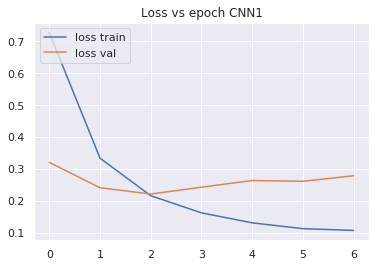

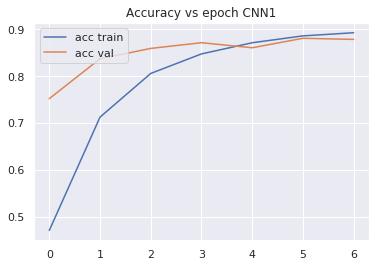


------ Training ------
Accuracy cnn1 : 0.944140945096968
F1-score None cnn1 : [0.89549861 0.99590723 0.99631801 0.88835636]
F1-score macro cnn1 : 0.9440200520656483

------ Validation ------
Accuracy cnn1 : 0.8785882352941177
F1-score None cnn1 : [0.92864062 0.02702703 0.05       0.82194418]
F1-score macro cnn1 : 0.45690295601879527

------ Testing ------
Accuracy cnn1 : 0.8473857748469148
F1-score None cnn1 : [0.91347271 0.05042017 0.02597403 0.73267327]
F1-score macro cnn1 : 0.4306350418809046


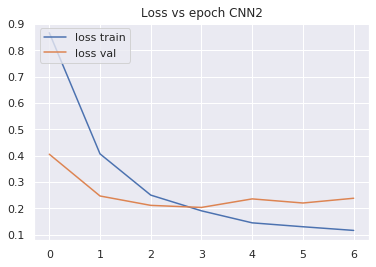

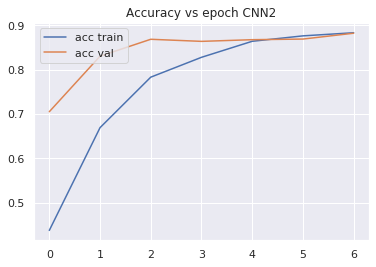


------ Training ------
Accuracy cnn2 : 0.9515159792406447
F1-score None cnn2 : [0.90611903 0.99591614 0.99562961 0.90806754]
F1-score macro cnn2 : 0.9514330810280778

------ Validation ------
Accuracy cnn2 : 0.8818823529411765
F1-score None cnn2 : [0.93055556 0.07407407 0.04878049 0.83876812]
F1-score macro cnn2 : 0.47304455834413417

------ Testing ------
Accuracy cnn2 : 0.8634008478568064
F1-score None cnn2 : [0.92275574 0.1        0.02564103 0.8028777 ]
F1-score macro cnn2 : 0.4628186161525252


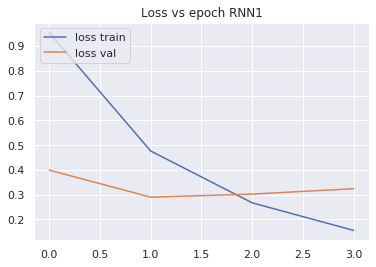

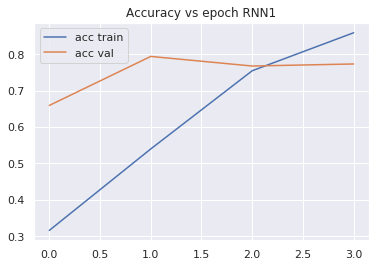


------ Training ------
Accuracy rnn1 : 0.8842529363561868
F1-score None rnn1 : [0.80012434 0.96154376 0.9513587  0.82194441]
F1-score macro rnn1 : 0.8837428021876109

------ Validation ------
Accuracy rnn1 : 0.7731764705882352
F1-score None rnn1 : [0.85352218 0.19548872 0.1        0.71048744]
F1-score macro rnn1 : 0.464874585770247

------ Testing ------
Accuracy rnn1 : 0.7315120113047574
F1-score None rnn1 : [0.83796134 0.26008969 0.33802817 0.59459459]
F1-score macro rnn1 : 0.5076684463459898


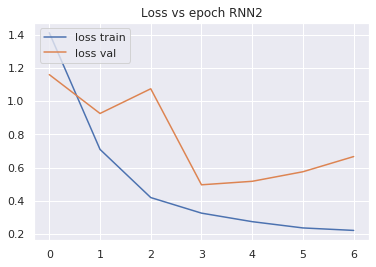

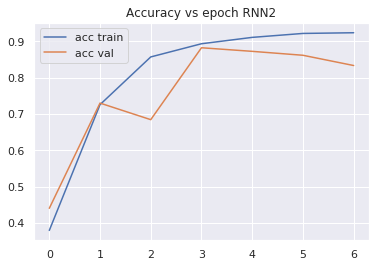


------ Training ------
Accuracy rnn2 : 0.9360830374214696
F1-score None rnn2 : [0.89282652 0.98490566 0.97264113 0.89087705]
F1-score macro rnn2 : 0.9353125910637841

------ Validation ------
Accuracy rnn2 : 0.8334117647058824
F1-score None rnn2 : [0.90682369 0.15       0.05882353 0.8119891 ]
F1-score macro rnn2 : 0.48190908066086857

------ Testing ------
Accuracy rnn2 : 0.8087611869995289
F1-score None rnn2 : [0.8925144  0.25098039 0.25581395 0.77344877]
F1-score macro rnn2 : 0.5431893786218706


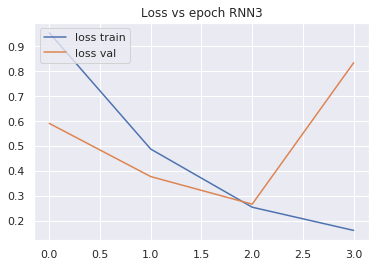

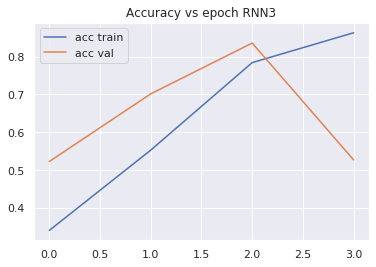


------ Training ------
Accuracy rnn3 : 0.8143266866976236
F1-score None rnn3 : [0.64090826 0.90897771 0.85276217 0.79481522]
F1-score macro rnn3 : 0.7993658414001117

------ Validation ------
Accuracy rnn3 : 0.5270588235294118
F1-score None rnn3 : [0.63253285 0.12301587 0.03439803 0.67844523]
F1-score macro rnn3 : 0.36709799677963534

------ Testing ------
Accuracy rnn3 : 0.4813942534149788
F1-score None rnn3 : [0.59349241 0.18471338 0.19921875 0.57178527]
F1-score macro rnn3 : 0.3873024505049427

Entrenando exec  2 



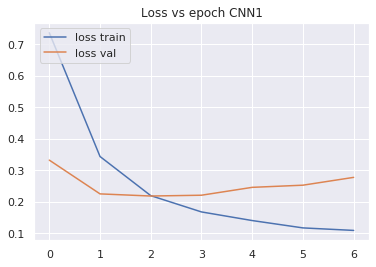

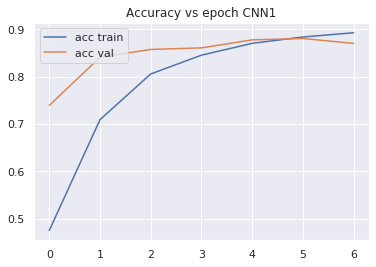


------ Training ------
Accuracy cnn1 : 0.9346490030046435
F1-score None cnn1 : [0.88017713 0.99631299 0.99550102 0.86565017]
F1-score macro cnn1 : 0.9344103277622082

------ Validation ------
Accuracy cnn1 : 0.8701176470588236
F1-score None cnn1 : [0.92302779 0.02631579 0.04651163 0.804     ]
F1-score macro cnn1 : 0.4499638010075734

------ Testing ------
Accuracy cnn1 : 0.8407913330193123
F1-score None cnn1 : [0.90814857 0.01709402 0.07407407 0.70956522]
F1-score macro cnn1 : 0.42722047081966463


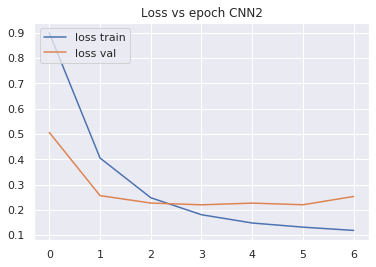

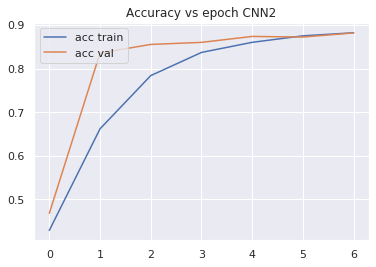


------ Training ------
Accuracy cnn2 : 0.9472821633433488
F1-score None cnn2 : [0.8993493  0.99686435 0.99356781 0.89936683]
F1-score macro cnn2 : 0.9472870735901141

------ Validation ------
Accuracy cnn2 : 0.8818823529411765
F1-score None cnn2 : [0.92960526 0.02597403 0.05128205 0.83912249]
F1-score macro cnn2 : 0.46149595667570503

------ Testing ------
Accuracy cnn2 : 0.8553933113518606
F1-score None cnn2 : [0.91826497 0.08333333 0.05128205 0.76783005]
F1-score macro cnn2 : 0.45517760126444007


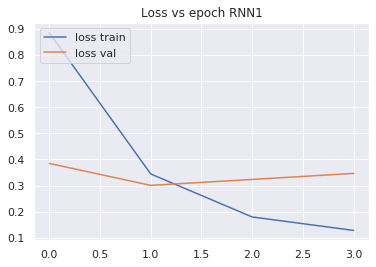

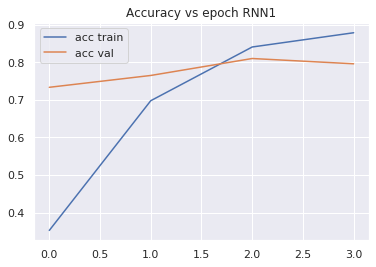


------ Training ------
Accuracy rnn1 : 0.9015296367112811
F1-score None rnn1 : [0.83984543 0.98179366 0.92778489 0.84934992]
F1-score macro rnn1 : 0.8996934737726133

------ Validation ------
Accuracy rnn1 : 0.796235294117647
F1-score None rnn1 : [0.88376963 0.15172414 0.05529954 0.79960899]
F1-score macro rnn1 : 0.47260057594169375

------ Testing ------
Accuracy rnn1 : 0.77296278850683
F1-score None rnn1 : [0.87025821 0.26086957 0.25657895 0.72      ]
F1-score macro rnn1 : 0.5269266802663128


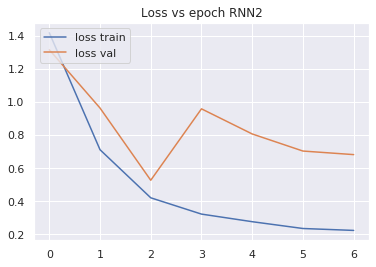

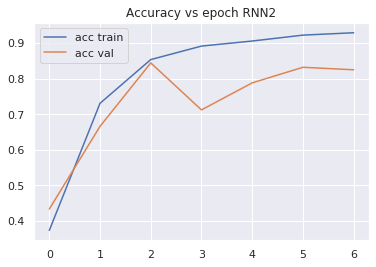


------ Training ------
Accuracy rnn2 : 0.9368341983064736
F1-score None rnn2 : [0.87761106 0.98887683 0.97519338 0.9015748 ]
F1-score macro rnn2 : 0.93581402034568

------ Validation ------
Accuracy rnn2 : 0.8244705882352941
F1-score None rnn2 : [0.89791593 0.1294964  0.05172414 0.80584192]
F1-score macro rnn2 : 0.4712445989934679

------ Testing ------
Accuracy rnn2 : 0.7706076307112577
F1-score None rnn2 : [0.86858656 0.12560386 0.17647059 0.71990172]
F1-score macro rnn2 : 0.4726406834031975


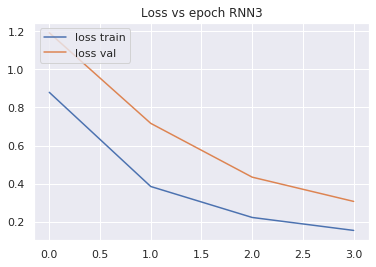

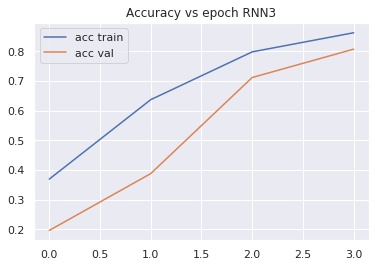


------ Training ------
Accuracy rnn3 : 0.8939497405080579
F1-score None rnn3 : [0.85112606 0.93798947 0.94492835 0.83918865]
F1-score macro rnn3 : 0.8933081337436729

------ Validation ------
Accuracy rnn3 : 0.8075294117647058
F1-score None rnn3 : [0.89297068 0.16091954 0.02941176 0.78899083]
F1-score macro rnn3 : 0.4680732030904356

------ Testing ------
Accuracy rnn3 : 0.7668393782383419
F1-score None rnn3 : [0.86818632 0.24630542 0.24193548 0.72278665]
F1-score macro rnn3 : 0.5198034682493248

Entrenando exec  3 



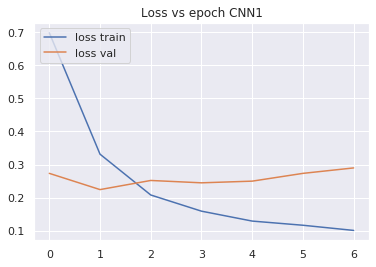

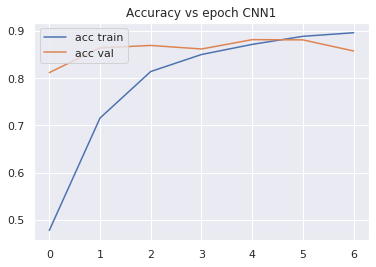


------ Training ------
Accuracy cnn1 : 0.9491259218792679
F1-score None cnn1 : [0.8969117  0.99659725 0.99590835 0.90612033]
F1-score macro cnn1 : 0.9488844075600759

------ Validation ------
Accuracy cnn1 : 0.8574117647058823
F1-score None cnn1 : [0.91709666 0.02564103 0.0952381  0.79476697]
F1-score macro cnn1 : 0.45818568764542356

------ Testing ------
Accuracy cnn1 : 0.8280734809232219
F1-score None cnn1 : [0.90618136 0.08547009 0.07407407 0.71080139]
F1-score macro cnn1 : 0.4441317287636557


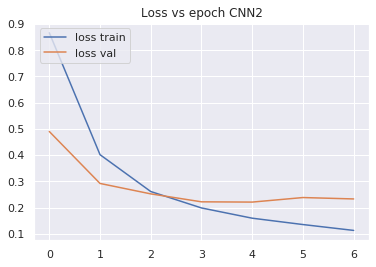

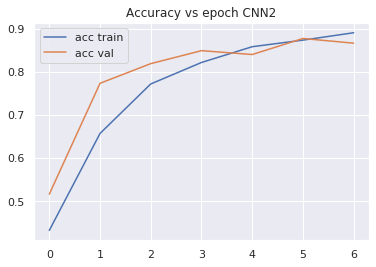


------ Training ------
Accuracy cnn2 : 0.9422971865610489
F1-score None cnn2 : [0.89420349 0.99066432 0.99469604 0.88814224]
F1-score macro cnn2 : 0.9419265217685954

------ Validation ------
Accuracy cnn2 : 0.8668235294117647
F1-score None cnn2 : [0.91952507 0.18897638 0.09302326 0.82824427]
F1-score macro cnn2 : 0.5074422436347326

------ Testing ------
Accuracy cnn2 : 0.8219500706547339
F1-score None cnn2 : [0.89714625 0.1971831  0.11235955 0.72413793]
F1-score macro cnn2 : 0.4827067086617019


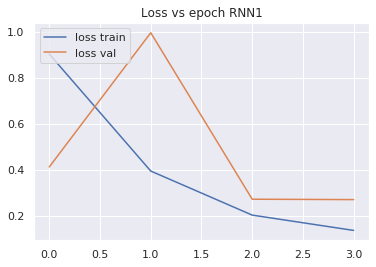

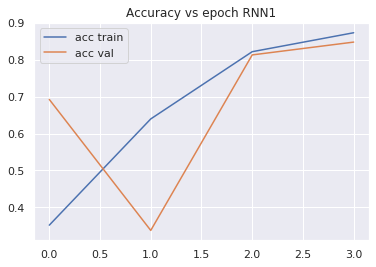


------ Training ------
Accuracy rnn1 : 0.9209232450150232
F1-score None rnn1 : [0.87677392 0.97820823 0.96060485 0.86385107]
F1-score macro rnn1 : 0.9198595196346414

------ Validation ------
Accuracy rnn1 : 0.8484705882352941
F1-score None rnn1 : [0.92167454 0.16806723 0.03883495 0.79924953]
F1-score macro rnn1 : 0.4819565633826972

------ Testing ------
Accuracy rnn1 : 0.843617522373999
F1-score None rnn1 : [0.91658972 0.25906736 0.26388889 0.78181818]
F1-score macro rnn1 : 0.5553410370334609


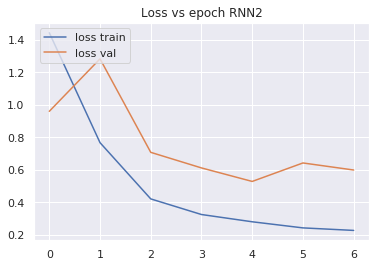

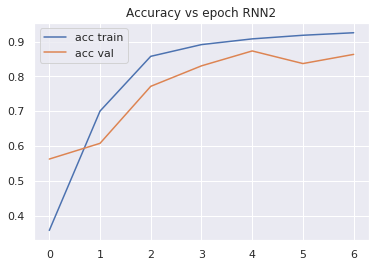


------ Training ------
Accuracy rnn2 : 0.9429117727396886
F1-score None rnn2 : [0.89565341 0.98806093 0.98108144 0.90554442]
F1-score macro rnn2 : 0.942585050346085

------ Validation ------
Accuracy rnn2 : 0.8630588235294118
F1-score None rnn2 : [0.9222973  0.04705882 0.04494382 0.83333333]
F1-score macro rnn2 : 0.4619083185961904

------ Testing ------
Accuracy rnn2 : 0.8497409326424871
F1-score None rnn2 : [0.91636142 0.12598425 0.25       0.79884226]
F1-score macro rnn2 : 0.5227969814819012


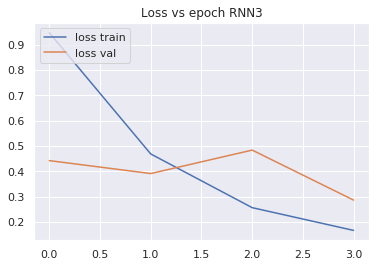

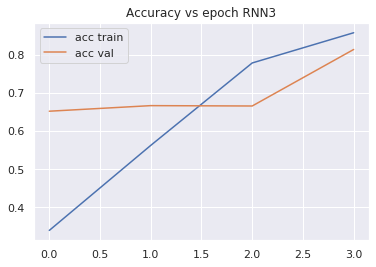


------ Training ------
Accuracy rnn3 : 0.9050122917235728
F1-score None rnn3 : [0.85884058 0.96819694 0.94033351 0.84563012]
F1-score macro rnn3 : 0.9032502874655302

------ Validation ------
Accuracy rnn3 : 0.8131764705882353
F1-score None rnn3 : [0.90145732 0.20858896 0.06944444 0.76720075]
F1-score macro rnn3 : 0.4866728692024909

------ Testing ------
Accuracy rnn3 : 0.7913330193122939
F1-score None rnn3 : [0.88525641 0.23104693 0.29787234 0.72314675]
F1-score macro rnn3 : 0.5343306073605951

Entrenando exec  4 



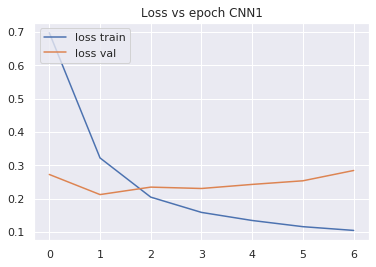

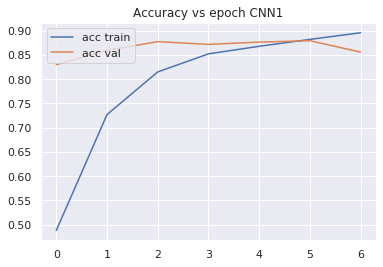


------ Training ------
Accuracy cnn1 : 0.9472138759901666
F1-score None cnn1 : [0.89028672 0.99713935 0.99672846 0.90340836]
F1-score macro cnn1 : 0.9468907235489801

------ Validation ------
Accuracy cnn1 : 0.856
F1-score None cnn1 : [0.91397109 0.05063291 0.05       0.79673469]
F1-score macro cnn1 : 0.4528346748894092

------ Testing ------
Accuracy cnn1 : 0.8356099858690532
F1-score None cnn1 : [0.90892019 0.125      0.         0.74144038]
F1-score macro cnn1 : 0.44384014139936034


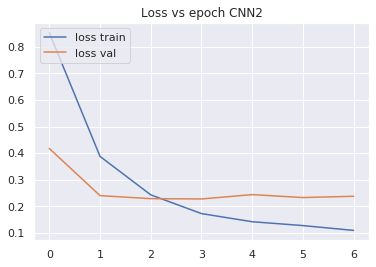

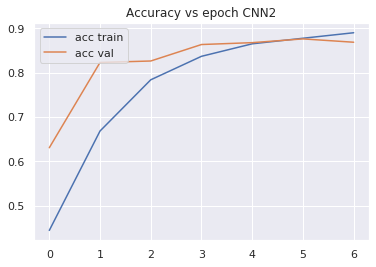


------ Training ------
Accuracy cnn2 : 0.9455066921606119
F1-score None cnn2 : [0.8967472  0.99673114 0.99604204 0.89209431]
F1-score macro cnn2 : 0.9454036712600052

------ Validation ------
Accuracy cnn2 : 0.8687058823529412
F1-score None cnn2 : [0.92162602 0.04123711 0.04878049 0.82160077]
F1-score macro cnn2 : 0.45831109723080643

------ Testing ------
Accuracy cnn2 : 0.8422044276966557
F1-score None cnn2 : [0.90745576 0.06015038 0.07407407 0.74188034]
F1-score macro cnn2 : 0.44589013763123975


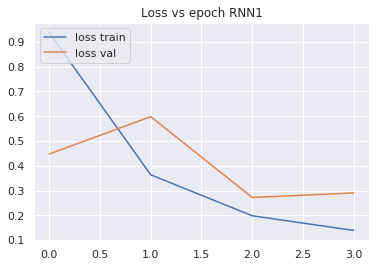

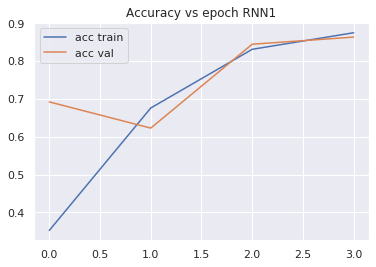


------ Training ------
Accuracy rnn1 : 0.9024173723026495
F1-score None rnn1 : [0.84703633 0.9403307  0.96416217 0.86330935]
F1-score macro rnn1 : 0.9037096370928859

------ Validation ------
Accuracy rnn1 : 0.8635294117647059
F1-score None rnn1 : [0.92067797 0.02531646 0.03773585 0.81335616]
F1-score macro rnn1 : 0.4492716088095158

------ Testing ------
Accuracy rnn1 : 0.8539802166745172
F1-score None rnn1 : [0.9196319  0.09677419 0.26923077 0.77572559]
F1-score macro rnn1 : 0.5153406145717983


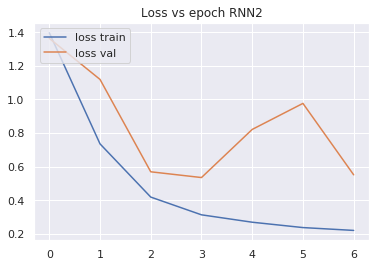

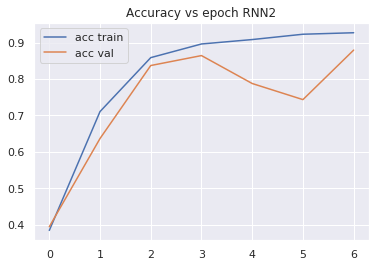


------ Training ------
Accuracy rnn2 : 0.9357416006555586
F1-score None rnn2 : [0.88202692 0.98357941 0.99208083 0.88639866]
F1-score macro rnn2 : 0.936021454405883

------ Validation ------
Accuracy rnn2 : 0.8795294117647059
F1-score None rnn2 : [0.93098958 0.07594937 0.03278689 0.83815029]
F1-score macro rnn2 : 0.4694690311712959

------ Testing ------
Accuracy rnn2 : 0.8455016486104568
F1-score None rnn2 : [0.91298063 0.05172414 0.08       0.73204904]
F1-score macro rnn2 : 0.4441884512371429


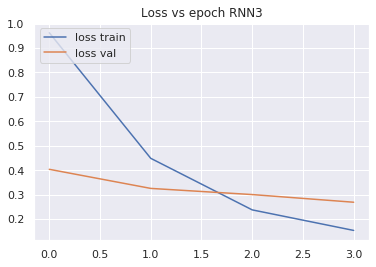

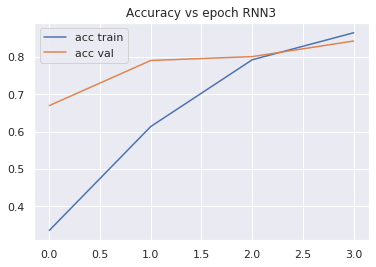


------ Training ------
Accuracy rnn3 : 0.9155285441136302
F1-score None rnn3 : [0.86398385 0.97657757 0.95914036 0.86069586]
F1-score macro rnn3 : 0.9150994074320473

------ Validation ------
Accuracy rnn3 : 0.8428235294117647
F1-score None rnn3 : [0.91385252 0.11111111 0.09433962 0.78993056]
F1-score macro rnn3 : 0.4773084512036808

------ Testing ------
Accuracy rnn3 : 0.8257183231276496
F1-score None rnn3 : [0.9044141  0.25149701 0.30188679 0.73670558]
F1-score macro rnn3 : 0.5486258688318881

Entrenando exec  5 



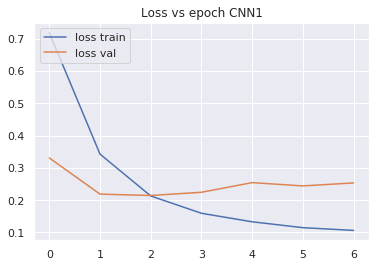

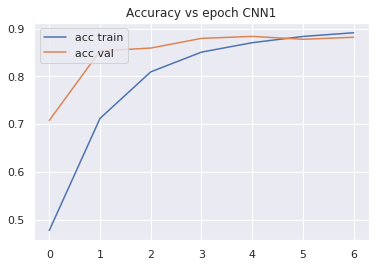


------ Training ------
Accuracy cnn1 : 0.9468724392242557
F1-score None cnn1 : [0.89931258 0.99632403 0.99632403 0.89483215]
F1-score macro cnn1 : 0.9466981962619898

------ Validation ------
Accuracy cnn1 : 0.8818823529411765
F1-score None cnn1 : [0.92961401 0.07407407 0.08888889 0.8376561 ]
F1-score macro cnn1 : 0.4825582687981395

------ Testing ------
Accuracy cnn1 : 0.8601036269430051
F1-score None cnn1 : [0.91981132 0.11940299 0.07317073 0.79937304]
F1-score macro cnn1 : 0.47793951957225306


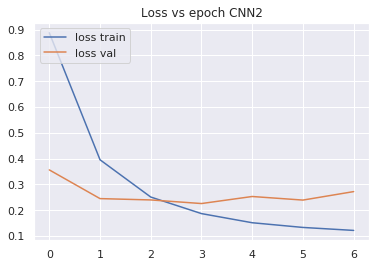

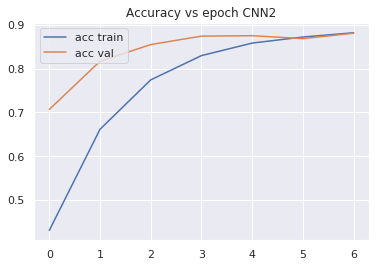


------ Training ------
Accuracy cnn2 : 0.9343758535919148
F1-score None cnn2 : [0.88785667 0.99659354 0.98185847 0.87195885]
F1-score macro cnn2 : 0.9345668818675037

------ Validation ------
Accuracy cnn2 : 0.8809411764705882
F1-score None cnn2 : [0.92813406 0.         0.05       0.83446273]
F1-score macro cnn2 : 0.45314919843052304

------ Testing ------
Accuracy cnn2 : 0.8417333961375412
F1-score None cnn2 : [0.90877698 0.03508772 0.         0.7091222 ]
F1-score macro cnn2 : 0.4132467252034046


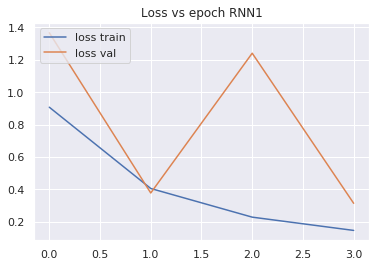

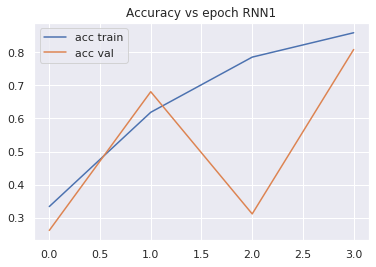


------ Training ------
Accuracy rnn1 : 0.9030319584812893
F1-score None rnn1 : [0.84789266 0.97123835 0.94262295 0.85022307]
F1-score macro rnn1 : 0.902994259034688

------ Validation ------
Accuracy rnn1 : 0.8084705882352942
F1-score None rnn1 : [0.88342246 0.13207547 0.03333333 0.79113384]
F1-score macro rnn1 : 0.4599912774416949

------ Testing ------
Accuracy rnn1 : 0.7757889778615167
F1-score None rnn1 : [0.86719788 0.25236593 0.16363636 0.72366791]
F1-score macro rnn1 : 0.5017170188064437


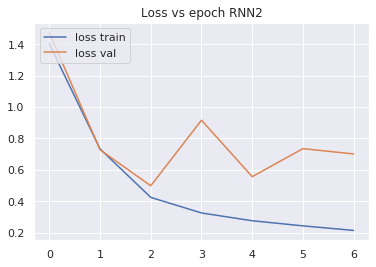

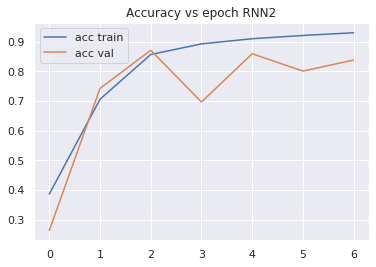


------ Training ------
Accuracy rnn2 : 0.9376536465446599
F1-score None rnn2 : [0.89070334 0.99190561 0.96775046 0.89801396]
F1-score macro rnn2 : 0.9370933418516143

------ Validation ------
Accuracy rnn2 : 0.8376470588235294
F1-score None rnn2 : [0.91546392 0.02439024 0.0625     0.80510018]
F1-score macro rnn2 : 0.4518635858943937

------ Testing ------
Accuracy rnn2 : 0.8101742816768723
F1-score None rnn2 : [0.90208465 0.09160305 0.2122449  0.73863636]
F1-score macro rnn2 : 0.4861422411076338


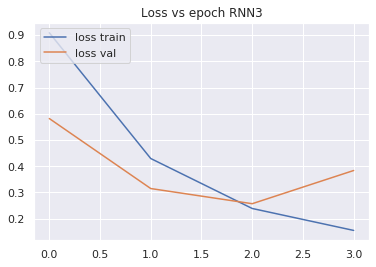

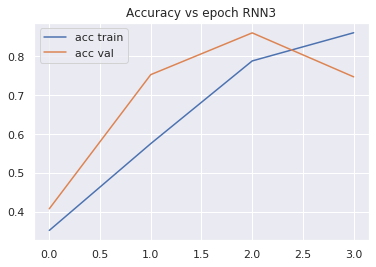


------ Training ------
Accuracy rnn3 : 0.8798825457525267
F1-score None rnn3 : [0.82804473 0.95321714 0.90881913 0.81586079]
F1-score macro rnn3 : 0.8764854475838428

------ Validation ------
Accuracy rnn3 : 0.7472941176470588
F1-score None rnn3 : [0.85912916 0.16788321 0.07960199 0.73512476]
F1-score macro rnn3 : 0.4604347809745743

------ Testing ------
Accuracy rnn3 : 0.7258596325953839
F1-score None rnn3 : [0.83967391 0.24935065 0.22745098 0.68882175]
F1-score macro rnn3 : 0.5013243237630364


In [24]:
fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

for i in range(1,6):    
    print ("\nEntrenando exec ", i,"\n")
    cnn1=create_ccn1(x_train.shape[1:])
    trained, hist =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=7, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/cnn1_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch CNN1")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch CNN1")
    plt.show()
    
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, n_labels, n_labels_val, n_labels_test, 'cnn1')
    fs_macro['cnn1'].append(f1_ma_t)
    fs_none['cnn1'].append(f1_t)
    accs['cnn1'].append(acc_t)
    confusions['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    trained, hist =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=7, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/cnn2_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch CNN2")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch CNN2")
    plt.show()
    
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'cnn2')
    fs_macro['cnn2'].append(f1_ma_t)
    fs_none['cnn2'].append(f1_t)
    accs['cnn2'].append(acc_t)
    confusions['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn1_'+str(i)+'-exec_8.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN1")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN1")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn1')
    fs_macro['rnn1'].append(f1_ma_t)
    fs_none['rnn1'].append(f1_t)
    accs['rnn1'].append(acc_t)
    confusions['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=7, BS=32, verb=0, focal=False)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn2_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN2")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN2")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn2')
    fs_macro['rnn2'].append(f1_ma_t)
    fs_none['rnn2'].append(f1_t)
    accs['rnn2'].append(acc_t)
    confusions['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn3_'+str(i)+'-exec_8.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN3")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN3")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn3')
    fs_macro['rnn3'].append(f1_ma_t)
    fs_none['rnn3'].append(f1_t)
    accs['rnn3'].append(acc_t)
    confusions['rnn3'].append(matriz_t)


In [25]:
print ("--------- Usando contexto positivo y negativo obligadamente ---------\n")

for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("0.15 Clase Ponderado - F1-score promedio para",key,":" ,temp/5)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("0.15 Clase Ponderado - F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("0.15 Clase Ponderado - Accuracy promedio para",key,":" ,temp/5)

--------- Usando contexto positivo y negativo obligadamente ---------

0.15 Clase Ponderado - F1-score promedio para cnn1 : [0.91130683 0.07947745 0.04945858 0.73877066]
0.15 Clase Ponderado - F1-score promedio para cnn2 : [0.91087994 0.09515091 0.05267134 0.74916964]
0.15 Clase Ponderado - F1-score promedio para rnn1 : [0.88232781 0.22583335 0.25827263 0.71916126]
0.15 Clase Ponderado - F1-score promedio para rnn2 : [0.89850553 0.12917914 0.19490589 0.75257563]
0.15 Clase Ponderado - F1-score promedio para rnn3 : [0.81820463 0.23258268 0.25367287 0.6886492 ]

0.15 Clase Ponderado - F1-score macro promedio para cnn1 : 0.44475338048716767 desvest:  0.017940293700390724
0.15 Clase Ponderado - F1-score macro promedio para cnn2 : 0.4519679577826623 desvest:  0.022843743800845154
0.15 Clase Ponderado - F1-score macro promedio para rnn1 : 0.5213987594048012 desvest:  0.018948507319384238
0.15 Clase Ponderado - F1-score macro promedio para rnn2 : 0.4937915471703492 desvest:  0.035349113197395

In [26]:
macro_augmented = np.load('../Datasets/CSV_Harassment/balance_clase_Pon_GloVe_pos.npy', allow_pickle=True)
np.random.shuffle(macro_augmented)

ids_train=macro_augmented[:,0]
tws_train=macro_augmented[:,1]
labels_train=macro_augmented[:,2]
class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
print ("Pesos de clases:", class_weights)

sentences = tws_train
n_labels = labels_train.copy()

input_ids = []
for sent in sentences:
    encoded_sent = [] 
    for wd in sent:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids.append(encoded_sent)

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")
y_train=to_categorical(n_labels,num_classes=4)
shape=np.asarray(input_ids).shape
x_train=np.zeros((shape[0], shape[1], emb))
j=0
for in_id in input_ids:
    x_train[j]=EMB_matrix[in_id]
    j+=1

Pesos de clases: [1. 1. 1. 1.]



Entrenando exec  1 



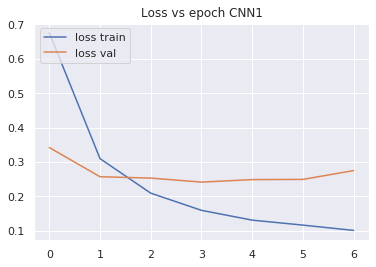

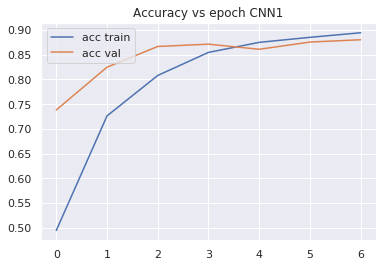


------ Training ------
Accuracy cnn1 : 0.9524037148320131
F1-score None cnn1 : [0.90688145 0.99645487 0.99536153 0.91056049]
F1-score macro cnn1 : 0.9523145825645799

------ Validation ------
Accuracy cnn1 : 0.8804705882352941
F1-score None cnn1 : [0.9301704  0.02739726 0.08510638 0.83729112]
F1-score macro cnn1 : 0.46999128945539426

------ Testing ------
Accuracy cnn1 : 0.8601036269430051
F1-score None cnn1 : [0.92089372 0.03603604 0.19354839 0.79452055]
F1-score macro cnn1 : 0.4862496727211947


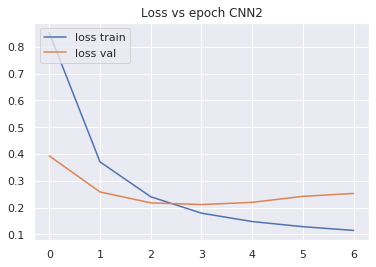

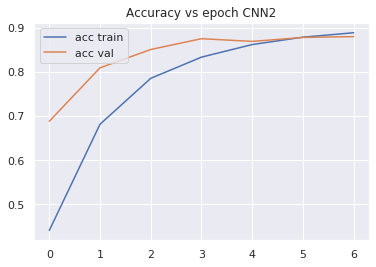


------ Training ------
Accuracy cnn2 : 0.9471455886369844
F1-score None cnn2 : [0.89932705 0.99713467 0.99686777 0.89479544]
F1-score macro cnn2 : 0.9470312309411875

------ Validation ------
Accuracy cnn2 : 0.8795294117647059
F1-score None cnn2 : [0.92780835 0.02702703 0.04444444 0.83301344]
F1-score macro cnn2 : 0.4580733148473983

------ Testing ------
Accuracy cnn2 : 0.8506829957607159
F1-score None cnn2 : [0.91435185 0.05357143 0.05       0.73913043]
F1-score macro cnn2 : 0.4392634288014723


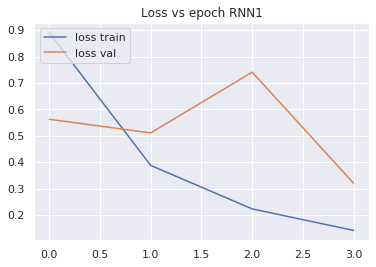

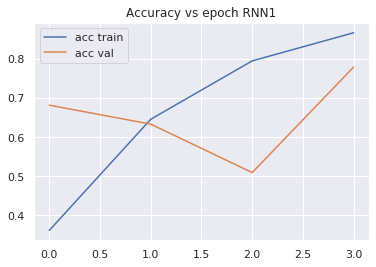


------ Training ------
Accuracy rnn1 : 0.8841846490030046
F1-score None rnn1 : [0.82769045 0.94430805 0.92659758 0.83581716]
F1-score macro rnn1 : 0.883603309185902

------ Validation ------
Accuracy rnn1 : 0.7792941176470588
F1-score None rnn1 : [0.86006577 0.14901961 0.07407407 0.76079734]
F1-score macro rnn1 : 0.4609891973866279

------ Testing ------
Accuracy rnn1 : 0.7414036740461611
F1-score None rnn1 : [0.84293015 0.23913043 0.19417476 0.67380952]
F1-score macro rnn1 : 0.48751121729891544


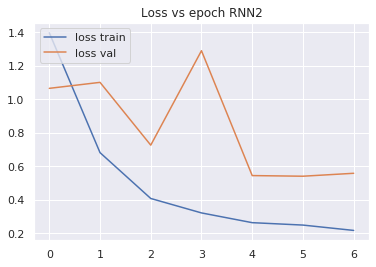

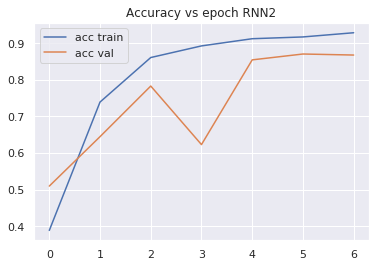


------ Training ------
Accuracy rnn2 : 0.9465310024583448
F1-score None rnn2 : [0.90150014 0.98805437 0.98824483 0.90766782]
F1-score macro rnn2 : 0.9463667907242637

------ Validation ------
Accuracy rnn2 : 0.867764705882353
F1-score None rnn2 : [0.9245283  0.09195402 0.05       0.83587444]
F1-score macro rnn2 : 0.4755891910842954

------ Testing ------
Accuracy rnn2 : 0.8431464908148846
F1-score None rnn2 : [0.91576674 0.04511278 0.18571429 0.79234973]
F1-score macro rnn2 : 0.48473588327650907


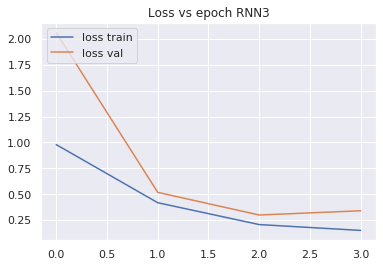

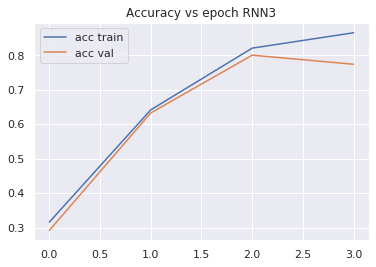


------ Training ------
Accuracy rnn3 : 0.8699125921879268
F1-score None rnn3 : [0.81619759 0.98083767 0.87353293 0.79994001]
F1-score macro rnn3 : 0.8676270503482706

------ Validation ------
Accuracy rnn3 : 0.7736470588235295
F1-score None rnn3 : [0.8794926  0.17142857 0.09659091 0.77486911]
F1-score macro rnn3 : 0.48059529772248943

------ Testing ------
Accuracy rnn3 : 0.748469147432878
F1-score None rnn3 : [0.86032453 0.15686275 0.22222222 0.67552182]
F1-score macro rnn3 : 0.4787328299138225

Entrenando exec  2 



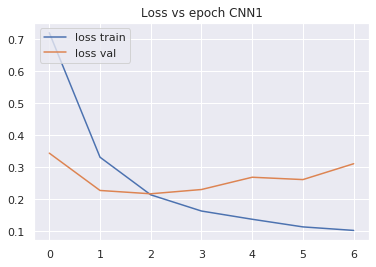

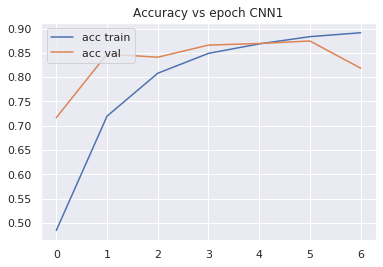


------ Training ------
Accuracy cnn1 : 0.9360147500682874
F1-score None cnn1 : [0.86789046 0.99645003 0.99288061 0.88545046]
F1-score macro cnn1 : 0.9356678906973468

------ Validation ------
Accuracy cnn1 : 0.8183529411764706
F1-score None cnn1 : [0.8866571  0.         0.04878049 0.74813711]
F1-score macro cnn1 : 0.42089367461571525

------ Testing ------
Accuracy cnn1 : 0.7630711257654262
F1-score None cnn1 : [0.86464646 0.09160305 0.02597403 0.61610487]
F1-score macro cnn1 : 0.39958210324236576


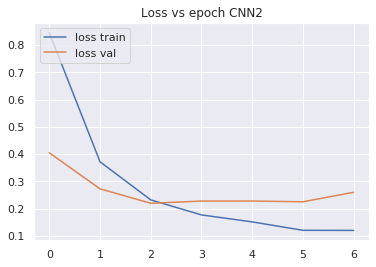

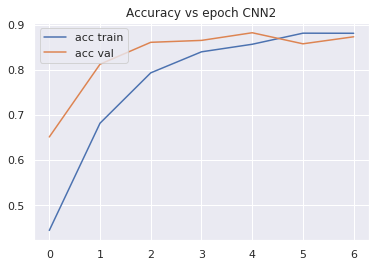


------ Training ------
Accuracy cnn2 : 0.94482381862879
F1-score None cnn2 : [0.89435561 0.99590611 0.99440273 0.8945067 ]
F1-score macro cnn2 : 0.9447927874884607

------ Validation ------
Accuracy cnn2 : 0.8729411764705882
F1-score None cnn2 : [0.92525519 0.05405405 0.05       0.81346679]
F1-score macro cnn2 : 0.46069400702049734

------ Testing ------
Accuracy cnn2 : 0.8478568064060292
F1-score None cnn2 : [0.91549716 0.064      0.09876543 0.74963821]
F1-score macro cnn2 : 0.45697520023259497


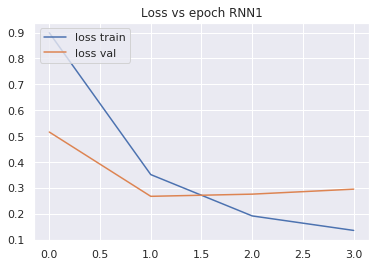

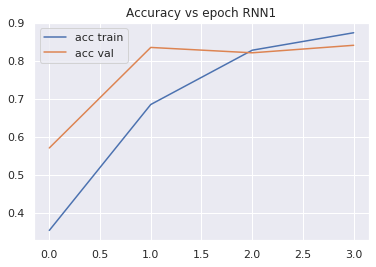


------ Training ------
Accuracy rnn1 : 0.9197623600109259
F1-score None rnn1 : [0.8682259  0.97532851 0.96271369 0.86940046]
F1-score macro rnn1 : 0.9189171386250071

------ Validation ------
Accuracy rnn1 : 0.8414117647058823
F1-score None rnn1 : [0.91299898 0.14492754 0.04705882 0.79927007]
F1-score macro rnn1 : 0.47606385230313586

------ Testing ------
Accuracy rnn1 : 0.8257183231276496
F1-score None rnn1 : [0.90308507 0.24413146 0.29370629 0.75477239]
F1-score macro rnn1 : 0.5489238039689511


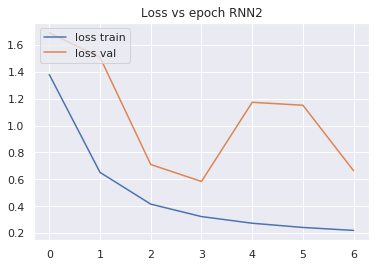

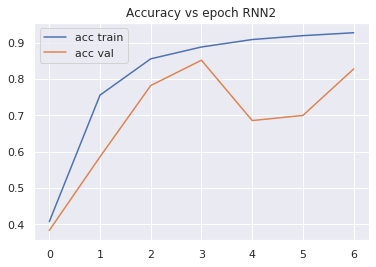


------ Training ------
Accuracy rnn2 : 0.9405900027314942
F1-score None rnn2 : [0.87793288 0.99536532 0.99183229 0.8953252 ]
F1-score macro rnn2 : 0.9401139231418922

------ Validation ------
Accuracy rnn2 : 0.827764705882353
F1-score None rnn2 : [0.89462518 0.07920792 0.06153846 0.77707006]
F1-score macro rnn2 : 0.45311040570705075

------ Testing ------
Accuracy rnn2 : 0.7885068299576071
F1-score None rnn2 : [0.88       0.14193548 0.09090909 0.68410042]
F1-score macro rnn2 : 0.4492362482975251


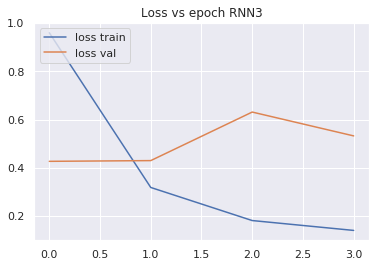

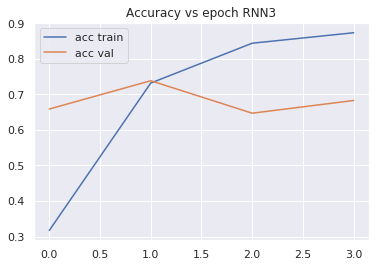


------ Training ------
Accuracy rnn3 : 0.8751024310297733
F1-score None rnn3 : [0.766346   0.89431888 0.95917285 0.85833558]
F1-score macro rnn3 : 0.8695433258389479

------ Validation ------
Accuracy rnn3 : 0.6828235294117647
F1-score None rnn3 : [0.78253968 0.1350211  0.08510638 0.76591928]
F1-score macro rnn3 : 0.44214661126900756

------ Testing ------
Accuracy rnn3 : 0.6095148374941121
F1-score None rnn3 : [0.7350038  0.17717718 0.21875    0.65251989]
F1-score macro rnn3 : 0.44586271689589874

Entrenando exec  3 



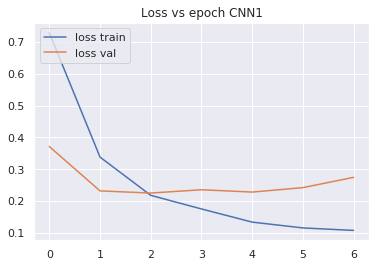

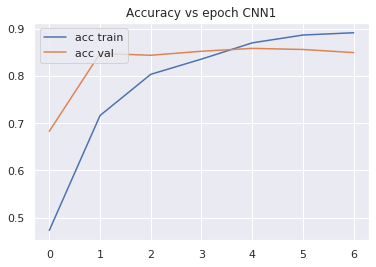


------ Training ------
Accuracy cnn1 : 0.9448921059819722
F1-score None cnn1 : [0.89558634 0.98626078 0.99370897 0.9026619 ]
F1-score macro cnn1 : 0.9445544978274445

------ Validation ------
Accuracy cnn1 : 0.8494117647058823
F1-score None cnn1 : [0.90703259 0.16666667 0.09756098 0.8294849 ]
F1-score macro cnn1 : 0.5001862836592348

------ Testing ------
Accuracy cnn1 : 0.8228921337729628
F1-score None cnn1 : [0.90049751 0.16877637 0.02597403 0.77653631]
F1-score macro cnn1 : 0.46794605564225394


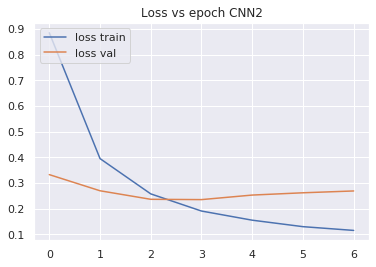

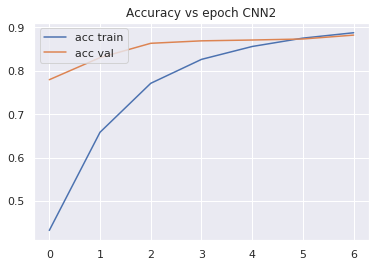


------ Training ------
Accuracy cnn2 : 0.9510379677683694
F1-score None cnn2 : [0.90447803 0.99686606 0.9961884  0.90608931]
F1-score macro cnn2 : 0.9509054488905977

------ Validation ------
Accuracy cnn2 : 0.8818823529411765
F1-score None cnn2 : [0.93069307 0.         0.13043478 0.83666062]
F1-score macro cnn2 : 0.4744471172438794

------ Testing ------
Accuracy cnn2 : 0.8629298162976919
F1-score None cnn2 : [0.9239487  0.03636364 0.09090909 0.7971223 ]
F1-score macro cnn2 : 0.462085933021335


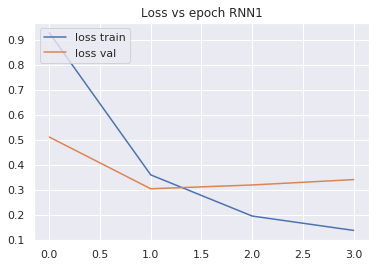

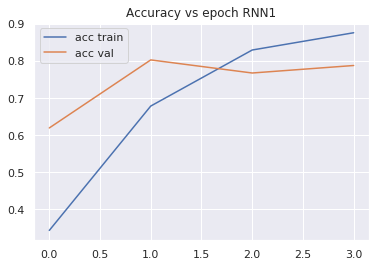


------ Training ------
Accuracy rnn1 : 0.8970226714012565
F1-score None rnn1 : [0.84750937 0.94755924 0.95604106 0.82573964]
F1-score macro rnn1 : 0.8942123282350665

------ Validation ------
Accuracy rnn1 : 0.788235294117647
F1-score None rnn1 : [0.88499828 0.1221374  0.06956522 0.7625    ]
F1-score macro rnn1 : 0.45980022638198204

------ Testing ------
Accuracy rnn1 : 0.7611869995289684
F1-score None rnn1 : [0.86486486 0.27654321 0.29411765 0.66539924]
F1-score macro rnn1 : 0.5252312403359894


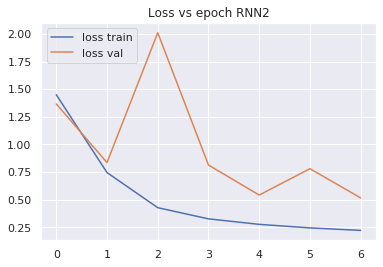

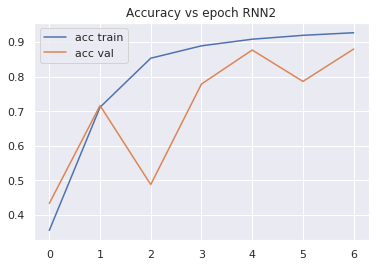


------ Training ------
Accuracy rnn2 : 0.9437995083310571
F1-score None rnn2 : [0.89928159 0.99249352 0.98120509 0.90296355]
F1-score macro rnn2 : 0.9439859343829519

------ Validation ------
Accuracy rnn2 : 0.88
F1-score None rnn2 : [0.93001346 0.11363636 0.04545455 0.84118674]
F1-score macro rnn2 : 0.48257277612895133

------ Testing ------
Accuracy rnn2 : 0.8487988695242581
F1-score None rnn2 : [0.91743685 0.1509434  0.04705882 0.79100529]
F1-score macro rnn2 : 0.47661108902730975


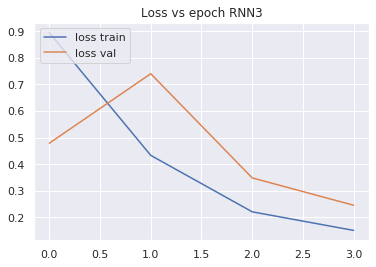

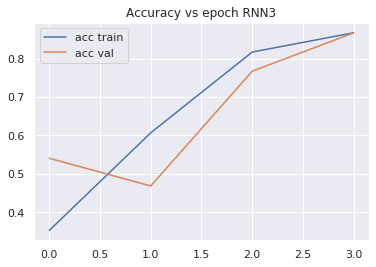


------ Training ------
Accuracy rnn3 : 0.921196394427752
F1-score None rnn3 : [0.8739658  0.98056273 0.96390086 0.86450724]
F1-score macro rnn3 : 0.92073415759207

------ Validation ------
Accuracy rnn3 : 0.8668235294117647
F1-score None rnn3 : [0.92666667 0.11009174 0.05333333 0.83302064]
F1-score macro rnn3 : 0.4807780952544881

------ Testing ------
Accuracy rnn3 : 0.833254828073481
F1-score None rnn3 : [0.90575275 0.27884615 0.2781457  0.77221325]
F1-score macro rnn3 : 0.558739462590305

Entrenando exec  4 



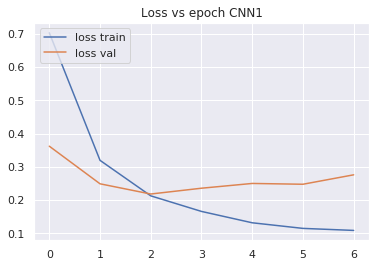

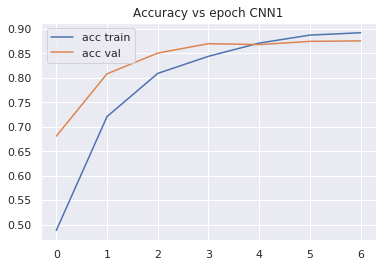


------ Training ------
Accuracy cnn1 : 0.9526768642447419
F1-score None cnn1 : [0.90768166 0.99741109 0.99700354 0.90815497]
F1-score macro cnn1 : 0.9525628162877094

------ Validation ------
Accuracy cnn1 : 0.8757647058823529
F1-score None cnn1 : [0.92525519 0.02666667 0.09302326 0.82739726]
F1-score macro cnn1 : 0.4680855921983617

------ Testing ------
Accuracy cnn1 : 0.8516250588789449
F1-score None cnn1 : [0.91639393 0.0862069  0.07228916 0.75801749]
F1-score macro cnn1 : 0.45822686906686605


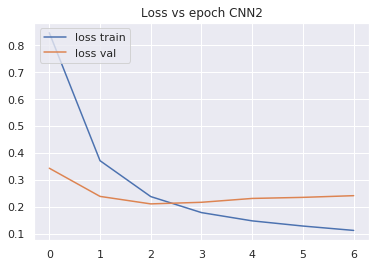

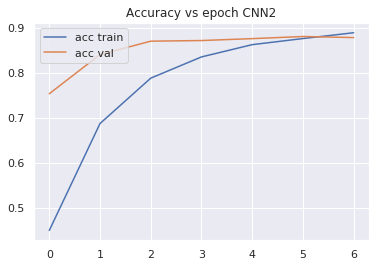


------ Training ------
Accuracy cnn2 : 0.9377902212510243
F1-score None cnn2 : [0.88538381 0.99496393 0.99659725 0.87288863]
F1-score macro cnn2 : 0.9374584055914332

------ Validation ------
Accuracy cnn2 : 0.8785882352941177
F1-score None cnn2 : [0.92579505 0.14117647 0.13953488 0.82656095]
F1-score macro cnn2 : 0.5082668396874415

------ Testing ------
Accuracy cnn2 : 0.833254828073481
F1-score None cnn2 : [0.90254358 0.13432836 0.11904762 0.66540643]
F1-score macro cnn2 : 0.4553314970897139


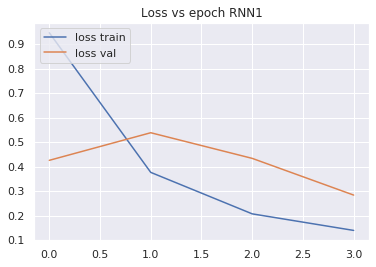

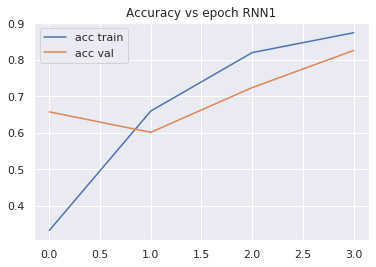


------ Training ------
Accuracy rnn1 : 0.9046025676044797
F1-score None rnn1 : [0.87402799 0.98350906 0.9266055  0.8270914 ]
F1-score macro rnn1 : 0.9028084899151817

------ Validation ------
Accuracy rnn1 : 0.8254117647058824
F1-score None rnn1 : [0.9190105  0.15503876 0.08284024 0.76123876]
F1-score macro rnn1 : 0.4795320656321657

------ Testing ------
Accuracy rnn1 : 0.8158266603862458
F1-score None rnn1 : [0.90740741 0.20304569 0.28037383 0.71260504]
F1-score macro rnn1 : 0.5258579916197756


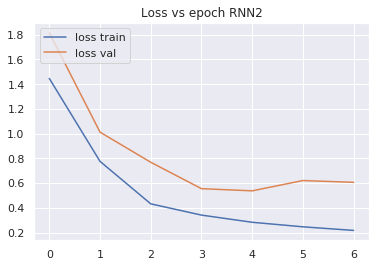

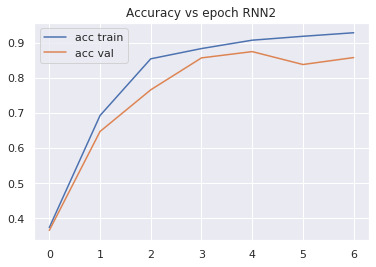


------ Training ------
Accuracy rnn2 : 0.9400437039060366
F1-score None rnn2 : [0.89070735 0.98903182 0.98595354 0.89257786]
F1-score macro rnn2 : 0.9395676419583665

------ Validation ------
Accuracy rnn2 : 0.8574117647058823
F1-score None rnn2 : [0.92085848 0.11666667 0.05       0.82397004]
F1-score macro rnn2 : 0.47787379708965405

------ Testing ------
Accuracy rnn2 : 0.8266603862458785
F1-score None rnn2 : [0.90131378 0.23350254 0.1958042  0.76777251]
F1-score macro rnn2 : 0.5245982562827186


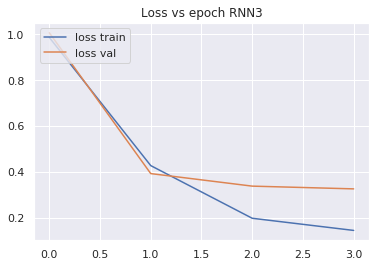

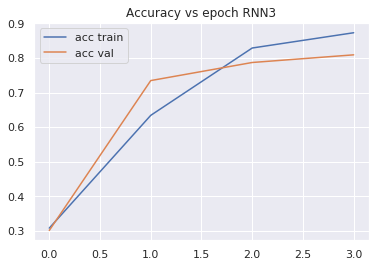


------ Training ------
Accuracy rnn3 : 0.9039196940726577
F1-score None rnn3 : [0.86419397 0.98321603 0.92067095 0.84095427]
F1-score macro rnn3 : 0.9022588056121486

------ Validation ------
Accuracy rnn3 : 0.8089411764705883
F1-score None rnn3 : [0.89811584 0.19310345 0.10152284 0.7831094 ]
F1-score macro rnn3 : 0.4939628841997725

------ Testing ------
Accuracy rnn3 : 0.7993405558172397
F1-score None rnn3 : [0.89142857 0.23       0.21686747 0.7511592 ]
F1-score macro rnn3 : 0.5223638093996653

Entrenando exec  5 



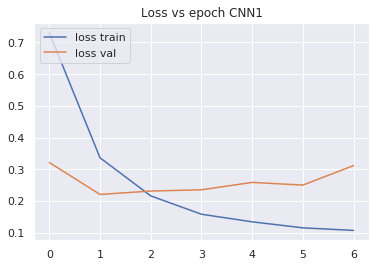

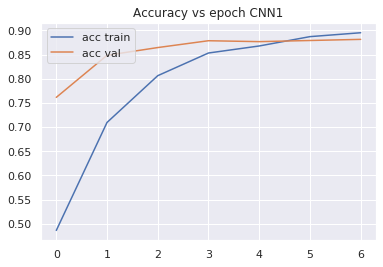


------ Training ------
Accuracy cnn1 : 0.9491942092324501
F1-score None cnn1 : [0.9015299  0.99630996 0.99549488 0.90343348]
F1-score macro cnn1 : 0.9491920556707787

------ Validation ------
Accuracy cnn1 : 0.8814117647058823
F1-score None cnn1 : [0.93052354 0.         0.09756098 0.83272727]
F1-score macro cnn1 : 0.4652029478267663

------ Testing ------
Accuracy cnn1 : 0.8549222797927462
F1-score None cnn1 : [0.91887073 0.01851852 0.07407407 0.76589595]
F1-score macro cnn1 : 0.4443398186082569


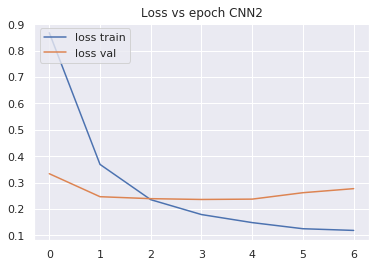

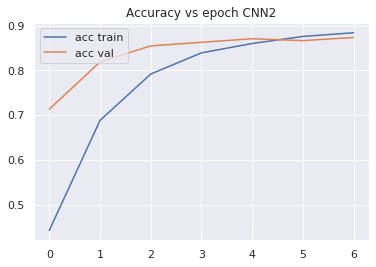


------ Training ------
Accuracy cnn2 : 0.9392925430210325
F1-score None cnn2 : [0.88728324 0.99686862 0.99563914 0.87630488]
F1-score macro cnn2 : 0.9390239675341379

------ Validation ------
Accuracy cnn2 : 0.8734117647058823
F1-score None cnn2 : [0.92347102 0.         0.09756098 0.81422925]
F1-score macro cnn2 : 0.45881531151883603

------ Testing ------
Accuracy cnn2 : 0.8417333961375412
F1-score None cnn2 : [0.90862364 0.01851852 0.07407407 0.69189189]
F1-score macro cnn2 : 0.42327703202917366


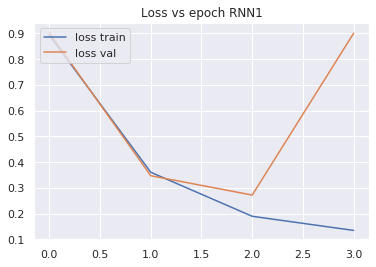

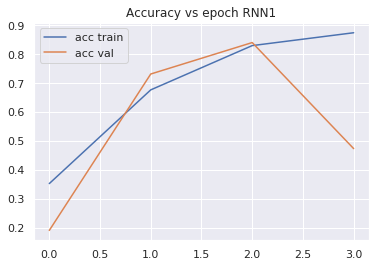


------ Training ------
Accuracy rnn1 : 0.765774378585086
F1-score None rnn1 : [0.68443104 0.79379879 0.8636909  0.66354329]
F1-score macro rnn1 : 0.7513660053249088

------ Validation ------
Accuracy rnn1 : 0.4738823529411765
F1-score None rnn1 : [0.6364037  0.1047836  0.06514658 0.57537688]
F1-score macro rnn1 : 0.3454276913467266

------ Testing ------
Accuracy rnn1 : 0.44653791804050874
F1-score None rnn1 : [0.61185309 0.15867159 0.25595238 0.4       ]
F1-score macro rnn1 : 0.35661926403726235


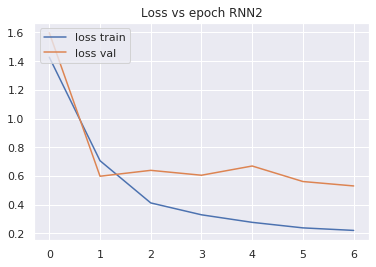

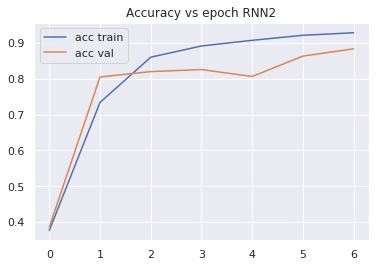


------ Training ------
Accuracy rnn2 : 0.9491259218792679
F1-score None rnn2 : [0.90271177 0.99290005 0.99318987 0.90733798]
F1-score macro rnn2 : 0.9490349165343134

------ Validation ------
Accuracy rnn2 : 0.8837647058823529
F1-score None rnn2 : [0.93328886 0.09090909 0.05       0.84341637]
F1-score macro rnn2 : 0.47940358006383643

------ Testing ------
Accuracy rnn2 : 0.8459726801695714
F1-score None rnn2 : [0.91454545 0.14084507 0.11428571 0.77539342]
F1-score macro rnn2 : 0.4862674146059869


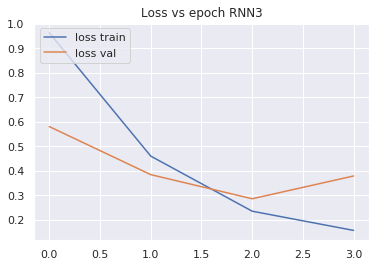

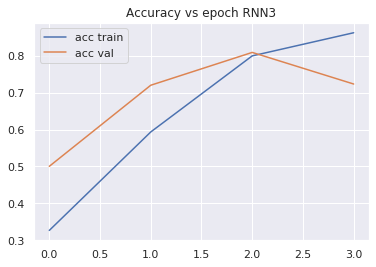


------ Training ------
Accuracy rnn3 : 0.866020213056542
F1-score None rnn3 : [0.7594401  0.95485137 0.94798796 0.79967838]
F1-score macro rnn3 : 0.8654894540213081

------ Validation ------
Accuracy rnn3 : 0.7232941176470589
F1-score None rnn3 : [0.80922596 0.11538462 0.07619048 0.66351989]
F1-score macro rnn3 : 0.4160802353662984

------ Testing ------
Accuracy rnn3 : 0.658502119642016
F1-score None rnn3 : [0.77552525 0.17105263 0.25287356 0.51532726]
F1-score macro rnn3 : 0.4286946753157577


In [27]:
fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

for i in range(1,6):    
    print ("\nEntrenando exec ", i,"\n")
    cnn1=create_ccn1(x_train.shape[1:])
    trained, hist =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=7, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/cnn1_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch CNN1")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch CNN1")
    plt.show()
    
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, n_labels, n_labels_val, n_labels_test, 'cnn1')
    fs_macro['cnn1'].append(f1_ma_t)
    fs_none['cnn1'].append(f1_t)
    accs['cnn1'].append(acc_t)
    confusions['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    trained, hist =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=7, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/cnn2_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch CNN2")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch CNN2")
    plt.show()
    
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'cnn2')
    fs_macro['cnn2'].append(f1_ma_t)
    fs_none['cnn2'].append(f1_t)
    accs['cnn2'].append(acc_t)
    confusions['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn1_'+str(i)+'-exec_8.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN1")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN1")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn1')
    fs_macro['rnn1'].append(f1_ma_t)
    fs_none['rnn1'].append(f1_t)
    accs['rnn1'].append(acc_t)
    confusions['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=7, BS=32, verb=0, focal=False)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn2_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN2")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN2")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn2')
    fs_macro['rnn2'].append(f1_ma_t)
    fs_none['rnn2'].append(f1_t)
    accs['rnn2'].append(acc_t)
    confusions['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn3_'+str(i)+'-exec_8.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN3")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN3")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn3')
    fs_macro['rnn3'].append(f1_ma_t)
    fs_none['rnn3'].append(f1_t)
    accs['rnn3'].append(acc_t)
    confusions['rnn3'].append(matriz_t)


In [28]:
print ("--------- Usando contexto positivo obligadamente y negativo cuando es posible ---------\n")

for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("0.15 BERT - F1-score promedio para",key,":" ,temp/5)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("0.15 BERT - F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("0.15 BERT - Accuracy promedio para",key,":" ,temp/5)

--------- Usando contexto positivo obligadamente y negativo cuando es posible ---------

0.15 BERT - F1-score promedio para cnn1 : [0.90426047 0.08022818 0.07837193 0.74221504]
0.15 BERT - F1-score promedio para cnn2 : [0.91299299 0.06135639 0.08655924 0.72863785]
0.15 BERT - F1-score promedio para rnn1 : [0.82602812 0.22430447 0.26366498 0.64131724]
0.15 BERT - F1-score promedio para rnn2 : [0.90581256 0.14246785 0.12675442 0.76212427]
0.15 BERT - F1-score promedio para rnn3 : [0.83360698 0.20278774 0.23777179 0.67334828]

0.15 BERT - F1-score macro promedio para cnn1 : 0.45126890385618745 desvest:  0.029222362813508495
0.15 BERT - F1-score macro promedio para cnn2 : 0.447386618234858 desvest:  0.014271581646878502
0.15 BERT - F1-score macro promedio para rnn1 : 0.4888287034521788 desvest:  0.06897652589115749
0.15 BERT - F1-score macro promedio para rnn2 : 0.4842897782980099 desvest:  0.024152000690928564
0.15 BERT - F1-score macro promedio para rnn3 : 0.4868786988230899 desvest:  0.

## Baselines 50% - 85% 

In [13]:
macro_augmented = np.load('../Datasets/CSV_Harassment/Aumento_ofi/balance_GloVe_50.npy', allow_pickle=True)

np.random.shuffle(macro_augmented)

ids_train=macro_augmented[:,0]
tws_train=macro_augmented[:,1]
labels_train=macro_augmented[:,2]
class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
print ("Pesos de clases:", class_weights)

sentences = tws_train
n_labels = labels_train.copy()

input_ids = []
for sent in sentences:
    encoded_sent = [] 
    for wd in sent:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids.append(encoded_sent)

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")
y_train=to_categorical(n_labels,num_classes=4)
shape=np.asarray(input_ids).shape
x_train=np.zeros((shape[0], shape[1], emb))
j=0
for in_id in input_ids:
    x_train[j]=EMB_matrix[in_id]
    j+=1

Pesos de clases: [1. 1. 1. 1.]



Entrenando exec  1 






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


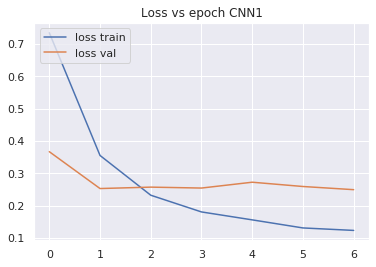

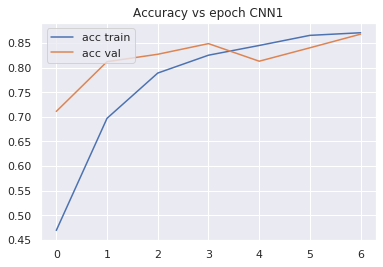


------ Training ------
Accuracy cnn1 : 0.9420240371483202
F1-score None cnn1 : [0.88977242 0.99361153 0.99493359 0.88955549]
F1-score macro cnn1 : 0.9419682565031471

------ Validation ------
Accuracy cnn1 : 0.8682352941176471
F1-score None cnn1 : [0.921797   0.18348624 0.04651163 0.82159195]
F1-score macro cnn1 : 0.4933467050489087

------ Testing ------
Accuracy cnn1 : 0.832312764955252
F1-score None cnn1 : [0.90310786 0.12865497 0.07317073 0.76230661]
F1-score macro cnn1 : 0.46681004348393906


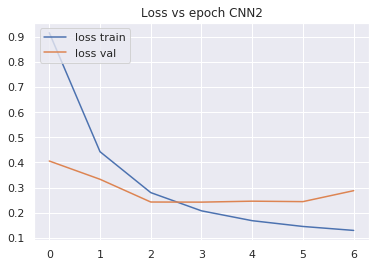

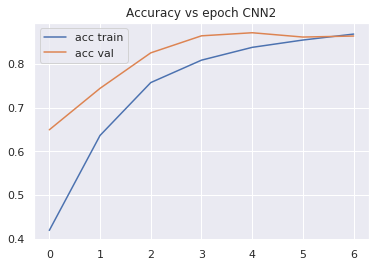


------ Training ------
Accuracy cnn2 : 0.9354001638896476
F1-score None cnn2 : [0.88676863 0.99438894 0.98084398 0.88156863]
F1-score macro cnn2 : 0.935892542870228

------ Validation ------
Accuracy cnn2 : 0.8644705882352941
F1-score None cnn2 : [0.9197031  0.         0.04651163 0.80923867]
F1-score macro cnn2 : 0.4438633493366744

------ Testing ------
Accuracy cnn2 : 0.8422044276966557
F1-score None cnn2 : [0.91171947 0.         0.09411765 0.75594493]
F1-score macro cnn2 : 0.4404455122886999


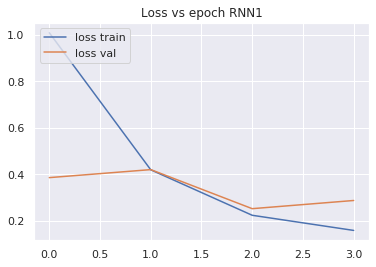

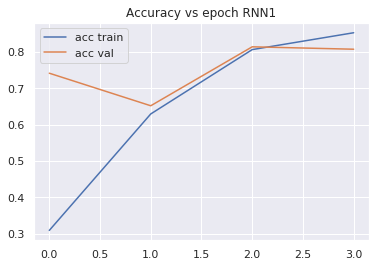


------ Training ------
Accuracy rnn1 : 0.8819994537011745
F1-score None rnn1 : [0.83502715 0.96514965 0.91540404 0.80401864]
F1-score macro rnn1 : 0.879899869122456

------ Validation ------
Accuracy rnn1 : 0.8070588235294117
F1-score None rnn1 : [0.90051635 0.16901408 0.08290155 0.76633663]
F1-score macro rnn1 : 0.47969215592332864

------ Testing ------
Accuracy rnn1 : 0.7899199246349505
F1-score None rnn1 : [0.88642132 0.25806452 0.23255814 0.71728595]
F1-score macro rnn1 : 0.5235824801333919


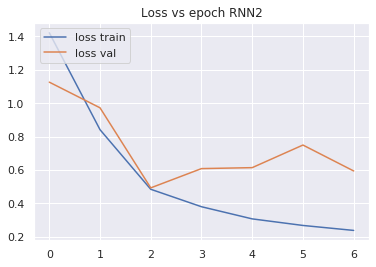

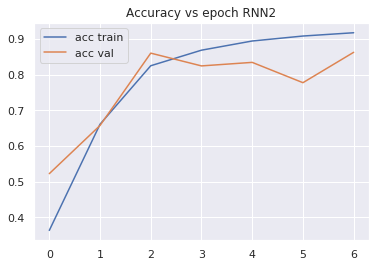


------ Training ------
Accuracy rnn2 : 0.9289811526905217
F1-score None rnn2 : [0.87861577 0.99152542 0.98254096 0.86067577]
F1-score macro rnn2 : 0.9283394822120592

------ Validation ------
Accuracy rnn2 : 0.8625882352941177
F1-score None rnn2 : [0.92513893 0.09302326 0.08988764 0.80708661]
F1-score macro rnn2 : 0.4787841111822181

------ Testing ------
Accuracy rnn2 : 0.832312764955252
F1-score None rnn2 : [0.90871246 0.09859155 0.22377622 0.72240803]
F1-score macro rnn2 : 0.48837206473543443


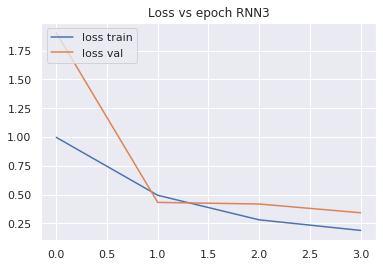

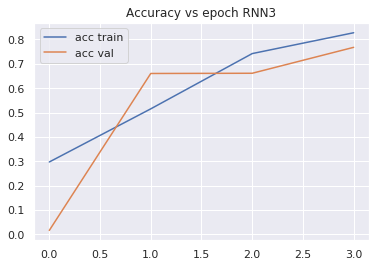


------ Training ------
Accuracy rnn3 : 0.8772193389784212
F1-score None rnn3 : [0.83435217 0.95193189 0.91797024 0.79203727]
F1-score macro rnn3 : 0.8740728936709121

------ Validation ------
Accuracy rnn3 : 0.7675294117647059
F1-score None rnn3 : [0.87549621 0.2038835  0.05617978 0.71598174]
F1-score macro rnn3 : 0.4628853040851469

------ Testing ------
Accuracy rnn3 : 0.7399905793688177
F1-score None rnn3 : [0.85608108 0.24767802 0.25423729 0.6437414 ]
F1-score macro rnn3 : 0.5004344477046652

Entrenando exec  2 



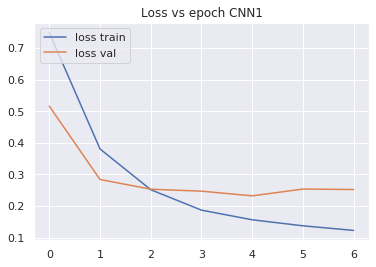

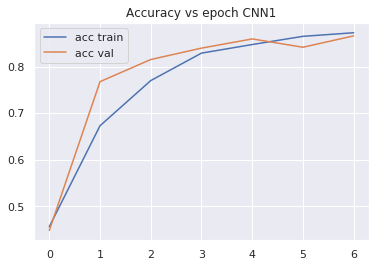


------ Training ------
Accuracy cnn1 : 0.9423654739142311
F1-score None cnn1 : [0.89058807 0.9955047  0.99261286 0.89065019]
F1-score macro cnn1 : 0.9423389546341674

------ Validation ------
Accuracy cnn1 : 0.8658823529411764
F1-score None cnn1 : [0.92292158 0.14736842 0.0952381  0.8056042 ]
F1-score macro cnn1 : 0.49278307366757185

------ Testing ------
Accuracy cnn1 : 0.8360810174281676
F1-score None cnn1 : [0.90909091 0.14864865 0.06818182 0.75222363]
F1-score macro cnn1 : 0.46953625249368575


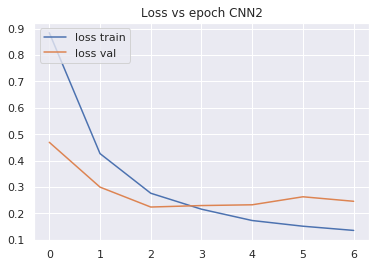

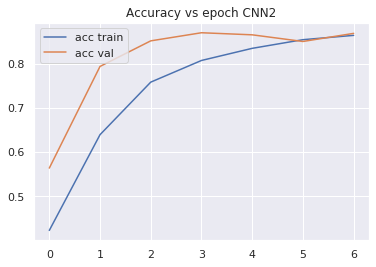


------ Training ------
Accuracy cnn2 : 0.9195574979513794
F1-score None cnn2 : [0.85688956 0.99537667 0.99427793 0.82830696]
F1-score macro cnn2 : 0.9187127791381259

------ Validation ------
Accuracy cnn2 : 0.8687058823529412
F1-score None cnn2 : [0.91998725 0.09638554 0.04878049 0.80485339]
F1-score macro cnn2 : 0.4675016665493474

------ Testing ------
Accuracy cnn2 : 0.8313707018370231
F1-score None cnn2 : [0.90127021 0.08695652 0.11764706 0.69051878]
F1-score macro cnn2 : 0.44909814298922335


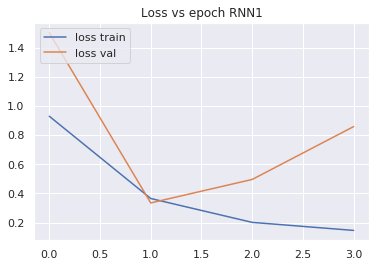

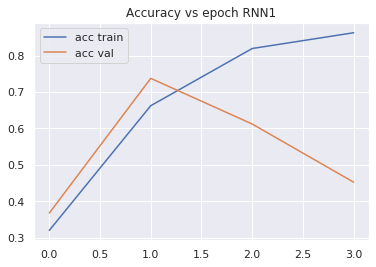


------ Training ------
Accuracy rnn1 : 0.7771783665665118
F1-score None rnn1 : [0.60097051 0.78318537 0.90978206 0.75347586]
F1-score macro rnn1 : 0.7618534481166608

------ Validation ------
Accuracy rnn1 : 0.4527058823529412
F1-score None rnn1 : [0.55571497 0.10669456 0.05319149 0.64039409]
F1-score macro rnn1 : 0.338998776903876

------ Testing ------
Accuracy rnn1 : 0.4262835609985869
F1-score None rnn1 : [0.55224544 0.15205725 0.1843318  0.5407855 ]
F1-score macro rnn1 : 0.3573549958059507


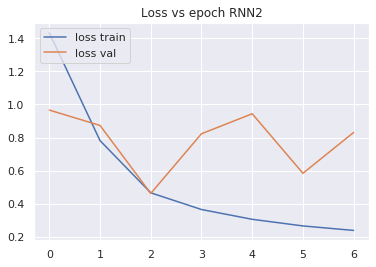

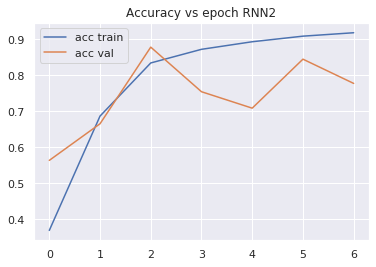


------ Training ------
Accuracy rnn2 : 0.9123190385140671
F1-score None rnn2 : [0.83129357 0.98869364 0.94721863 0.87271322]
F1-score macro rnn2 : 0.9099797640765401

------ Validation ------
Accuracy rnn2 : 0.7774117647058824
F1-score None rnn2 : [0.86426999 0.1512605  0.03488372 0.74939173]
F1-score macro rnn2 : 0.44995148632226833

------ Testing ------
Accuracy rnn2 : 0.7324540744229864
F1-score None rnn2 : [0.84004128 0.15662651 0.26804124 0.63945578]
F1-score macro rnn2 : 0.47604120128004646


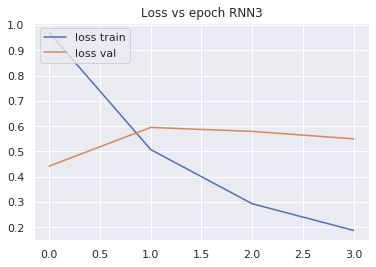

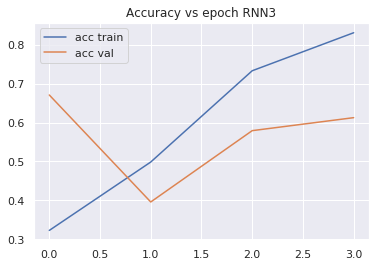


------ Training ------
Accuracy rnn3 : 0.8012838022398252
F1-score None rnn3 : [0.74896488 0.85550486 0.87263863 0.68362427]
F1-score macro rnn3 : 0.790183161455484

------ Validation ------
Accuracy rnn3 : 0.6127058823529412
F1-score None rnn3 : [0.76983197 0.12341198 0.0669145  0.62916188]
F1-score macro rnn3 : 0.39733008121686814

------ Testing ------
Accuracy rnn3 : 0.5967969853980216
F1-score None rnn3 : [0.75413451 0.20679887 0.16551724 0.54442344]
F1-score macro rnn3 : 0.41771851451501874

Entrenando exec  3 



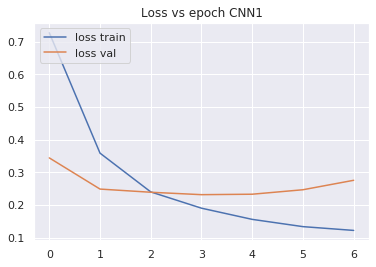

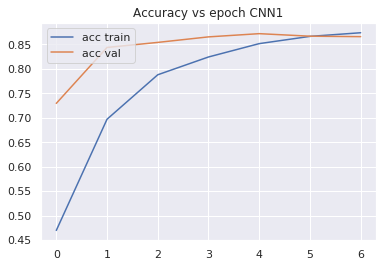


------ Training ------
Accuracy cnn1 : 0.92549849767823
F1-score None cnn1 : [0.86756482 0.99754568 0.99362193 0.83995831]
F1-score macro cnn1 : 0.9246726854042849

------ Validation ------
Accuracy cnn1 : 0.8658823529411764
F1-score None cnn1 : [0.92077633 0.         0.07692308 0.79633401]
F1-score macro cnn1 : 0.4485083543729369

------ Testing ------
Accuracy cnn1 : 0.826189354686764
F1-score None cnn1 : [0.89994315 0.         0.1443299  0.62715105]
F1-score macro cnn1 : 0.41785602451230663


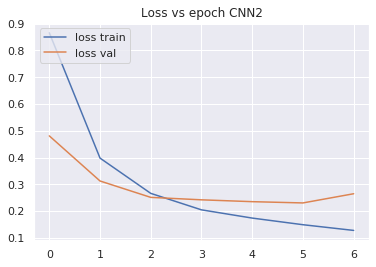

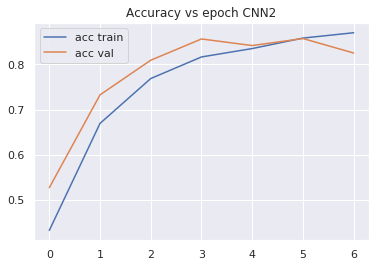


------ Training ------
Accuracy cnn2 : 0.9382682327232996
F1-score None cnn2 : [0.88390464 0.99092756 0.99132791 0.88512241]
F1-score macro cnn2 : 0.9378206301687064

------ Validation ------
Accuracy cnn2 : 0.8254117647058824
F1-score None cnn2 : [0.89504676 0.16666667 0.09876543 0.78383128]
F1-score macro cnn2 : 0.48607753576548407

------ Testing ------
Accuracy cnn2 : 0.8059349976448422
F1-score None cnn2 : [0.88803828 0.18604651 0.23188406 0.74670185]
F1-score macro cnn2 : 0.5131676735191455


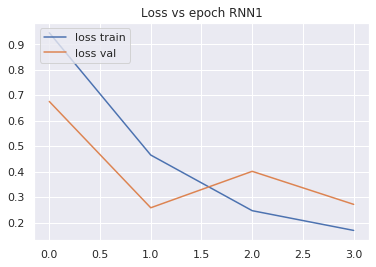

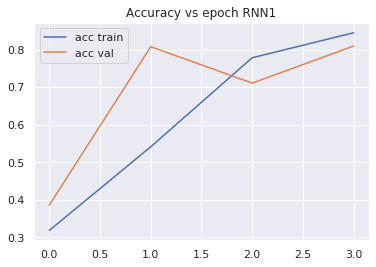


------ Training ------
Accuracy rnn1 : 0.8790630975143403
F1-score None rnn1 : [0.82721527 0.95502367 0.92682927 0.80624655]
F1-score macro rnn1 : 0.8788286900183442

------ Validation ------
Accuracy rnn1 : 0.8094117647058824
F1-score None rnn1 : [0.88295688 0.168      0.03921569 0.79454722]
F1-score macro rnn1 : 0.47117994751289605

------ Testing ------
Accuracy rnn1 : 0.7706076307112577
F1-score None rnn1 : [0.86496815 0.27067669 0.18018018 0.71812081]
F1-score macro rnn1 : 0.5084864575362182


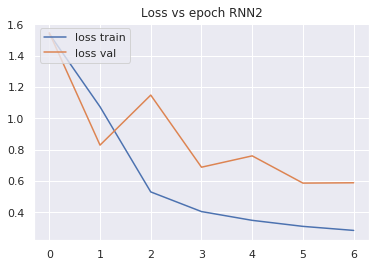

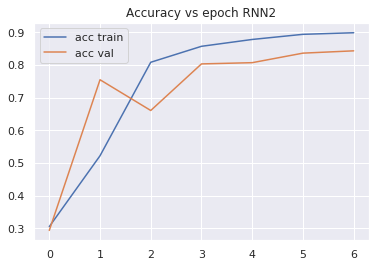


------ Training ------
Accuracy rnn2 : 0.8550259491942093
F1-score None rnn2 : [0.77840524 0.98151397 0.90239905 0.76362484]
F1-score macro rnn2 : 0.8564857735523232

------ Validation ------
Accuracy rnn2 : 0.843764705882353
F1-score None rnn2 : [0.9078906  0.17460317 0.04444444 0.75055679]
F1-score macro rnn2 : 0.46937375309019586

------ Testing ------
Accuracy rnn2 : 0.7918040508714084
F1-score None rnn2 : [0.8809795  0.12834225 0.         0.52136752]
F1-score macro rnn2 : 0.3826723165544685


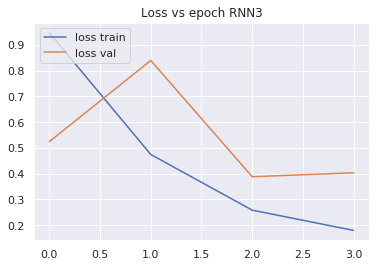

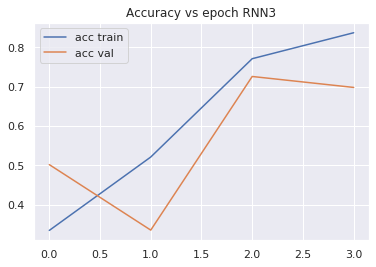


------ Training ------
Accuracy rnn3 : 0.8733269598470363
F1-score None rnn3 : [0.77217613 0.91930001 0.94822525 0.83476197]
F1-score macro rnn3 : 0.8686158399376471

------ Validation ------
Accuracy rnn3 : 0.6978823529411765
F1-score None rnn3 : [0.79104478 0.11970075 0.05714286 0.74958264]
F1-score macro rnn3 : 0.4293677547803713

------ Testing ------
Accuracy rnn3 : 0.659444182760245
F1-score None rnn3 : [0.76866223 0.20229008 0.26829268 0.66901408]
F1-score macro rnn3 : 0.4770647689616539

Entrenando exec  4 



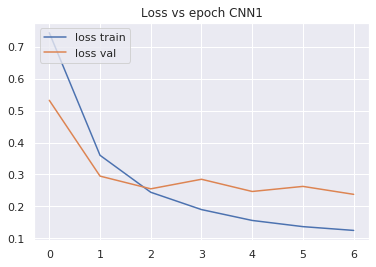

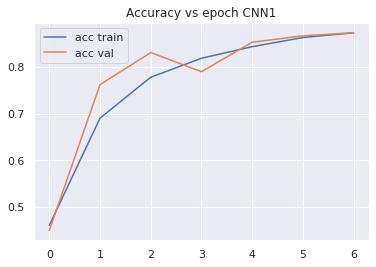


------ Training ------
Accuracy cnn1 : 0.9397705544933078
F1-score None cnn1 : [0.88782621 0.9942826  0.99348711 0.88239349]
F1-score macro cnn1 : 0.9394973526989627

------ Validation ------
Accuracy cnn1 : 0.8729411764705882
F1-score None cnn1 : [0.92577866 0.21153846 0.03921569 0.82822656]
F1-score macro cnn1 : 0.5011898411060419

------ Testing ------
Accuracy cnn1 : 0.8360810174281676
F1-score None cnn1 : [0.9069141  0.1242236  0.15533981 0.7550702 ]
F1-score macro cnn1 : 0.48538692717335075


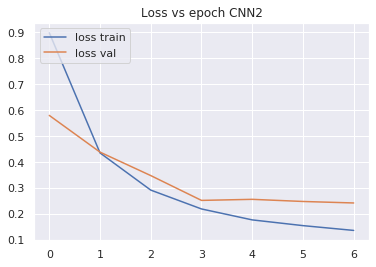

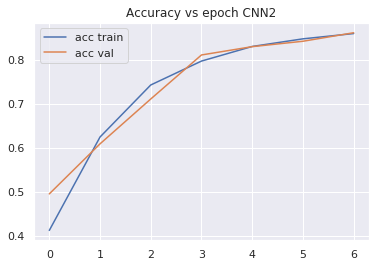


------ Training ------
Accuracy cnn2 : 0.9314394974050806
F1-score None cnn2 : [0.88073148 0.99293478 0.9854565  0.86397735]
F1-score macro cnn2 : 0.9307750294197371

------ Validation ------
Accuracy cnn2 : 0.8607058823529412
F1-score None cnn2 : [0.92002644 0.21238938 0.06060606 0.80956938]
F1-score macro cnn2 : 0.5006478141671933

------ Testing ------
Accuracy cnn2 : 0.8276024493641074
F1-score None cnn2 : [0.9019725  0.14457831 0.18032787 0.73529412]
F1-score macro cnn2 : 0.49054320105887367


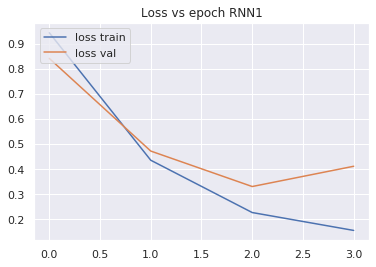

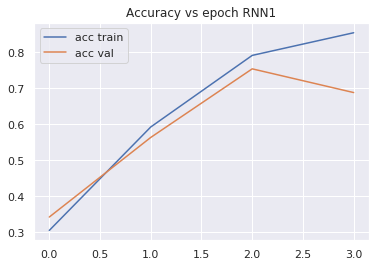


------ Training ------
Accuracy rnn1 : 0.8774242010379678
F1-score None rnn1 : [0.77809891 0.97300945 0.93869633 0.80626421]
F1-score macro rnn1 : 0.8740172224841648

------ Validation ------
Accuracy rnn1 : 0.6884705882352942
F1-score None rnn1 : [0.79110405 0.20645161 0.03571429 0.63591199]
F1-score macro rnn1 : 0.41729548594343024

------ Testing ------
Accuracy rnn1 : 0.6368346679227508
F1-score None rnn1 : [0.76265467 0.19626168 0.184      0.52197309]
F1-score macro rnn1 : 0.41622236114496836


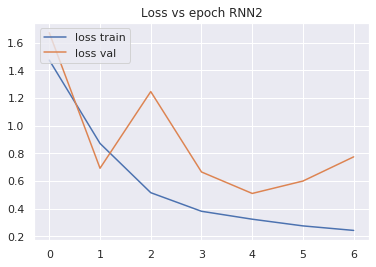

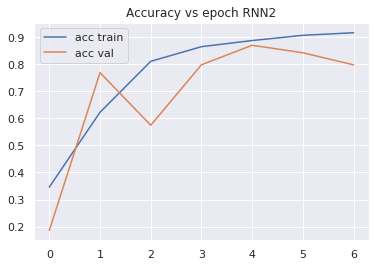


------ Training ------
Accuracy rnn2 : 0.9278885550396067
F1-score None rnn2 : [0.87860112 0.95825154 0.98809202 0.88214286]
F1-score macro rnn2 : 0.9267718822742158

------ Validation ------
Accuracy rnn2 : 0.7976470588235294
F1-score None rnn2 : [0.8796034  0.14814815 0.05479452 0.79593721]
F1-score macro rnn2 : 0.4696208198947995

------ Testing ------
Accuracy rnn2 : 0.7583608101742817
F1-score None rnn2 : [0.85892798 0.2        0.25503356 0.72303207]
F1-score macro rnn2 : 0.5092484028083859


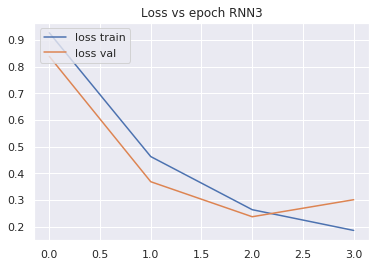

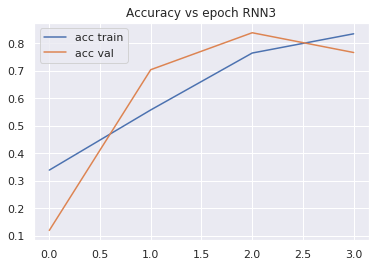


------ Training ------
Accuracy rnn3 : 0.8648593280524447
F1-score None rnn3 : [0.81624641 0.94986326 0.88964699 0.80446385]
F1-score macro rnn3 : 0.8650551297450884

------ Validation ------
Accuracy rnn3 : 0.7670588235294118
F1-score None rnn3 : [0.84718101 0.19672131 0.03773585 0.73667462]
F1-score macro rnn3 : 0.45457819788756004

------ Testing ------
Accuracy rnn3 : 0.7371643900141309
F1-score None rnn3 : [0.83772538 0.25344353 0.26666667 0.67121729]
F1-score macro rnn3 : 0.5072632166574673

Entrenando exec  5 



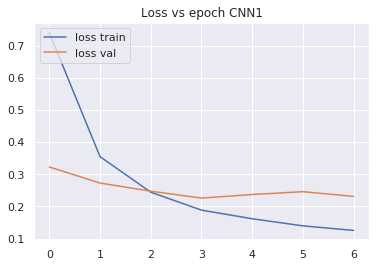

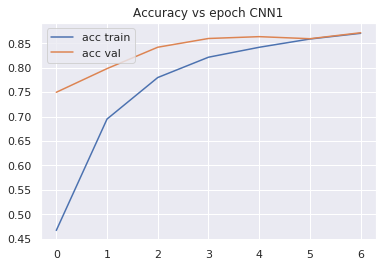


------ Training ------
Accuracy cnn1 : 0.9362196121278339
F1-score None cnn1 : [0.8818543  0.99536911 0.99495844 0.87175854]
F1-score macro cnn1 : 0.9359850981742613

------ Validation ------
Accuracy cnn1 : 0.8715294117647059
F1-score None cnn1 : [0.92297693 0.16161616 0.09090909 0.81941748]
F1-score macro cnn1 : 0.4987299134575671

------ Testing ------
Accuracy cnn1 : 0.833254828073481
F1-score None cnn1 : [0.90563833 0.09589041 0.04651163 0.7106599 ]
F1-score macro cnn1 : 0.43967506657356265


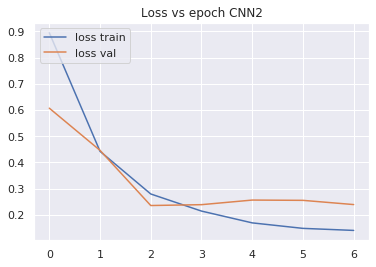

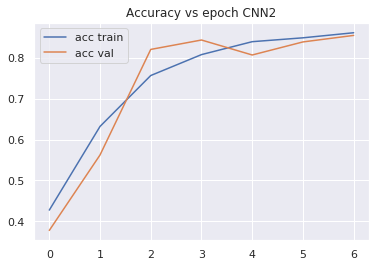


------ Training ------
Accuracy cnn2 : 0.933010106528271
F1-score None cnn2 : [0.8817292  0.98440441 0.99054406 0.87397527]
F1-score macro cnn2 : 0.932663234278769

------ Validation ------
Accuracy cnn2 : 0.8555294117647059
F1-score None cnn2 : [0.91346475 0.24096386 0.04878049 0.81904762]
F1-score macro cnn2 : 0.5055641783400127

------ Testing ------
Accuracy cnn2 : 0.8101742816768723
F1-score None cnn2 : [0.88970814 0.22878229 0.13793103 0.74249605]
F1-score macro cnn2 : 0.49972937854490107


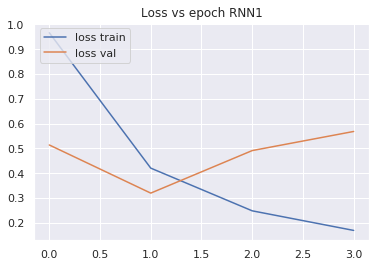

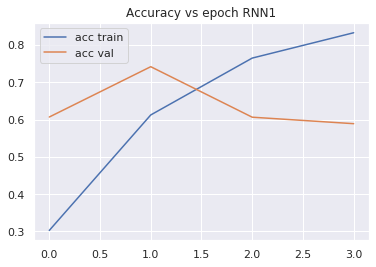


------ Training ------
Accuracy rnn1 : 0.7695984703632888
F1-score None rnn1 : [0.73504845 0.95271359 0.75360231 0.60664279]
F1-score macro rnn1 : 0.7620017835143852

------ Validation ------
Accuracy rnn1 : 0.5891764705882353
F1-score None rnn1 : [0.77591707 0.125      0.05177994 0.53164557]
F1-score macro rnn1 : 0.3710856425715209

------ Testing ------
Accuracy rnn1 : 0.598210080075365
F1-score None rnn1 : [0.75998507 0.23015873 0.17682927 0.50075873]
F1-score macro rnn1 : 0.41693294821211435


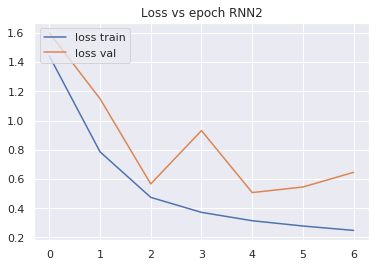

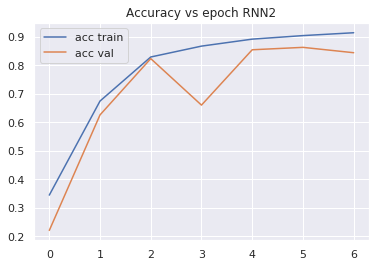


------ Training ------
Accuracy rnn2 : 0.9199672220704725
F1-score None rnn2 : [0.88145556 0.97257207 0.95174925 0.8727422 ]
F1-score macro rnn2 : 0.9196297710319493

------ Validation ------
Accuracy rnn2 : 0.8447058823529412
F1-score None rnn2 : [0.92       0.05263158 0.09210526 0.80037313]
F1-score macro rnn2 : 0.46627749410840535

------ Testing ------
Accuracy rnn2 : 0.8082901554404145
F1-score None rnn2 : [0.8989742  0.03508772 0.2173913  0.70948905]
F1-score macro rnn2 : 0.46523556857644355


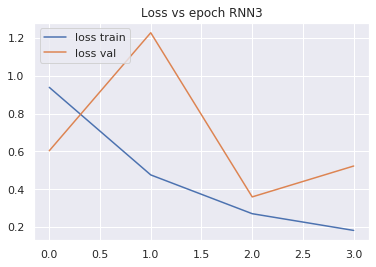

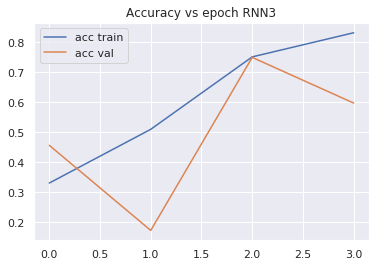


------ Training ------
Accuracy rnn3 : 0.7988254575252663
F1-score None rnn3 : [0.7661853  0.92633447 0.80877951 0.65497829]
F1-score macro rnn3 : 0.789069393407924

------ Validation ------
Accuracy rnn3 : 0.5976470588235294
F1-score None rnn3 : [0.76830249 0.13978495 0.06930693 0.55668016]
F1-score macro rnn3 : 0.38351863320978974

------ Testing ------
Accuracy rnn3 : 0.5953838907206783
F1-score None rnn3 : [0.75255779 0.2268431  0.22772277 0.48961424]
F1-score macro rnn3 : 0.4241844757075629


In [14]:
fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

for i in range(1,6):    
    print ("\nEntrenando exec ", i,"\n")
    cnn1=create_ccn1(x_train.shape[1:])
    trained, hist =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=7, BS=32, verb=0, focal=True)
    trained.save('../Datasets/Models_Harassment/0.5/cnn1_'+str(i)+'-exec.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch CNN1")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch CNN1")
    plt.show()
    
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, n_labels, n_labels_val, n_labels_test, 'cnn1')
    fs_macro['cnn1'].append(f1_ma_t)
    fs_none['cnn1'].append(f1_t)
    accs['cnn1'].append(acc_t)
    confusions['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    trained, hist =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=7, BS=32, verb=0, focal=True)
    trained.save('../Datasets/Models_Harassment/0.5/cnn2_'+str(i)+'-exec.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch CNN2")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch CNN2")
    plt.show()
    
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'cnn2')
    fs_macro['cnn2'].append(f1_ma_t)
    fs_none['cnn2'].append(f1_t)
    accs['cnn2'].append(acc_t)
    confusions['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    trained.save('../Datasets/Models_Harassment/0.5/rnn1_'+str(i)+'-exec.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN1")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN1")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn1')
    fs_macro['rnn1'].append(f1_ma_t)
    fs_none['rnn1'].append(f1_t)
    accs['rnn1'].append(acc_t)
    confusions['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=7, BS=32, verb=0, focal=False)
    trained.save('../Datasets/Models_Harassment/0.5/rnn2_'+str(i)+'-exec.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN2")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN2")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn2')
    fs_macro['rnn2'].append(f1_ma_t)
    fs_none['rnn2'].append(f1_t)
    accs['rnn2'].append(acc_t)
    confusions['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    trained.save('../Datasets/Models_Harassment/0.5/rnn3_'+str(i)+'-exec.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN3")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN3")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn3')
    fs_macro['rnn3'].append(f1_ma_t)
    fs_none['rnn3'].append(f1_t)
    accs['rnn3'].append(acc_t)
    confusions['rnn3'].append(matriz_t)


In [15]:
print ("--------- Usando contexto positivo y negativo obligadamente ---------\n")

for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("0.5 Clase Ponderado - F1-score promedio para",key,":" ,temp/5)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("0.5 Clase Ponderado - F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("0.5 Clase Ponderado - Accuracy promedio para",key,":" ,temp/5)

--------- Usando contexto positivo y negativo obligadamente ---------

0.5 Clase Ponderado - F1-score promedio para cnn1 : [0.90493887 0.09948353 0.09750678 0.72148228]
0.5 Clase Ponderado - F1-score promedio para cnn2 : [0.89854172 0.12927273 0.15238153 0.73419115]
0.5 Clase Ponderado - F1-score promedio para rnn1 : [0.76525493 0.22144377 0.19157988 0.59978481]
0.5 Clase Ponderado - F1-score promedio para rnn2 : [0.87752708 0.1237296  0.19284846 0.66315049]
0.5 Clase Ponderado - F1-score promedio para rnn3 : [0.7938322  0.22741072 0.23648733 0.60360209]

0.5 Clase Ponderado - F1-score macro promedio para cnn1 : 0.4558528628473689 desvest:  0.024020977211863092
0.5 Clase Ponderado - F1-score macro promedio para cnn2 : 0.4785967816801687 desvest:  0.028671027848895792
0.5 Clase Ponderado - F1-score macro promedio para rnn1 : 0.4445158485665287 desvest:  0.06245337959737603
0.5 Clase Ponderado - F1-score macro promedio para rnn2 : 0.46431391079095585 desvest:  0.043362730653972954
0.5 Cl

#### 0.85 masking

In [16]:
macro_augmented = np.load('../Datasets/CSV_Harassment/Aumento_ofi/balance_GloVe_85.npy', allow_pickle=True)

np.random.shuffle(macro_augmented)

ids_train=macro_augmented[:,0]
tws_train=macro_augmented[:,1]
labels_train=macro_augmented[:,2]
class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
print ("Pesos de clases:", class_weights)

sentences = tws_train
n_labels = labels_train.copy()

input_ids = []
for sent in sentences:
    encoded_sent = [] 
    for wd in sent:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids.append(encoded_sent)

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")
y_train=to_categorical(n_labels,num_classes=4)
shape=np.asarray(input_ids).shape
x_train=np.zeros((shape[0], shape[1], emb))
j=0
for in_id in input_ids:
    x_train[j]=EMB_matrix[in_id]
    j+=1

Pesos de clases: [1. 1. 1. 1.]



Entrenando exec  1 



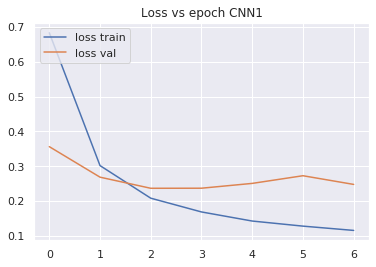

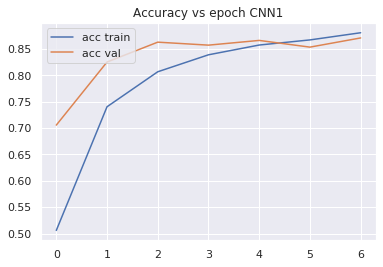


------ Training ------
Accuracy cnn1 : 0.9366293362469271
F1-score None cnn1 : [0.88401171 0.99537037 0.99065421 0.87664336]
F1-score macro cnn1 : 0.9366699094654898

------ Validation ------
Accuracy cnn1 : 0.8705882352941177
F1-score None cnn1 : [0.92267366 0.12244898 0.05       0.82075472]
F1-score macro cnn1 : 0.4789693382978949

------ Testing ------
Accuracy cnn1 : 0.8403203014601979
F1-score None cnn1 : [0.90903756 0.08955224 0.         0.73633441]
F1-score macro cnn1 : 0.43373105065902773


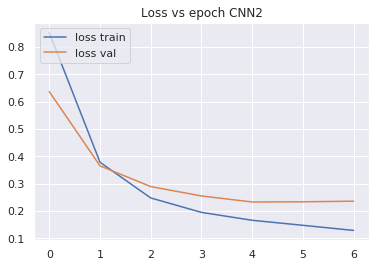

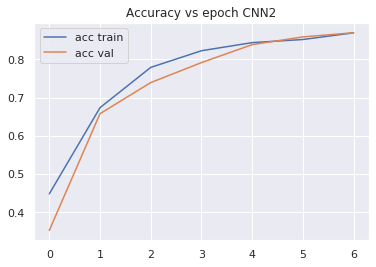


------ Training ------
Accuracy cnn2 : 0.9305517618137121
F1-score None cnn2 : [0.87585843 0.99131379 0.99319357 0.86003999]
F1-score macro cnn2 : 0.9301014446119552

------ Validation ------
Accuracy cnn2 : 0.8696470588235294
F1-score None cnn2 : [0.92443572 0.14285714 0.11538462 0.81495686]
F1-score macro cnn2 : 0.49940858369061436

------ Testing ------
Accuracy cnn2 : 0.8318417333961375
F1-score None cnn2 : [0.90332236 0.12716763 0.15217391 0.746875  ]
F1-score macro cnn2 : 0.4823847254191397


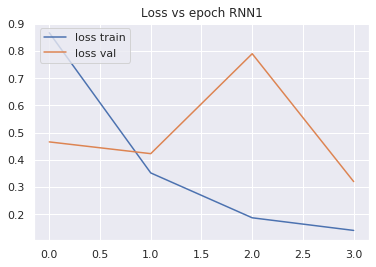

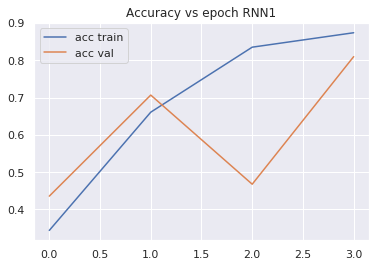


------ Training ------
Accuracy rnn1 : 0.9048074296640263
F1-score None rnn1 : [0.8417203  0.97031617 0.95400928 0.85073069]
F1-score macro rnn1 : 0.9041941095520232

------ Validation ------
Accuracy rnn1 : 0.8098823529411765
F1-score None rnn1 : [0.8899115  0.13333333 0.05263158 0.74529075]
F1-score macro rnn1 : 0.4552917904990565

------ Testing ------
Accuracy rnn1 : 0.7767310409797457
F1-score None rnn1 : [0.87345075 0.09459459 0.24858757 0.65730994]
F1-score macro rnn1 : 0.46848571422490254


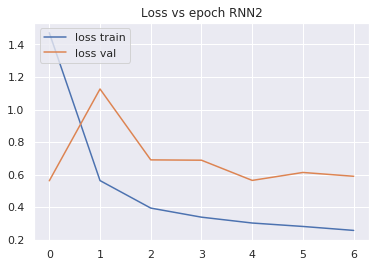

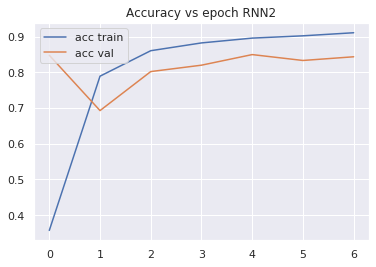


------ Training ------
Accuracy rnn2 : 0.9334198306473641
F1-score None rnn2 : [0.8849184  0.97879811 0.98261342 0.88574127]
F1-score macro rnn2 : 0.9330177991993087

------ Validation ------
Accuracy rnn2 : 0.8432941176470589
F1-score None rnn2 : [0.90489318 0.24390244 0.04761905 0.83090909]
F1-score macro rnn2 : 0.5068309386679393

------ Testing ------
Accuracy rnn2 : 0.7941592086669806
F1-score None rnn2 : [0.87918393 0.19047619 0.2384106  0.76788321]
F1-score macro rnn2 : 0.5189884829690313


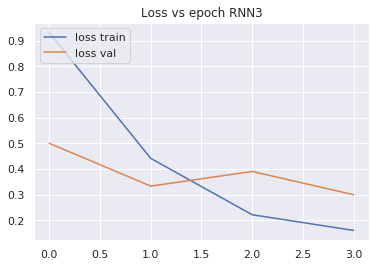

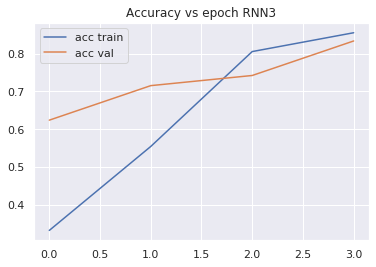


------ Training ------
Accuracy rnn3 : 0.8605572248019667
F1-score None rnn3 : [0.8248997  0.87935494 0.92199847 0.81433772]
F1-score macro rnn3 : 0.8601477075725172

------ Validation ------
Accuracy rnn3 : 0.8334117647058824
F1-score None rnn3 : [0.91384512 0.04651163 0.05128205 0.78439024]
F1-score macro rnn3 : 0.44900726136287683

------ Testing ------
Accuracy rnn3 : 0.8153556288271314
F1-score None rnn3 : [0.90236507 0.03125    0.21319797 0.70626003]
F1-score macro rnn3 : 0.46326826784627795

Entrenando exec  2 



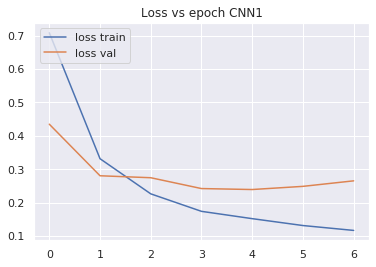

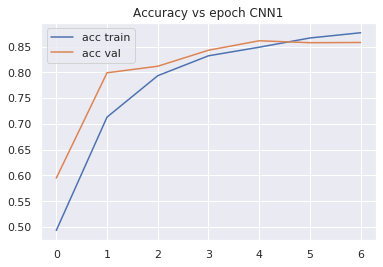


------ Training ------
Accuracy cnn1 : 0.9416143130292269
F1-score None cnn1 : [0.88866995 0.99482571 0.9921757  0.89091872]
F1-score macro cnn1 : 0.9416475202149912

------ Validation ------
Accuracy cnn1 : 0.8578823529411764
F1-score None cnn1 : [0.9157036  0.17021277 0.04761905 0.79692833]
F1-score macro cnn1 : 0.482615936053177

------ Testing ------
Accuracy cnn1 : 0.8290155440414507
F1-score None cnn1 : [0.90594059 0.11612903 0.         0.74160207]
F1-score macro cnn1 : 0.4409179233752333


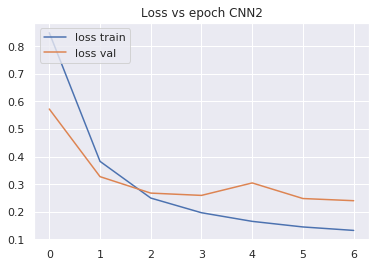

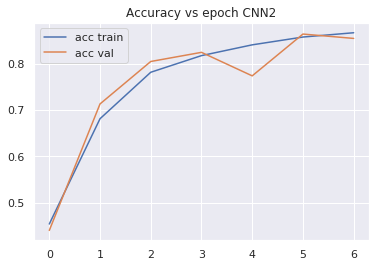


------ Training ------
Accuracy cnn2 : 0.9313712100518984
F1-score None cnn2 : [0.87708974 0.99064407 0.98868966 0.86919009]
F1-score macro cnn2 : 0.9314033891723406

------ Validation ------
Accuracy cnn2 : 0.8550588235294118
F1-score None cnn2 : [0.91196835 0.0952381  0.05128205 0.81178707]
F1-score macro cnn2 : 0.4675688917334053

------ Testing ------
Accuracy cnn2 : 0.8219500706547339
F1-score None cnn2 : [0.89783654 0.13684211 0.06976744 0.73208723]
F1-score macro cnn2 : 0.45913332824987285


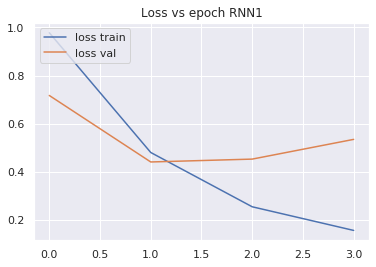

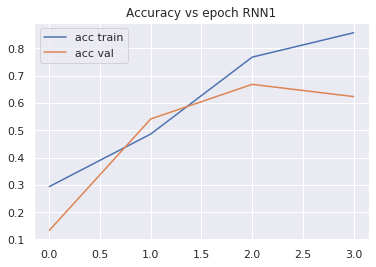


------ Training ------
Accuracy rnn1 : 0.8371346626604753
F1-score None rnn1 : [0.75753318 0.86512729 0.91414844 0.78572523]
F1-score macro rnn1 : 0.8306335339663028

------ Validation ------
Accuracy rnn1 : 0.6230588235294118
F1-score None rnn1 : [0.74489387 0.13247173 0.0952381  0.72804233]
F1-score macro rnn1 : 0.42516150613052683

------ Testing ------
Accuracy rnn1 : 0.5591144606688648
F1-score None rnn1 : [0.70923603 0.18181818 0.18487395 0.58490566]
F1-score macro rnn1 : 0.4152084559255991


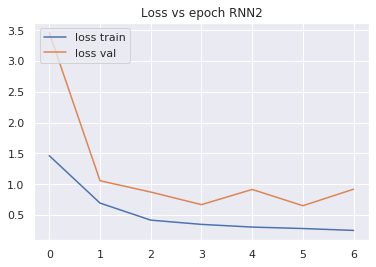

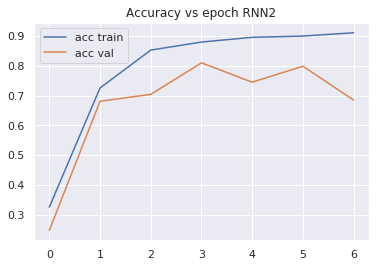


------ Training ------
Accuracy rnn2 : 0.8879404534280251
F1-score None rnn2 : [0.78596947 0.98767123 0.94037522 0.82480119]
F1-score macro rnn2 : 0.8847042803012295

------ Validation ------
Accuracy rnn2 : 0.6847058823529412
F1-score None rnn2 : [0.78706625 0.125      0.06779661 0.61762665]
F1-score macro rnn2 : 0.3993723760968183

------ Testing ------
Accuracy rnn2 : 0.6603862458784738
F1-score None rnn2 : [0.78355766 0.14492754 0.20325203 0.52111411]
F1-score macro rnn2 : 0.41321283302547845


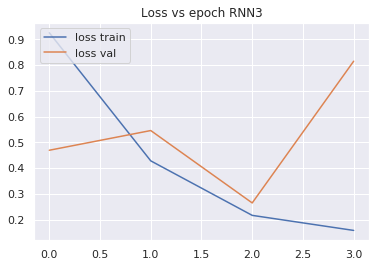

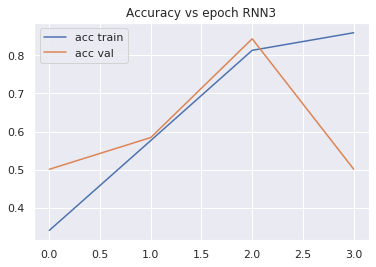


------ Training ------
Accuracy rnn3 : 0.756077574433215
F1-score None rnn3 : [0.7197021  0.94003198 0.72119838 0.61441787]
F1-score macro rnn3 : 0.7488375848811777

------ Validation ------
Accuracy rnn3 : 0.5016470588235294
F1-score None rnn3 : [0.68502582 0.1350211  0.05348837 0.55729795]
F1-score macro rnn3 : 0.35770830900798123

------ Testing ------
Accuracy rnn3 : 0.4861045690061234
F1-score None rnn3 : [0.6723301  0.22686567 0.14087513 0.38645418]
F1-score macro rnn3 : 0.35663127135014605

Entrenando exec  3 



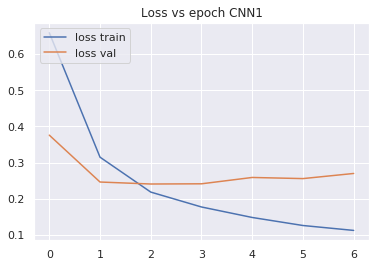

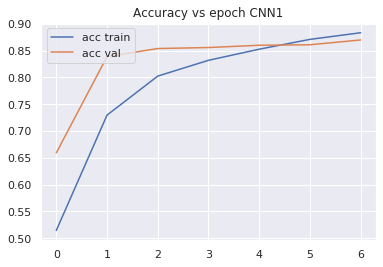


------ Training ------
Accuracy cnn1 : 0.9280251297459711
F1-score None cnn1 : [0.86946506 0.99451754 0.99493636 0.85285985]
F1-score macro cnn1 : 0.9279447036720648

------ Validation ------
Accuracy cnn1 : 0.8696470588235294
F1-score None cnn1 : [0.92052346 0.02739726 0.04651163 0.80719281]
F1-score macro cnn1 : 0.45040628882907585

------ Testing ------
Accuracy cnn1 : 0.833254828073481
F1-score None cnn1 : [0.90346606 0.01818182 0.12048193 0.66192171]
F1-score macro cnn1 : 0.4260128774122961


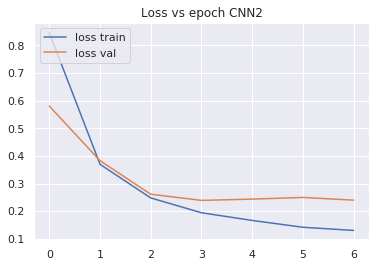

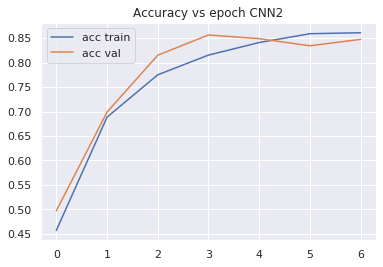


------ Training ------
Accuracy cnn2 : 0.941272876263316
F1-score None cnn2 : [0.88922778 0.99319913 0.9939759  0.88852945]
F1-score macro cnn2 : 0.9412330669202139

------ Validation ------
Accuracy cnn2 : 0.8475294117647059
F1-score None cnn2 : [0.90823212 0.13084112 0.04347826 0.7890556 ]
F1-score macro cnn2 : 0.467901776428228

------ Testing ------
Accuracy cnn2 : 0.8233631653320772
F1-score None cnn2 : [0.89833641 0.19101124 0.08421053 0.74002751]
F1-score macro cnn2 : 0.4783964216588184


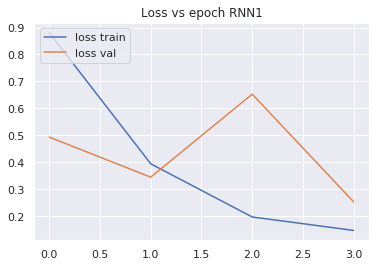

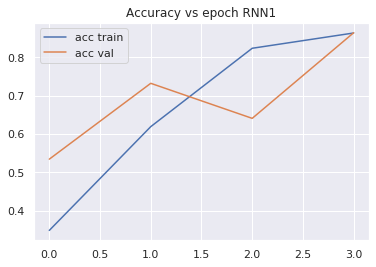


------ Training ------
Accuracy rnn1 : 0.8748975689702267
F1-score None rnn1 : [0.84858922 0.96966399 0.88962406 0.79788059]
F1-score macro rnn1 : 0.8764394644646218

------ Validation ------
Accuracy rnn1 : 0.864
F1-score None rnn1 : [0.91716368 0.1754386  0.         0.82539683]
F1-score macro rnn1 : 0.47949977661184107

------ Testing ------
Accuracy rnn1 : 0.8299576071596797
F1-score None rnn1 : [0.90295359 0.17112299 0.1682243  0.75394322]
F1-score macro rnn1 : 0.49906102447033307


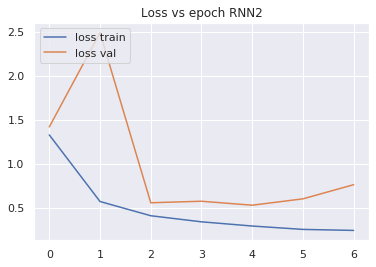

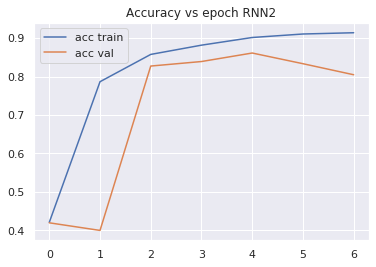


------ Training ------
Accuracy rnn2 : 0.8723026495493035
F1-score None rnn2 : [0.86717719 0.97669256 0.88152344 0.74504751]
F1-score macro rnn2 : 0.8676101757023875

------ Validation ------
Accuracy rnn2 : 0.8047058823529412
F1-score None rnn2 : [0.92161364 0.02469136 0.05084746 0.67420814]
F1-score macro rnn2 : 0.4178401510664588

------ Testing ------
Accuracy rnn2 : 0.8125294394724446
F1-score None rnn2 : [0.90844233 0.03636364 0.272      0.61685824]
F1-score macro rnn2 : 0.45841605111759687


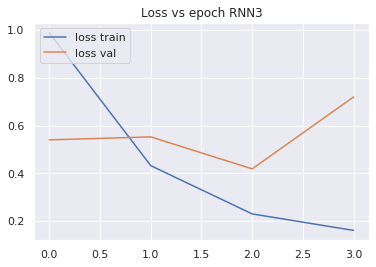

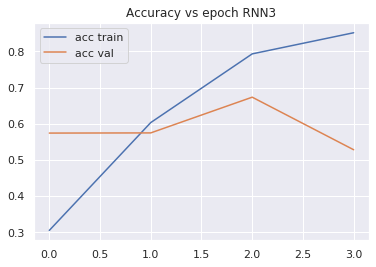


------ Training ------
Accuracy rnn3 : 0.8171947555312756
F1-score None rnn3 : [0.70057084 0.93223183 0.84204454 0.75623855]
F1-score macro rnn3 : 0.8077714372413409

------ Validation ------
Accuracy rnn3 : 0.528
F1-score None rnn3 : [0.64984506 0.10695187 0.0546875  0.64072398]
F1-score macro rnn3 : 0.36305210443647506

------ Testing ------
Accuracy rnn3 : 0.46066886481394254
F1-score None rnn3 : [0.5862069  0.17594255 0.16640502 0.53551913]
F1-score macro rnn3 : 0.3660183987885747

Entrenando exec  4 



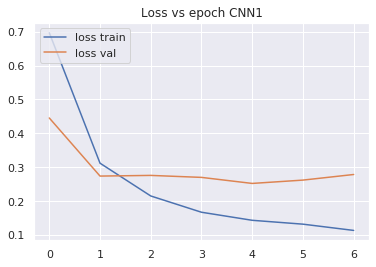

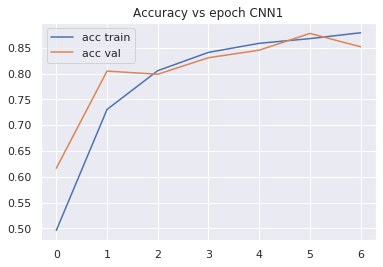


------ Training ------
Accuracy cnn1 : 0.9432532095055995
F1-score None cnn1 : [0.8884753  0.99535011 0.99319357 0.89548725]
F1-score macro cnn1 : 0.9431265587333648

------ Validation ------
Accuracy cnn1 : 0.851764705882353
F1-score None cnn1 : [0.91401165 0.05333333 0.06896552 0.78797997]
F1-score macro cnn1 : 0.4560726162525821

------ Testing ------
Accuracy cnn1 : 0.8181818181818182
F1-score None cnn1 : [0.90003154 0.05084746 0.18518519 0.69964664]
F1-score macro cnn1 : 0.4589277054287424


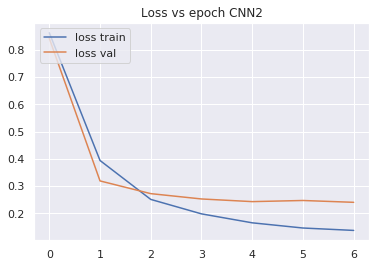

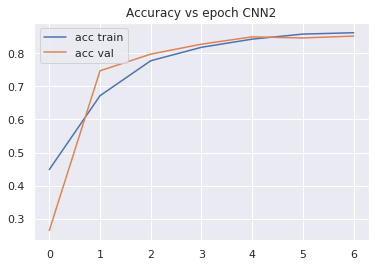


------ Training ------
Accuracy cnn2 : 0.9342392788855504
F1-score None cnn2 : [0.88667667 0.99198261 0.98234739 0.8738676 ]
F1-score macro cnn2 : 0.9337185654517822

------ Validation ------
Accuracy cnn2 : 0.8522352941176471
F1-score None cnn2 : [0.91407556 0.22413793 0.11904762 0.80453258]
F1-score macro cnn2 : 0.5154484219997895

------ Testing ------
Accuracy cnn2 : 0.8214790390956194
F1-score None cnn2 : [0.9023795  0.1420765  0.25       0.72419106]
F1-score macro cnn2 : 0.5046617664003226


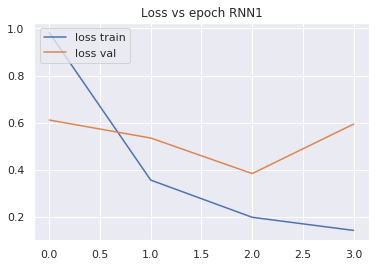

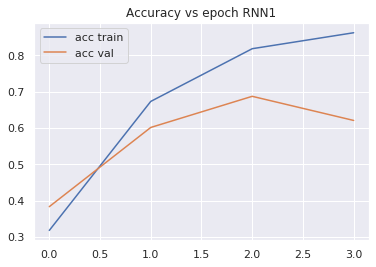


------ Training ------
Accuracy rnn1 : 0.8542747883092051
F1-score None rnn1 : [0.73924642 0.87693601 0.95847937 0.81824208]
F1-score macro rnn1 : 0.8482259688595755

------ Validation ------
Accuracy rnn1 : 0.6207058823529412
F1-score None rnn1 : [0.72365145 0.12307692 0.07272727 0.71091703]
F1-score macro rnn1 : 0.4075931696635098

------ Testing ------
Accuracy rnn1 : 0.5515779557230335
F1-score None rnn1 : [0.68185452 0.18844221 0.19148936 0.59210526]
F1-score macro rnn1 : 0.4134728380755473


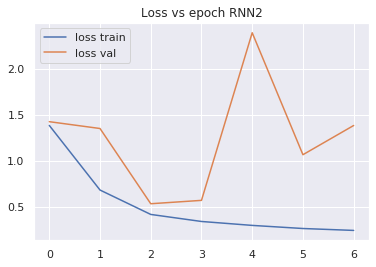

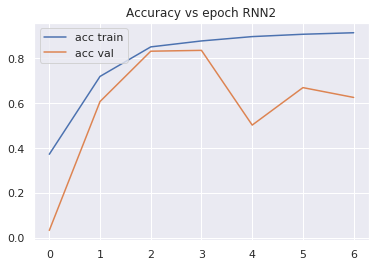


------ Training ------
Accuracy rnn2 : 0.8231357552581262
F1-score None rnn2 : [0.82787392 0.92930575 0.81938227 0.6842193 ]
F1-score macro rnn2 : 0.8151953096525839

------ Validation ------
Accuracy rnn2 : 0.6263529411764706
F1-score None rnn2 : [0.80217223 0.13888889 0.07159905 0.57558791]
F1-score macro rnn2 : 0.3970620166755492

------ Testing ------
Accuracy rnn2 : 0.5963259538389072
F1-score None rnn2 : [0.76518519 0.1984127  0.18867925 0.48849558]
F1-score macro rnn2 : 0.41019317602553534


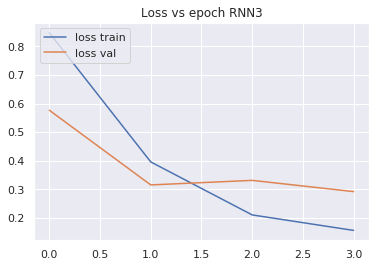

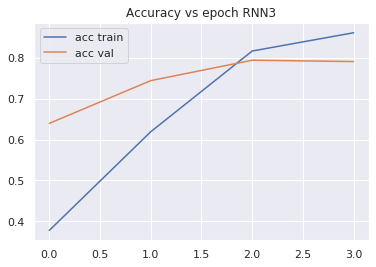


------ Training ------
Accuracy rnn3 : 0.8757853045615952
F1-score None rnn3 : [0.83139623 0.97029163 0.90295735 0.80805026]
F1-score macro rnn3 : 0.8781738659335871

------ Validation ------
Accuracy rnn3 : 0.7905882352941176
F1-score None rnn3 : [0.8604821  0.14634146 0.         0.7358209 ]
F1-score macro rnn3 : 0.4356611156655923

------ Testing ------
Accuracy rnn3 : 0.753650494583137
F1-score None rnn3 : [0.85153872 0.20942408 0.13793103 0.63747454]
F1-score macro rnn3 : 0.45909209542032386

Entrenando exec  5 



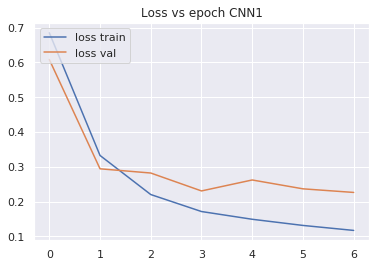

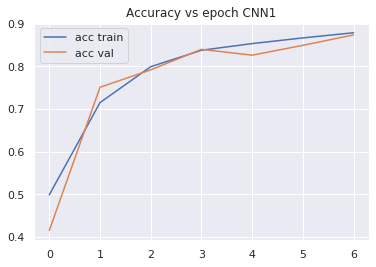


------ Training ------
Accuracy cnn1 : 0.9390193936083038
F1-score None cnn1 : [0.88885881 0.99197606 0.99175824 0.88359934]
F1-score macro cnn1 : 0.9390481128827521

------ Validation ------
Accuracy cnn1 : 0.8734117647058823
F1-score None cnn1 : [0.92450331 0.21153846 0.04081633 0.83194058]
F1-score macro cnn1 : 0.5021996687501296

------ Testing ------
Accuracy cnn1 : 0.8327837965143665
F1-score None cnn1 : [0.90499098 0.17647059 0.04597701 0.74208145]
F1-score macro cnn1 : 0.46738000696242293


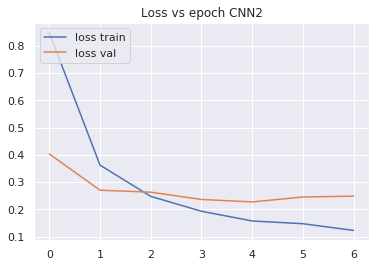

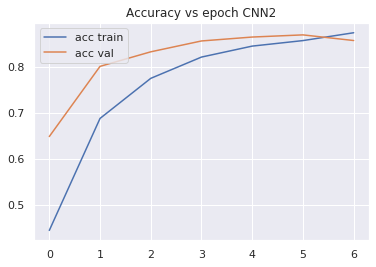


------ Training ------
Accuracy cnn2 : 0.9224938541382136
F1-score None cnn2 : [0.86317653 0.99333787 0.9933051  0.83745899]
F1-score macro cnn2 : 0.9218196209414845

------ Validation ------
Accuracy cnn2 : 0.8564705882352941
F1-score None cnn2 : [0.91328    0.08602151 0.03846154 0.79183673]
F1-score macro cnn2 : 0.45739994463294004

------ Testing ------
Accuracy cnn2 : 0.8224211022138483
F1-score None cnn2 : [0.89657159 0.07092199 0.1443299  0.66294227]
F1-score macro cnn2 : 0.44369143695111135


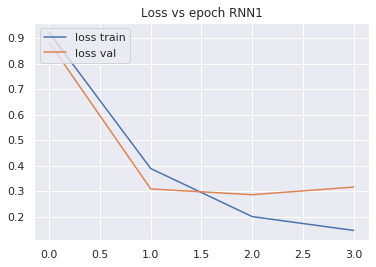

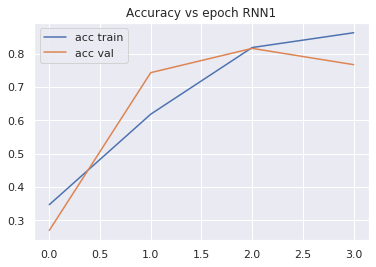


------ Training ------
Accuracy rnn1 : 0.8979786943458071
F1-score None rnn1 : [0.83068625 0.95992594 0.95568829 0.84262796]
F1-score macro rnn1 : 0.8972321077921117

------ Validation ------
Accuracy rnn1 : 0.7675294117647059
F1-score None rnn1 : [0.84974093 0.13043478 0.02857143 0.74839744]
F1-score macro rnn1 : 0.4392861449300118

------ Testing ------
Accuracy rnn1 : 0.7164390014130947
F1-score None rnn1 : [0.82058414 0.20396601 0.26388889 0.65521191]
F1-score macro rnn1 : 0.4859127380359559


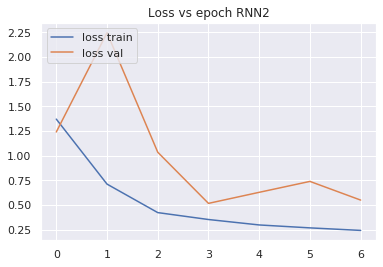

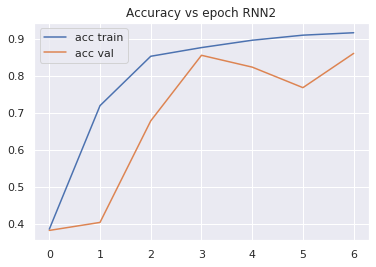


------ Training ------
Accuracy rnn2 : 0.9364927615405627
F1-score None rnn2 : [0.89008413 0.98006466 0.98605659 0.88762801]
F1-score macro rnn2 : 0.9359583443394935

------ Validation ------
Accuracy rnn2 : 0.8607058823529412
F1-score None rnn2 : [0.92271819 0.14035088 0.08571429 0.81390977]
F1-score macro rnn2 : 0.49067328130452714

------ Testing ------
Accuracy rnn2 : 0.8304286387187941
F1-score None rnn2 : [0.91181764 0.13872832 0.23776224 0.71812081]
F1-score macro rnn2 : 0.5016072508258731


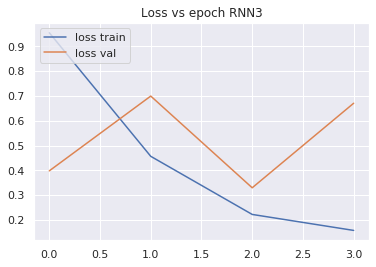

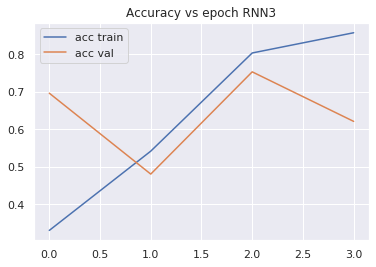


------ Training ------
Accuracy rnn3 : 0.7977328598743513
F1-score None rnn3 : [0.7871295  0.90015757 0.77395447 0.73309934]
F1-score macro rnn3 : 0.7985852212925243

------ Validation ------
Accuracy rnn3 : 0.6211764705882353
F1-score None rnn3 : [0.77914843 0.08040201 0.04502814 0.63880597]
F1-score macro rnn3 : 0.3858461377405302

------ Testing ------
Accuracy rnn3 : 0.5723033443240697
F1-score None rnn3 : [0.7333079  0.21568627 0.14003044 0.52870091]
F1-score macro rnn3 : 0.4044313800008675


In [17]:
fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

for i in range(1,6):    
    print ("\nEntrenando exec ", i,"\n")
    cnn1=create_ccn1(x_train.shape[1:])
    trained, hist =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=7, BS=32, verb=0, focal=True)
    trained.save('../Datasets/Models_Harassment/0.85/cnn1_'+str(i)+'-exec.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch CNN1")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch CNN1")
    plt.show()
    
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, n_labels, n_labels_val, n_labels_test, 'cnn1')
    fs_macro['cnn1'].append(f1_ma_t)
    fs_none['cnn1'].append(f1_t)
    accs['cnn1'].append(acc_t)
    confusions['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    trained, hist =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=7, BS=32, verb=0, focal=True)
    trained.save('../Datasets/Models_Harassment/0.85/cnn2_'+str(i)+'-exec.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch CNN2")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch CNN2")
    plt.show()
    
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'cnn2')
    fs_macro['cnn2'].append(f1_ma_t)
    fs_none['cnn2'].append(f1_t)
    accs['cnn2'].append(acc_t)
    confusions['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    trained.save('../Datasets/Models_Harassment/0.85/rnn1_'+str(i)+'-exec.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN1")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN1")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn1')
    fs_macro['rnn1'].append(f1_ma_t)
    fs_none['rnn1'].append(f1_t)
    accs['rnn1'].append(acc_t)
    confusions['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=7, BS=32, verb=0, focal=False)
    trained.save('../Datasets/Models_Harassment/0.85/rnn2_'+str(i)+'-exec.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN2")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN2")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn2')
    fs_macro['rnn2'].append(f1_ma_t)
    fs_none['rnn2'].append(f1_t)
    accs['rnn2'].append(acc_t)
    confusions['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    trained.save('../Datasets/Models_Harassment/0.85/rnn3_'+str(i)+'-exec.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN3")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN3")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn3')
    fs_macro['rnn3'].append(f1_ma_t)
    fs_none['rnn3'].append(f1_t)
    accs['rnn3'].append(acc_t)
    confusions['rnn3'].append(matriz_t)


In [18]:
print ("--------- Usando contexto positivo y negativo obligadamente ---------\n")

for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("0.85 Clase Ponderado - F1-score promedio para",key,":" ,temp/5)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("0.85 Clase Ponderado - F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("0.85 Clase Ponderado - Accuracy promedio para",key,":" ,temp/5)

--------- Usando contexto positivo y negativo obligadamente ---------

0.85 Clase Ponderado - F1-score promedio para cnn1 : [0.90469334 0.09023623 0.07032882 0.71631725]
0.85 Clase Ponderado - F1-score promedio para cnn2 : [0.89968928 0.13360389 0.14009636 0.72122461]
0.85 Clase Ponderado - F1-score promedio para rnn1 : [0.79761581 0.1679888  0.21141281 0.6486952 ]
0.85 Clase Ponderado - F1-score promedio para rnn2 : [0.84963735 0.14178168 0.22802082 0.62249439]
0.85 Clase Ponderado - F1-score promedio para rnn3 : [0.74914974 0.17183372 0.15968792 0.55888176]

0.85 Clase Ponderado - F1-score macro promedio para cnn1 : 0.4453939127675445 desvest:  0.015480524841142231
0.85 Clase Ponderado - F1-score macro promedio para cnn2 : 0.473653535735853 desvest:  0.020826919110263416
0.85 Clase Ponderado - F1-score macro promedio para rnn1 : 0.4564281541464676 desvest:  0.03571137010646611
0.85 Clase Ponderado - F1-score macro promedio para rnn2 : 0.46048355879270303 desvest:  0.04445650211326112